# **Projet Deep Learning et Traiement du Signal - SincNet pour la Reconnaissance des Emotions dans la Parole**

### *Léos Coutrot - Mathis Pernin*

In [ ]:
import os
import re
import pandas as pd
import numpy as np
import librosa
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.effects
from scipy.signal import welch
import scipy.stats
from scipy.fft import fft, fftfreq
import random
from IPython.display import Audio, display
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, balanced_accuracy_score
from collections import defaultdict
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import soundfile as sf
from sklearn.model_selection import KFold
import torch.nn.functional as F

## <u>Partie I : Etude bibliographique</u>


### Reference Paper
**Title:** *Speaker Recognition from Raw Waveform with SincNet* (2019)  
**Authors:** Mirco Ravanelli & Yoshua Bengio (MILA)

### 1. Context and Motivation
Traditional speaker recognition systems largely rely on **hand-crafted features** (e.g., FBANK, MFCC) or **i-vector** representations. While robust, these fixed feature extraction methods may inadvertently smooth out or lose narrow-band, high-frequency clues essential for distinguishing speaker identities.

Recent trends have shifted towards **Deep Learning on raw waveforms**, typically using Convolutional Neural Networks (CNNs). Standard CNNs process raw audio using learned Finite Impulse Response (FIR) filters:

$$y[n] = (x \ast h)[n] = \sum_{l=0}^{L-1} x[l] \cdot h[n-l]$$

where $L$ is the filter length and all elements of $h$ are learned parameters.

**Problem:** The first layer of a standard CNN often struggles with raw audio. It tends to learn noisy, uninterpretable filters, particularly when training data is scarce. This results in high dimensionality and inefficient learning.

### 2. The SincNet Innovation
SincNet introduces a constrained architectural inductive bias. Instead of learning every point in the filter kernel $h$, SincNet defines the first convolution layer as a set of **parametrized band-pass filters**.

#### Mathematical Formulation
The core idea is to convolve the waveform with a function $g$ that depends only on a few learnable parameters $\theta$:
$$y[n] = (x \ast g_{\theta})[n]$$

In the **Frequency Domain**, a generic band-pass filter can be defined as the difference between two rectangular functions:
$$G[f, f_1, f_2] = \text{rect}\left(\frac{f}{2f_2}\right) - \text{rect}\left(\frac{f}{2f_1}\right)$$
where $f_1$ and $f_2$ are the learned low and high cutoff frequencies.

By applying the Inverse Fourier Transform, we obtain the filter in the **Time Domain** (using the property that the transform of a rect is a sinc):
$$g[n, f_1, f_2] = 2f_2 \text{sinc}(2\pi f_2 n) - 2f_1 \text{sinc}(2\pi f_1 n)$$
where $\text{sinc}(x) = \sin(x)/x$.

**Advantage:** This reduces the number of parameters per filter from $L$ (filter length, e.g., 251) to just **2** ($f_1, f_2$).


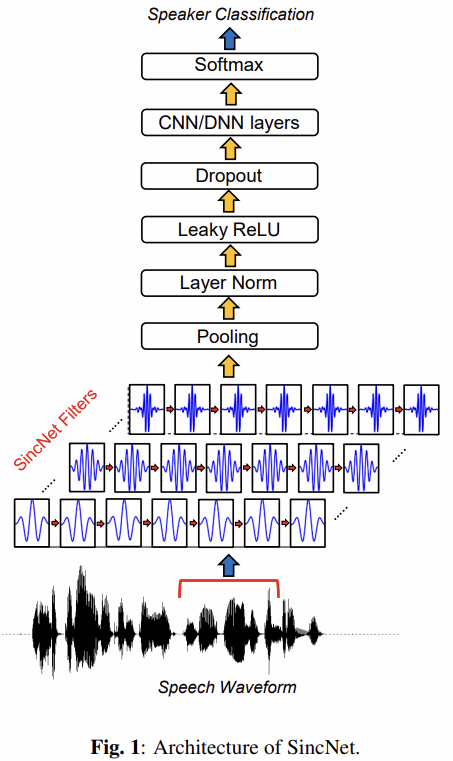


### 3. Practical Implementation & Signal Processing Constraints
To make this approach viable in a deep learning framework, several practical engineering constraints are applied:

**A. Parameter Constraints**
To ensure stability and physical meaning ($f_2 \geq f_1 \geq 0$), the network does not learn $f_1, f_2$ directly, but rather auxiliary parameters that are mapped as follows:
* $f_1^{\text{abs}} = |f_1|$
* $f_2^{\text{abs}} = f_1^{\text{abs}} + |f_2 - f_1^{\text{abs}}|$

**B. Windowing**
The theoretical sinc function is infinite. In practice, the filter must be truncated to length $L$. Abrupt truncation causes ripples in the frequency response (Gibbs phenomenon). To mitigate this, a **Hamming window** $w[n]$ is applied:
$$g_w[n, f_1, f_2] = g[n, f_1, f_2] \cdot w[n]$$
$$w[n] = 0.54 - 0.46 \cos\left(\frac{2\pi n}{L}\right)$$

**C. Symmetry**
Since the sinc function and the window are symmetric, the convolution can be computed efficiently by processing one half of the filter and mirroring it.

### 4. Expected Benefits
1.  **Fast Convergence:** By forcing the network to focus only on high-impact parameters (cutoff frequencies), the model converges significantly faster than standard CNNs.
2.  **Parameter Efficiency:** drastic reduction in the first layer's parameter count ($2 \cdot F$ vs $F \cdot L$).
3.  **Interpretability:** The resulting filters are human-readable band-pass filters, allowing direct analysis of which frequency bands the network uses to identify speakers.
4.  **Few-Shot Robustness:** The constraints act as a regularizer, making SincNet highly suitable for regimes with limited training data.

## <u>Part II : Analyse et Visualisation des données</u>

### Dataset EMO-DB (Berlin Emotional Speech Database)

Le dataset **EMO-DB** est une base de données vocale émotionnelle allemande développée par la **Technische Universität Berlin**.

#### Caractéristiques générales
- **Nombre total d’enregistrements** : 535 fichiers audio  
- **Langue** : Allemand  
- **Nombre de locuteurs** : 10 (5 hommes, 5 femmes)  
- **Type de locuteurs** : Acteurs et actrices professionnels  
- **Durée des énoncés** : Courtes phrases (quelques secondes)  

#### Paramètres d’enregistrement
- **Fréquence d’échantillonnage originale** : 48 kHz  
- **Fréquence d’échantillonnage utilisée** : 16 kHz  
- **Format audio** : WAV  
- **Canal** : Mono  

#### Émotions représentées

| Code | Émotion (anglais) | Émotion (français) |
|------|------------------|-------------------|
| A | Anger | Colère |
| B | Boredom | Ennui |
| D | Disgust | Dégoût |
| F | Fear | Peur |
| H | Happiness | Joie |
| S | Sadness | Tristesse |
| N | Neutral | Neutre |

Le jeu de données EMO-DB présente plusieurs caractéristiques qui en font un choix pertinent pour la **reconnaissance des émotions à partir de signaux vocaux** :

- Les émotions sont clairement exprimées et contrôlées, car les enregistrements ont été réalisés par des acteurs professionnels.
- Les annotations émotionnelles sont fiables et cohérentes.
- Les signaux audio sont de haute qualité.
- La présence de plusieurs locuteurs introduit une variabilité inter-locuteurs.

In [ ]:
# Mapping des codes d'émotion EMO-DB
EMOTION_MAP = {
    'W': ('anger', 0),
    'L': ('boredom', 1),
    'E': ('disgust', 2),
    'A': ('fear', 3),
    'F': ('happiness', 4),
    'T': ('sadness', 5),
    'N': ('neutral', 6),
}
SAMPLING_RATE = 16000
DATA_DIR = Path('./data')
AUDIO_EXT = '.wav'

### Chargement du Dataset EMO-DB

In [ ]:
def parse_filename(filename):
    """Parse le nom de fichier pour extraire les métadonnées. Example: 03a01Fa.wav"""
    m = re.match(r'(\d{2})([a-z]\d{2})([A-Z])([a-z]?)\.wav', filename)
    if not m:
        return None
    speaker, text, emotion_code, version = m.groups()
    emotion, emotion_idx = EMOTION_MAP[emotion_code]
    return {
        'filename': filename,
        'speaker_id': speaker,
        'text_id': text,
        'emotion_code': emotion_code,
        'emotion': emotion,
        'emotion_idx': emotion_idx,
        'version': version or None
    }

In [ ]:
# Parcours des fichiers
records = []
for fname in os.listdir(DATA_DIR):
    if fname.endswith(AUDIO_EXT):
        meta = parse_filename(fname)
        if meta:
            meta['filepath'] = str(DATA_DIR / fname)
            records.append(meta)

df = pd.DataFrame(records)
print(f"{len(df)} fichiers chargés.")

535 fichiers chargés.


In [ ]:
df.head(5)

filename speaker_id text_id emotion_code    emotion  emotion_idx  \
0  03a01Fa.wav         03     a01            F  happiness            4   
1  03a01Nc.wav         03     a01            N    neutral            6   
2  03a01Wa.wav         03     a01            W      anger            0   
3  03a02Fc.wav         03     a02            F  happiness            4   
4  03a02Nc.wav         03     a02            N    neutral            6   

  version          filepath  
0       a  data\03a01Fa.wav  
1       c  data\03a01Nc.wav  
2       a  data\03a01Wa.wav  
3       c  data\03a02Fc.wav  
4       c  data\03a02Nc.wav

### 1. Analyse Exploratoire des Données (EDA)

#### 1.1 Distribution des classes d'émotion

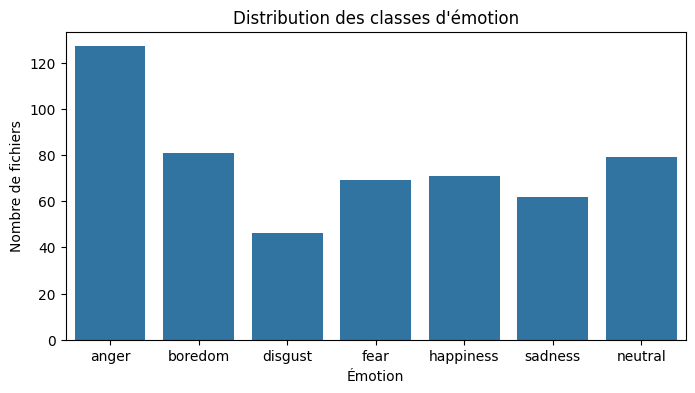

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='emotion', order=[v[0] for v in EMOTION_MAP.values()])
plt.title('Distribution des classes d\'émotion')
plt.ylabel('Nombre de fichiers')
plt.xlabel('Émotion')
plt.show()

#### 1.2 Distribution par émotion

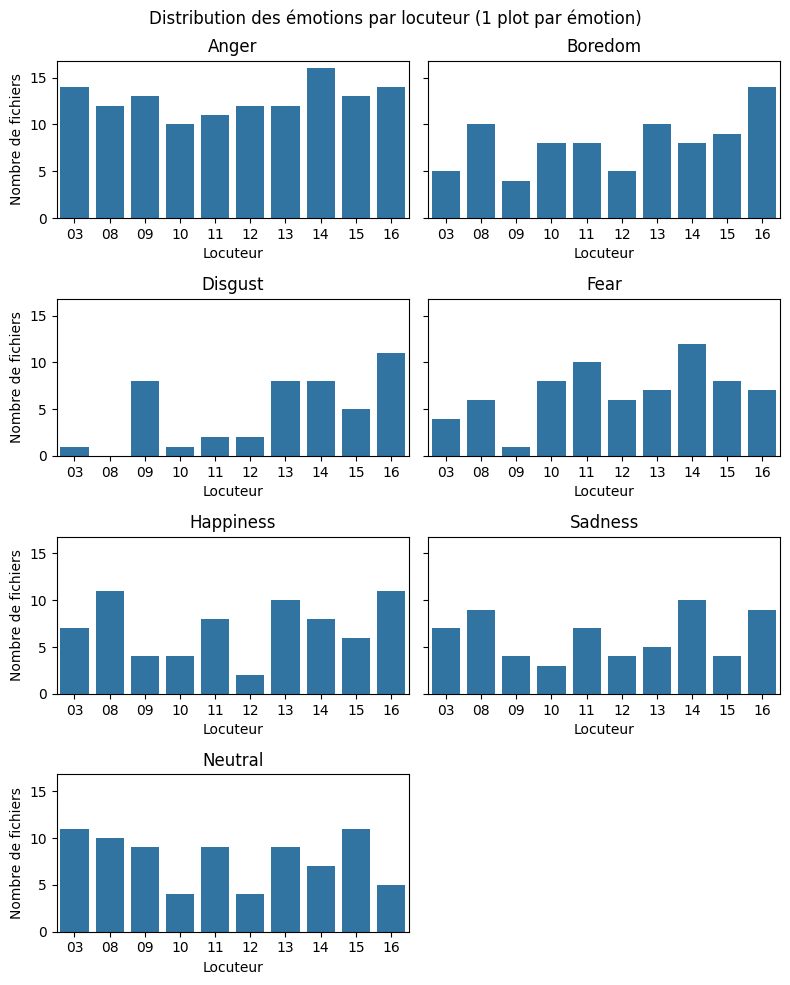

In [ ]:
emotions = [v[0] for v in EMOTION_MAP.values()]
ncols = 2
nrows = int(np.ceil(len(emotions) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(8, 10), sharey=True)
axes = axes.flatten()

for i, emotion in enumerate(emotions):
    ax = axes[i]
    sns.countplot(data=df[df['emotion'] == emotion], x='speaker_id', order=sorted(df['speaker_id'].unique()), ax=ax)
    ax.set_title(emotion.capitalize())
    ax.set_xlabel('Locuteur')
    if i % ncols == 0:
        ax.set_ylabel('Nombre de fichiers')
    else:
        ax.set_ylabel('')

for j in range(i+1, len(axes)):
    axes[j].axis('off')

fig.suptitle("Distribution des émotions par locuteur (1 plot par émotion)")
fig.tight_layout()
plt.show()

Le dataset présente un déséquilibre entre les classes, plus ou moins important selon les locuteurs. Ce biais nous impose de faire un usage précautionneux de l'accuracy standard qui pourrait masquer les erreurs sur les classes minoritaires.

#### 1.3 Statistiques descriptives

In [ ]:
# Calcul des statistiques descriptives pour chaque signal
stats = {
    'mean': [],
    'median': [],
    'std': [],
    'min': [],
    'max': [],
    'skewness': [],
    'q25': [],
    'q75': [],
    'kurtosis': []
}

for fp in tqdm(df['filepath'], desc="Calcul des statistiques"): 
    y, sr = librosa.load(fp, sr=SAMPLING_RATE)
    y, _ = librosa.effects.trim(y, top_db=15)
    stats['mean'].append(np.mean(y))
    stats['std'].append(np.std(y))
    stats['min'].append(np.min(y))
    stats['max'].append(np.max(y))
    stats['q25'].append(np.percentile(y, 25))
    stats['median'].append(np.median(y))
    stats['q75'].append(np.percentile(y, 75))
    stats['skewness'].append(scipy.stats.skew(y))
    stats['kurtosis'].append(scipy.stats.kurtosis(y))

for k, v in stats.items():
    df[k] = v

Calcul des statistiques: 100%|██████████| 535/535 [00:08<00:00, 60.15it/s]


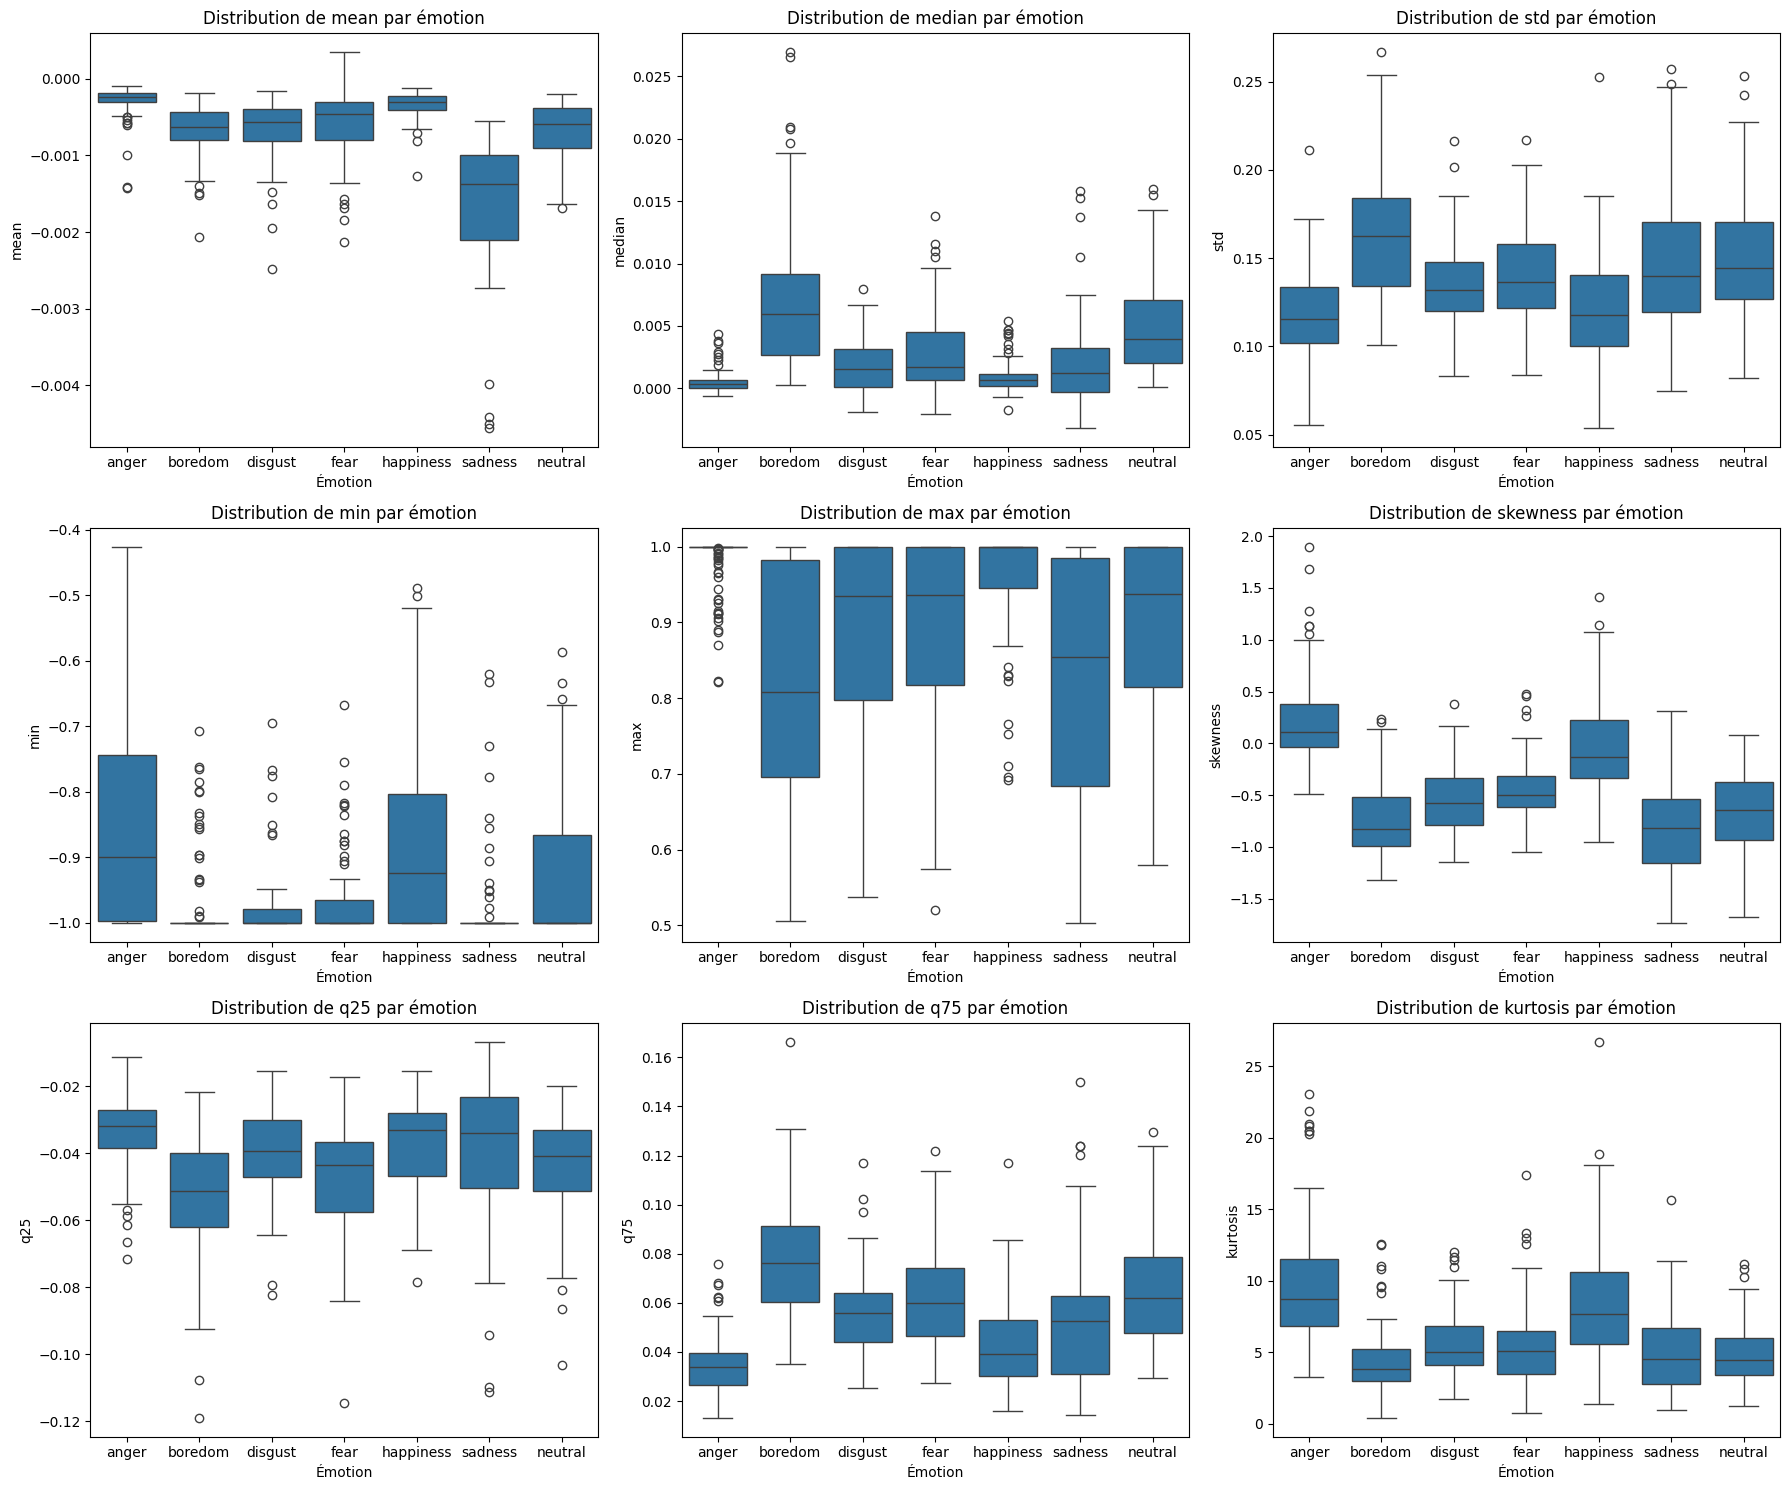

In [ ]:
stat_names = stats.keys()
n_stats = len(stat_names)
ncols = 3
nrows = int(np.ceil(n_stats / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows))

for i, stat in enumerate(stat_names):
    ax = axes.flatten()[i]
    sns.boxplot(data=df, x='emotion', y=stat, order=[v[0] for v in EMOTION_MAP.values()], ax=ax)
    ax.set_title(f'Distribution de {stat} par émotion')
    ax.set_xlabel('Émotion')
    ax.set_ylabel(stat)

for j in range(i+1, nrows*ncols):
    axes.flatten()[j].axis('off')

plt.tight_layout()
plt.show()

L'écart-type (std) et l'amplitude (max/min) permettent de distinguer les émotions à forte activation (Anger, Happiness) de celles à faible activation (Sadness, Boredom). Le fort recouvrement des distributions entre les classes indique qu'une méthode basée uniquement sur ces statistiques aura du mal à séparer finement les émotions.

In [ ]:
# Calculer la durée et l'énergie de chaque signal
durations = []
energies = []

for fp in df['filepath']:
    y, sr = librosa.load(fp, sr=SAMPLING_RATE)
    y, _ = librosa.effects.trim(y, top_db=15)
    durations.append(len(y)/sr)
    energies.append(np.sqrt(np.mean(y**2)))

df['duration_sec'] = durations
df['energy'] = energies

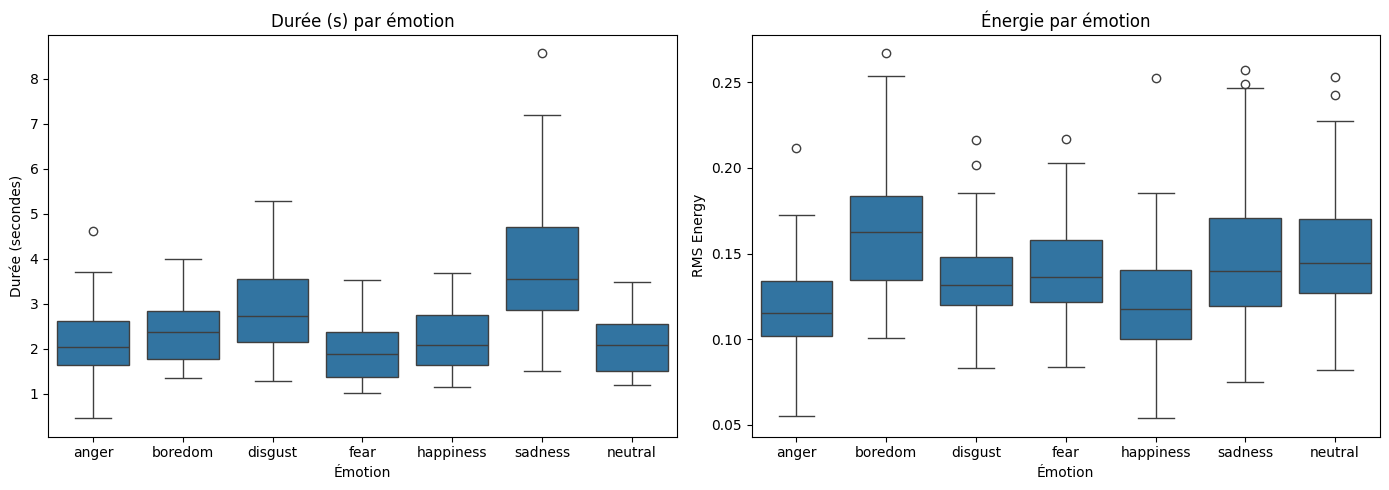

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(data=df, x='emotion', y='duration_sec', order=[v[0] for v in EMOTION_MAP.values()], ax=axes[0])
axes[0].set_title("Durée (s) par émotion")
axes[0].set_xlabel("Émotion")
axes[0].set_ylabel("Durée (secondes)")

sns.boxplot(data=df, x='emotion', y='energy', order=[v[0] for v in EMOTION_MAP.values()], ax=axes[1])
axes[1].set_title("Énergie par émotion")
axes[1].set_xlabel("Émotion")
axes[1].set_ylabel("RMS Energy")

plt.tight_layout()
plt.show()

L'énergie moyenne est plus basse pour Anger ou Happiness, ce qui est contre-intuitif. Cela peut s'expliquer par le fait que ces émotions sont exprimées avec des variations rapides d'amplitude (pics) mais une énergie moyenne plus faible sur l'ensemble de l'énoncé avec plus de silences.

### 2. Visualisation de signaux et spectrogrammes

On compare la même phrase prononcée avec différentes émotions.

In [ ]:
emotions = [v[0] for v in EMOTION_MAP.values()]
group_counts = df.groupby(['text_id', 'speaker_id', 'emotion']).size().unstack(fill_value=0)
valid_pairs = group_counts[(group_counts > 0).all(axis=1)].index.tolist()

random.seed(13)
text_id, speaker_id = random.choice(valid_pairs)
print(f"text_id sélectionné : {text_id} | locuteur : {speaker_id}")
extraits = (
    df[(df['text_id'] == text_id) & (df['speaker_id'] == speaker_id)]
    .groupby('emotion')
    .apply(lambda g: g.sample(1, random_state=13))
    .reset_index(drop=True)
)
for _, row in extraits.iterrows():
    print(f"Émotion: {row['emotion']} | Fichier: {row['filename']}")
    display(Audio(filename=row['filepath'], rate=SAMPLING_RATE))

text_id sélectionné : a04 | locuteur : 16
Émotion: anger | Fichier: 16a04Wc.wav


C:\Users\perni\AppData\Local\Temp\ipykernel_15148\687437168.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(1, random_state=13))


Émotion: boredom | Fichier: 16a04Lc.wav


Émotion: disgust | Fichier: 16a04Ea.wav


Émotion: fear | Fichier: 16a04Ab.wav


Émotion: happiness | Fichier: 16a04Fa.wav


Émotion: neutral | Fichier: 16a04Nc.wav


Émotion: sadness | Fichier: 16a04Tc.wav


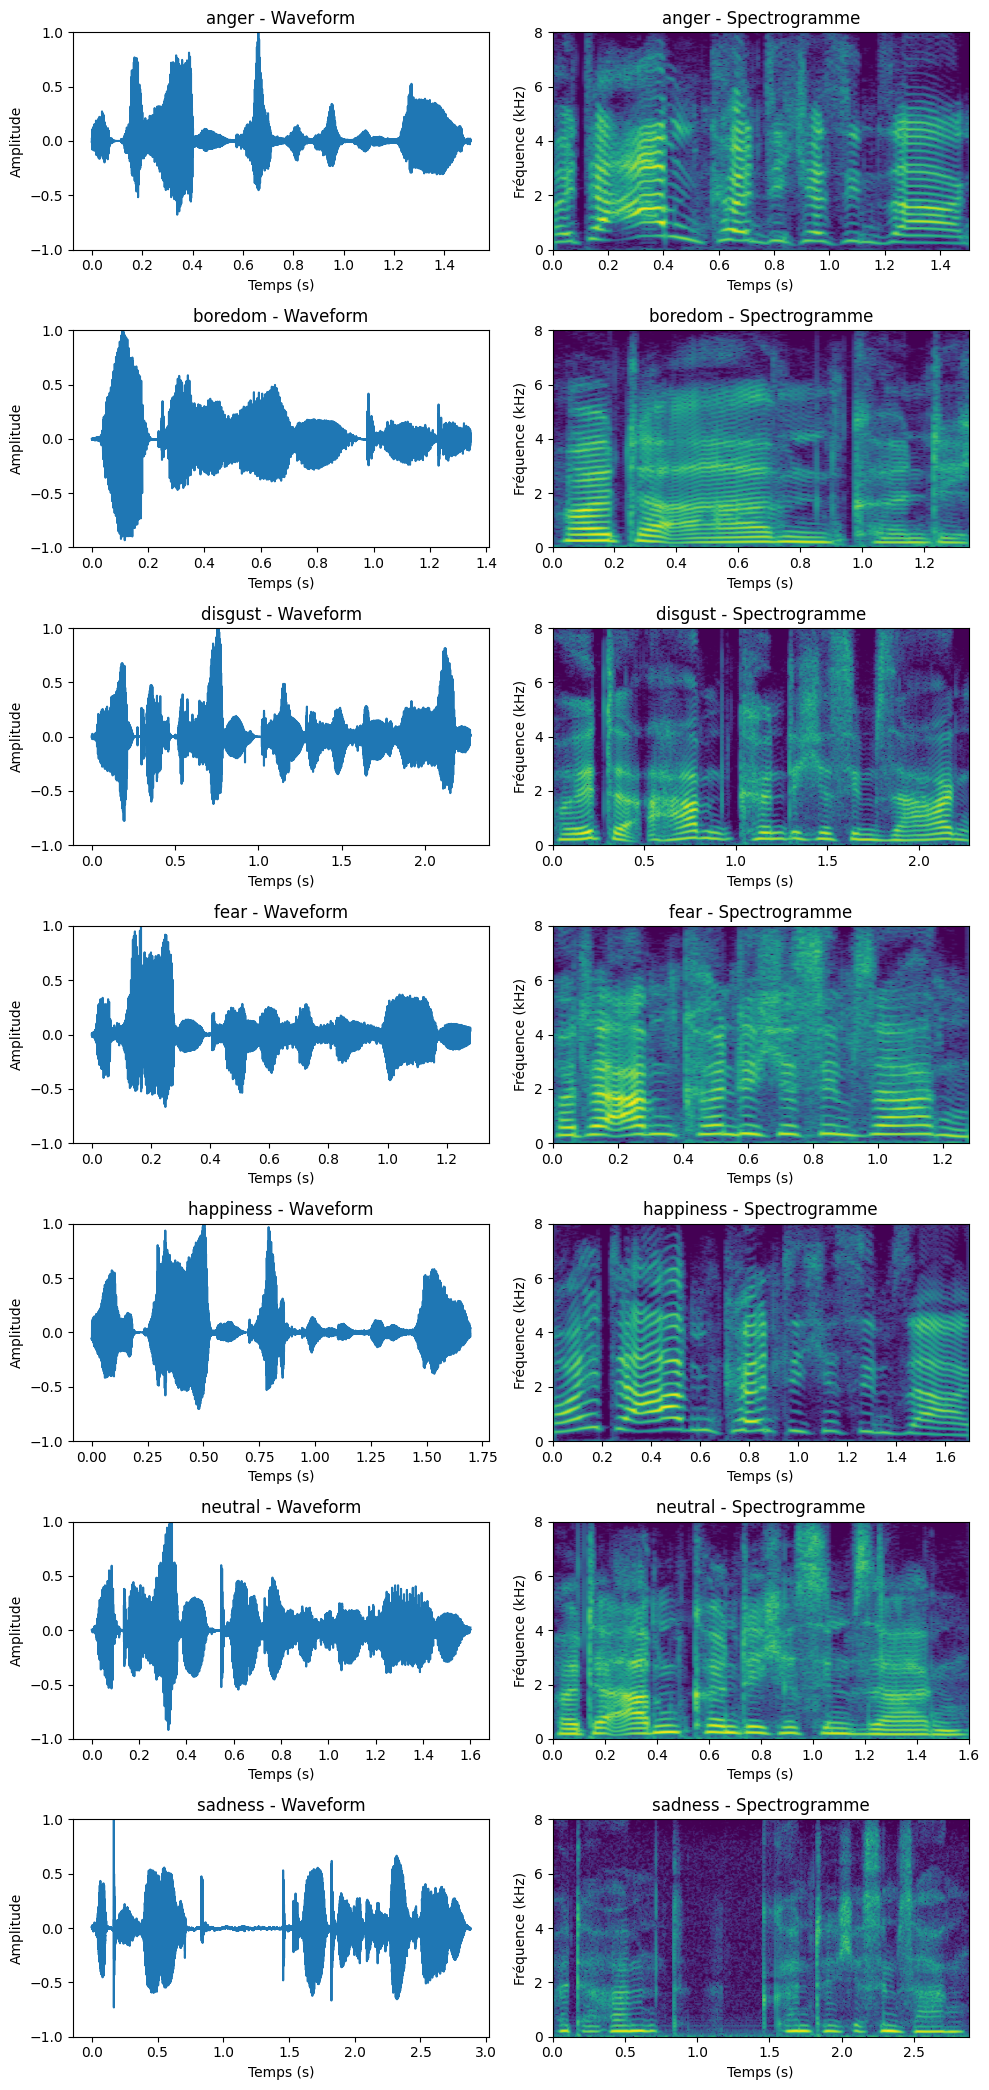

In [ ]:
fig, axes = plt.subplots(len(extraits), 2, figsize=(10, 3*len(extraits)))
for i, row in extraits.iterrows():
    y, sr = librosa.load(row['filepath'], sr=SAMPLING_RATE)
    y, _ = librosa.effects.trim(y, top_db=15)
    y = y / np.max(np.abs(y))
    # Waveform
    axes[i,0].plot(np.arange(len(y))/sr, y)
    axes[i,0].set_title(f"{row['emotion']} - Waveform")
    axes[i,0].set_ylabel('Amplitude')
    axes[i,0].set_xlabel('Temps (s)')
    axes[i,0].set_ylim([-1, 1])
    # Spectrogramme
    S = librosa.amplitude_to_db(np.abs(librosa.stft(y, n_fft=512)), ref=np.max)
    img = axes[i,1].imshow(S, aspect='auto', origin='lower', extent=[0, len(y)/sr, 0, sr/2/1000])
    axes[i,1].set_title(f"{row['emotion']} - Spectrogramme")
    axes[i,1].set_ylabel('Fréquence (kHz)')
    axes[i,1].set_xlabel('Temps (s)')
fig.tight_layout()
plt.show()

On distingue nettement les émotions à forte activation (Anger, Happiness) caractérisées par une grande amplitude et une énergie répartie sur les hautes fréquences, contrairement aux émotions "calmes" (Sadness, Boredom) où l'énergie est concentrée dans les basses fréquences avec un signal plus diffus et des pauses moins marquées.

### 3.Suppression des silences avant/après

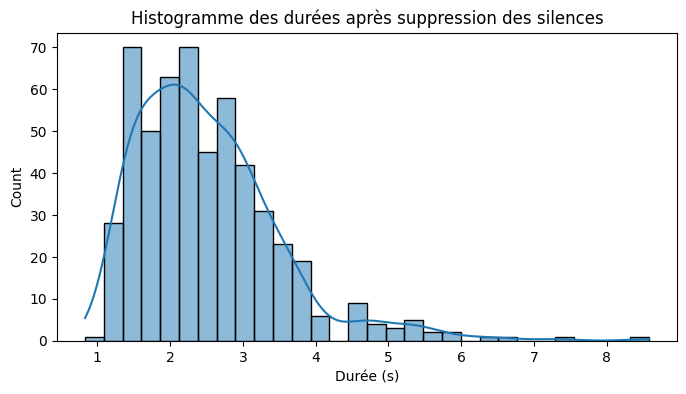

In [ ]:
trimmed_durations = []
for fp in df['filepath']:
    y, sr = librosa.load(fp, sr=SAMPLING_RATE)
    y_trim, _ = librosa.effects.trim(y, top_db=20)
    trimmed_durations.append(len(y_trim)/sr)
df['trimmed_duration_sec'] = trimmed_durations

plt.figure(figsize=(8,4))
sns.histplot(df['trimmed_duration_sec'], bins=30, kde=True)
plt.title('Histogramme des durées après suppression des silences')
plt.xlabel('Durée (s)')
plt.show()

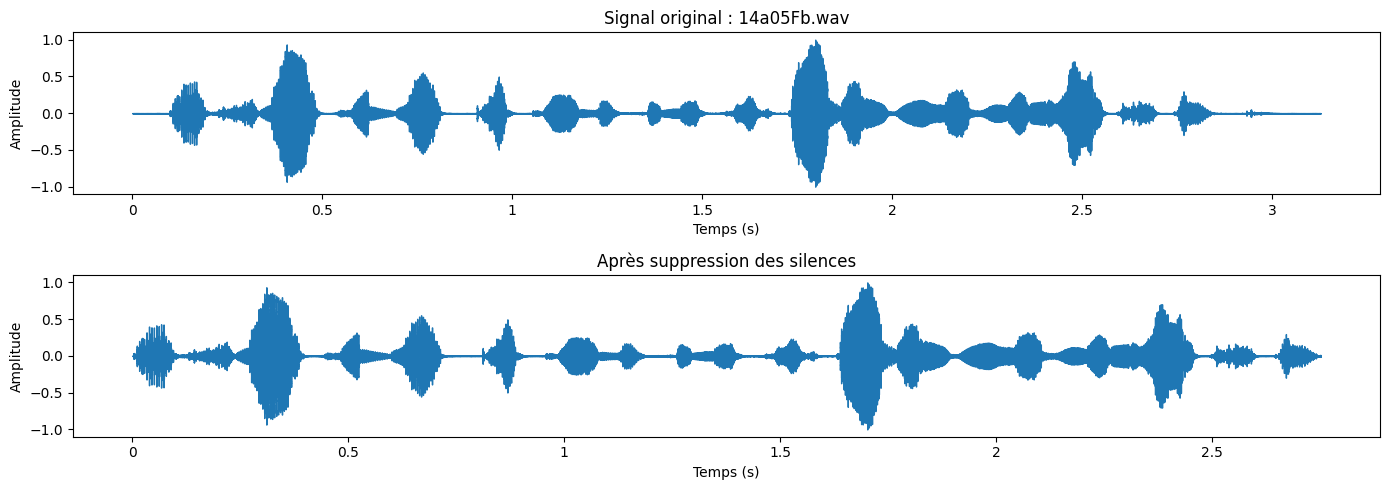

In [ ]:
row = df.sample(1, random_state=1).iloc[0]
y, sr = librosa.load(row['filepath'], sr=SAMPLING_RATE)
y_trim, _ = librosa.effects.trim(y, top_db=15)

plt.figure(figsize=(14, 5))
plt.subplot(2, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title(f"Signal original : {row['filename']}")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")

plt.subplot(2, 1, 2)
librosa.display.waveshow(y_trim, sr=sr)
plt.title("Après suppression des silences")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

In [ ]:
print("Audio original :")
display(Audio(y, rate=sr))
print("Audio après suppression des silences :")
display(Audio(y_trim, rate=sr))

Audio original :


Audio après suppression des silences :


### 4. Densité Spectrale de Puissance par émotion

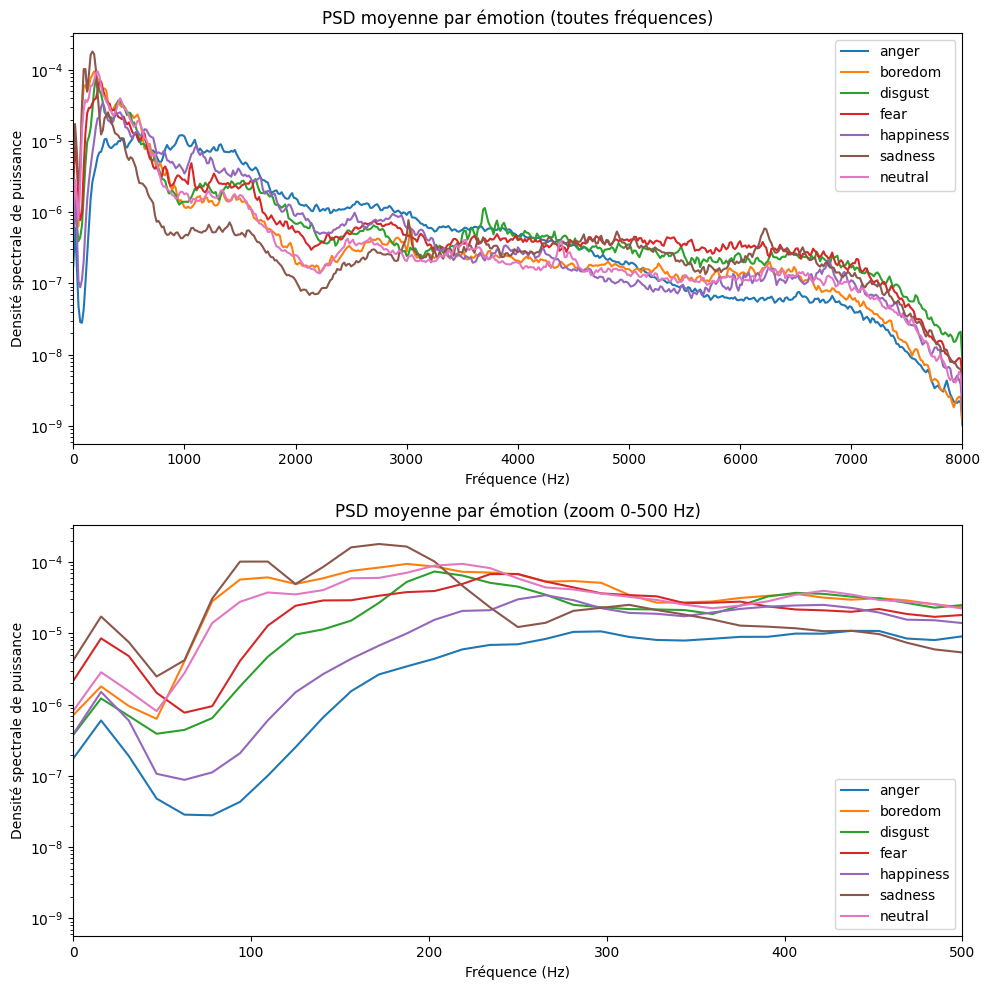

In [ ]:
psd_dict = {emo[0]: [] for emo in EMOTION_MAP.values()}
for _, row in df.iterrows():
    y, sr = librosa.load(row['filepath'], sr=SAMPLING_RATE)
    y_trim, _ = librosa.effects.trim(y, top_db=15)
    f, Pxx = welch(y_trim, fs=sr, nperseg=1024)
    psd_dict[row['emotion']].append(Pxx)

# PSD moyenne par émotion (global + zoom [0, 500] Hz)
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=False)

# Graphe global
for emo, (label, _) in EMOTION_MAP.items():
    if len(psd_dict[label]) == 0:
        continue
    mean_psd = np.mean(psd_dict[label], axis=0)
    axes[0].semilogy(f, mean_psd, label=label)
axes[0].set_title('PSD moyenne par émotion (toutes fréquences)')
axes[0].set_xlabel('Fréquence (Hz)')
axes[0].set_ylabel('Densité spectrale de puissance')
axes[0].legend()
axes[0].set_xlim([0, np.max(f)])

# Graphe zoomé
for emo, (label, _) in EMOTION_MAP.items():
    if len(psd_dict[label]) == 0:
        continue
    mean_psd = np.mean(psd_dict[label], axis=0)
    axes[1].semilogy(f, mean_psd, label=label)
axes[1].set_title('PSD moyenne par émotion (zoom 0-500 Hz)')
axes[1].set_xlabel('Fréquence (Hz)')
axes[1].set_ylabel('Densité spectrale de puissance')
axes[1].set_xlim([0, 500])
axes[1].legend()

plt.tight_layout()
plt.show()

On observe des enveloppes distinctes selon l'activation. Anger conserve une énergie plus élevée dans les moyennes/hautes fréquences comparé à Sadness (marron) dont l'énergie décroît rapidement, reflétant un timbre plus "sourd".

## <u>Partie III : Baseline ML pour la détection d'émotion</u>

In [ ]:
# Split speaker-independant
train_speakers = ['03', '08', '09', '10', '11', '12', '13', '15', '16']
test_speakers = ['14']

### 1. Extraction de features

In [ ]:
# Extraction des features à partir des fichiers audio
records = []
for fname in tqdm(os.listdir(DATA_DIR), desc='Extraction features'):
    if fname.endswith(AUDIO_EXT):
        meta = parse_filename(fname)
        if meta:
            # Load audio
            fp = str(DATA_DIR / fname)
            y, sr = librosa.load(fp, sr=SAMPLING_RATE)

            # Trim silence
            y_trim, _ = librosa.effects.trim(y, top_db=15)

            # Compute statistical features
            features = {
                'mean': np.mean(y_trim),
                'median': np.median(y_trim),
                'std': np.std(y_trim),
                'min': np.min(y_trim),
                'max': np.max(y_trim),
                'skewness': scipy.stats.skew(y_trim),
                'q25': np.percentile(y_trim, 25),
                'q75': np.percentile(y_trim, 75),
                'kurtosis': scipy.stats.kurtosis(y_trim),
                'duration_sec': len(y)/sr,
                'energy': np.sqrt(np.mean(y_trim**2)),
            }

            # Prosodiques
            f0, voiced_flag, voiced_probs = librosa.pyin(y_trim, fmin=50, fmax=500, sr=sr)
            f0_mean = np.nanmean(f0)
            f0_std = np.nanstd(f0)

            # Taux de passage par zéro
            zcr = np.mean(librosa.feature.zero_crossing_rate(y_trim))

            # Énergie RMS
            rms = np.mean(librosa.feature.rms(y=y_trim))

            # Spectrales
            mfccs = librosa.feature.mfcc(y=y_trim, sr=sr, n_mfcc=13)
            mfccs_mean = np.mean(mfccs, axis=1)
            mfccs_std = np.std(mfccs, axis=1)
            spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y_trim, sr=sr))
            spectral_flux = np.mean(np.diff(librosa.feature.spectral_centroid(y=y_trim, sr=sr)))
            spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y_trim, sr=sr, roll_percent=0.85))

            # Ajout aux features
            features.update(
                {
                    'f0_mean': f0_mean,
                    'f0_std': f0_std,
                    'zcr': zcr,
                    'rms': rms,
                    'spectral_centroid': spectral_centroid,
                    'spectral_flux': spectral_flux,
                    'spectral_rolloff': spectral_rolloff
                }
            )
            for i in range(len(mfccs_mean)):
                features[f'mfcc_{i+1}_mean'] = mfccs_mean[i]
                features[f'mfcc_{i+1}_std'] = mfccs_std[i]

            meta.update(features)
            meta['filepath'] = fp
            # Attribution split
            if meta['speaker_id'] in train_speakers:
                meta['split'] = 'train'
            elif meta['speaker_id'] in test_speakers:
                meta['split'] = 'test'
            else:
                meta['split'] = 'unused'
            records.append(meta)

Extraction features:  28%|██▊       | 150/535 [01:31<03:04,  2.09it/s]C:\Users\perni\AppData\Local\Temp\ipykernel_1324\1480755753.py:31: RuntimeWarning: Mean of empty slice
  f0_mean = np.nanmean(f0)
c:\Users\perni\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
Extraction features: 100%|██████████| 535/535 [04:41<00:00,  1.90it/s]


In [ ]:
df = pd.DataFrame(records).fillna(0)
df = df[df['split'].isin(['train', 'test'])].copy()

In [ ]:
# Features à utiliser
stat_features = ['mean', 'median', 'std', 'min', 'max', 'skewness', 'q25', 'q75', 'kurtosis', 'duration_sec', 'energy']
signal_features = ['f0_mean', 'f0_std', 'zcr', 'rms', 'spectral_centroid', 'spectral_flux', 'spectral_rolloff'] + \
    [f'mfcc_{i+1}_mean' for i in range(13)] + [f'mfcc_{i+1}_std' for i in range(13)]
all_features = stat_features + signal_features

# Encodage de la cible
le = LabelEncoder()
df['emotion_label'] = le.fit_transform(df['emotion'])
print('Classes:', le.classes_)

Classes: ['anger' 'boredom' 'disgust' 'fear' 'happiness' 'neutral' 'sadness']


Pour les modèles classiques (SVM, RF, XGBoost), nous avons construit les features suivantes pour chaque fichier audio :

* **Statistiques du signal brut (Temporel) :**
    * *Moments centraux :* Moyenne, médiane, écart-type.
    * *Distribution :* Min, Max, et Quartiles (25%, 75%).
    * *Forme :* Skewness (asymétrie) et Kurtosis (aplatissement), indicateurs de la dynamique impulsionnelle.

* **Caractéristiques Prosodiques :**
    * *$F_0$ (Pitch) :* Fréquence fondamentale pour modéliser l'intonation.
    * *ZCR (Zero Crossing Rate) :* Taux de passage par zéro, discriminant pour le caractère bruité ou harmonique du signal.

* **Caractéristiques Spectrales et Timbrales :**
    * *MFCCs (13 coefficients) :* Moyenne et écart-type de chaque coefficient pour capturer l'enveloppe spectrale globale (timbre).
    * *Descripteurs spectraux :* *Spectral Centroid* (brillance), *Spectral Flux* (instabilité spectrale) et *Rolloff* (répartition de l'énergie fréquentielle).

### 2. Préprocessing et split train/test

In [ ]:
# Séparation train/test speaker-independent
X_train = df[df['split']=='train'][all_features].values
y_train = df[df['split']=='train']['emotion_label'].values
X_test = df[df['split']=='test'][all_features].values
y_test = df[df['split']=='test']['emotion_label'].values

# Standardisation
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 3. Résultats et comparaison des modèles

In [ ]:
models = {
    'SVM': (SVC(), {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto'],
        'class_weight': [None, 'balanced'],
    }),
    'RandomForest': (RandomForestClassifier(random_state=42), {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 10, 20],
        #'min_samples_split': [2, 5],
        'class_weight': [None, 'balanced'],
        'min_samples_leaf': [1, 2, 4]
    }),
    'XGBoost': (XGBClassifier(eval_metric='mlogloss', random_state=42), {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.1, 0.3],
        #'subsample': [0.7, 1.0],
        #'colsample_bytree': [0.7, 1.0],
        #'reg_lambda': [0, 0.1, 1.0],
        'reg_alpha': [1.0, 2.0]
    })
}

In [ ]:
results = {}
scoring_metric = 'f1_macro'

for name, (model, param_grid) in models.items():
    print(f'\n{name}...')
    clf = GridSearchCV(model, param_grid, cv=3, scoring=scoring_metric)

    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    f1_score_value = f1_score(y_test, y_pred, average='macro')
    balanced_acc = balanced_accuracy_score(y_test, y_pred)

    print(f'Best params: {clf.best_params_}')
    print(f'Accuracy: {acc:.3f}')
    print(f'F1 Score (macro): {f1_score_value:.3f}')
    print(f'Balanced Accuracy: {balanced_acc:.3f}')
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    results[name] = {
        'model': clf,
        'y_pred': y_pred,
        'acc': acc,
        'f1_score': f1_score_value,
        'balanced_acc': balanced_acc
    }


SVM...
Best params: {'C': 1, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy: 0.739
F1 Score (macro): 0.701
Balanced Accuracy: 0.702
              precision    recall  f1-score   support

       anger       0.75      0.94      0.83        16
     boredom       0.57      1.00      0.73         8
     disgust       0.86      0.75      0.80         8
        fear       0.75      0.75      0.75        12
   happiness       0.40      0.25      0.31         8
     neutral       1.00      0.43      0.60         7
     sadness       1.00      0.80      0.89        10

    accuracy                           0.74        69
   macro avg       0.76      0.70      0.70        69
weighted avg       0.76      0.74      0.73        69


RandomForest...
Best params: {'class_weight': None, 'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 100}
Accuracy: 0.739
F1 Score (macro): 0.690
Balanced Accuracy: 0.694
              precision    recall  f1-score   support

       anger

XGBoost est la meilleure baseline avec une Accuracy de 77% et un F1-score macro de 0.75, surpassant SVM et Random Forest (~74%). La classe "Happiness" est le point d'échec majeur de tous les modèles (F1-score $\approx$ 0.30). Les statistiques globales (moyenne, écart-type) ne permettent pas de la distinguer efficacement, probablement en raison de son fort chevauchement acoustique avec Anger (haute énergie) ou Fear. La classe majoritaire "Anger" est bien détectée (Recall > 94%), ce qui gonfle l'accuracy globale mais masque la faiblesse sur les émotions complexes.

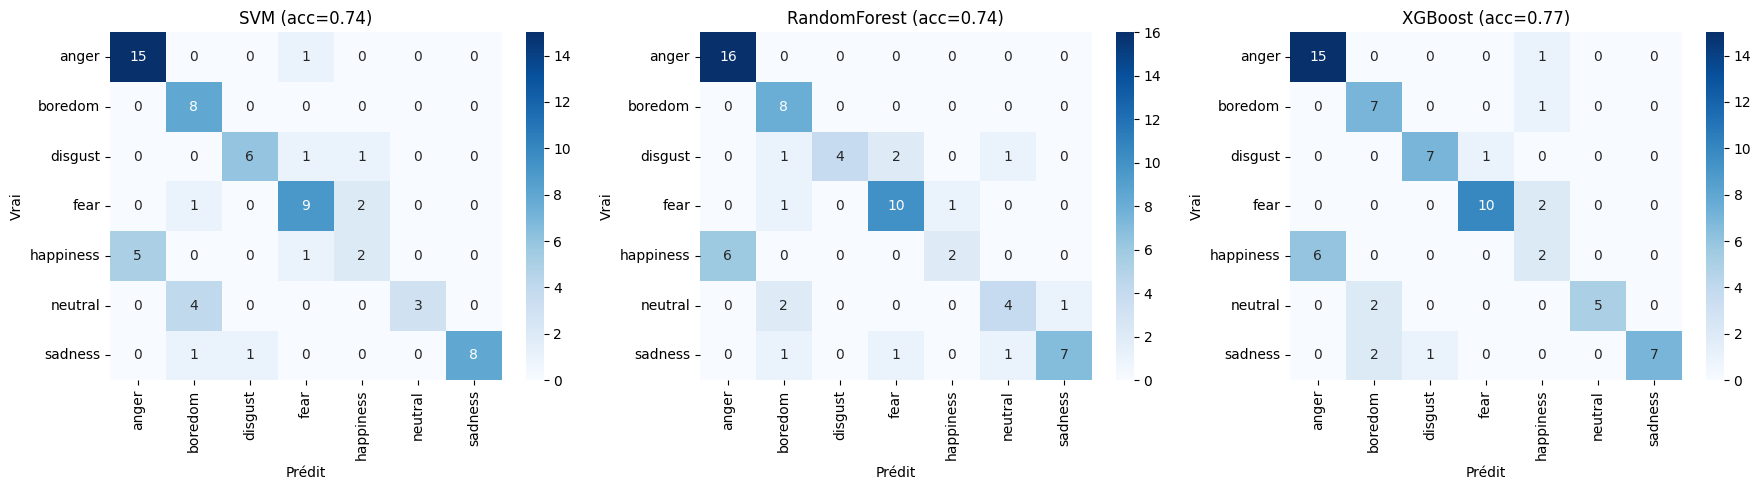

In [ ]:
fig, axes = plt.subplots(1, len(results), figsize=(6*len(results), 5))
if len(results) == 1: axes = [axes]
for ax, (name, res) in zip(axes, results.items()):
    cm = confusion_matrix(y_test, res['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, xticklabels=le.classes_, yticklabels=le.classes_)
    ax.set_title(f'{name} (acc={res["acc"]:.2f})')
    ax.set_xlabel('Prédit')
    ax.set_ylabel('Vrai')
plt.tight_layout()
plt.show()

### 4. Analyse des features importantes

In [ ]:
len(all_features)

44

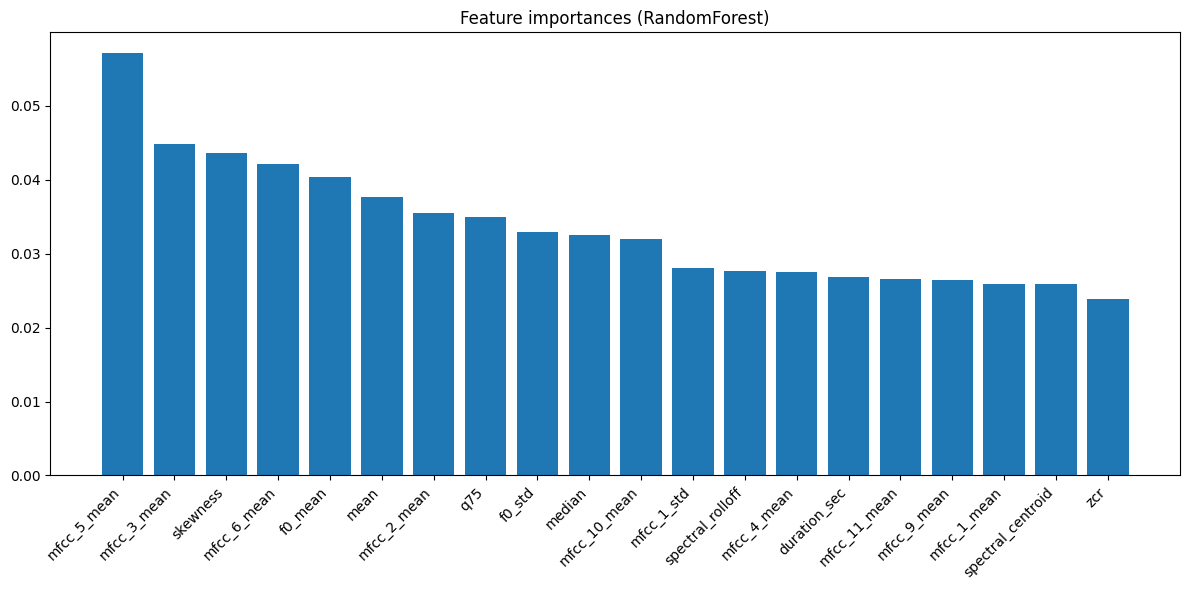

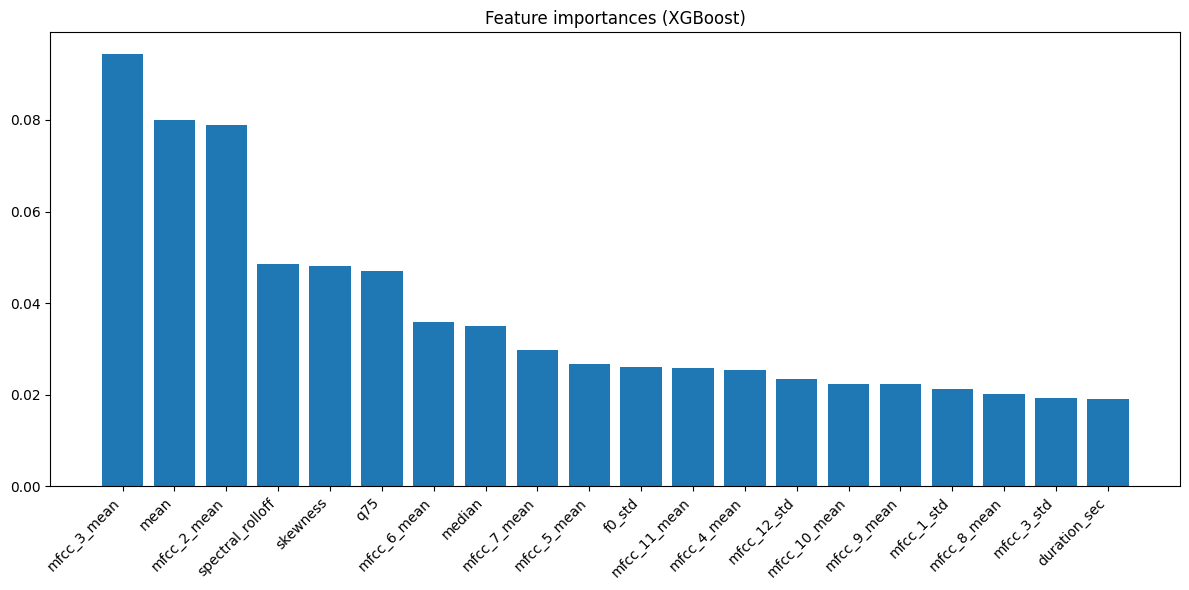

In [ ]:
for name in ['RandomForest', 'XGBoost']:
    if name in results:
        clf = results[name]['model'].best_estimator_
        importances = clf.feature_importances_
        idx = np.argsort(importances)[::-1][:20]
        plt.figure(figsize=(12, 6))
        plt.bar(np.array(all_features)[idx], importances[idx])
        plt.title(f'Feature importances ({name})')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

## <u>Partie IV : SincNet pour la reconnaissance des émotions</u>

In [ ]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

EMODB_ROOT = Path("/kaggle/input/berlin-database-of-emotional-speech-emodb/wav")
EMOTION_MAP = {
    "W": ("anger", 0),
    "L": ("boredom", 1),
    "E": ("disgust", 2),
    "A": ("fear", 3),
    "F": ("happiness", 4),
    "T": ("sadness", 5),
    "N": ("neutral", 6),
}
EMOTION_MAP_INV = {
    0: "anger",
    1: "boredom",
    2: "disgust",
    3: "fear",
    4: "happiness",
    5: "sadness",
    6: "neutral"
}

N_CLASSES = len(EMOTION_MAP)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

In [ ]:
meta = []
for wav in EMODB_ROOT.glob("*.wav"):
    info = parse_filename(wav.name)
    if info:
        meta.append(info)

print(f"Loaded {len(meta)} utterances")

Loaded 535 utterances


## 1. Prétraitement des données pour SincNet

SincNet prend en entrée des chunks audio de taille fixe. Nous avons donc appliqué les étapes suivantes :
- Suppression des silences en début/fin d'enregistrement via un seuil d'énergie.
- Normalisation de l'amplitude pour chaque enregistrement, pour éviter que les variations d'intensité globale n'influencent l'apprentissage.
- Découpage en chunks de 200 ms avec un recouvrement de 10ms.


In [ ]:
def preprocess_audio(filepath, sr=16000, top_db=15, norm='peak'):
    y, _ = librosa.load(filepath, sr=sr)
    y, _ = librosa.effects.trim(y, top_db=top_db)
    if norm == 'peak':
        peak = np.max(np.abs(y))
        if peak > 0 :
            y = y / peak
    elif norm == 'zscore':
        y = (y - np.mean(y)) / np.std(y)
    return y

In [ ]:
class EmoDBDataset(Dataset):
    def __init__(self, items, wav_root, fs=16000,
                 cw_len=200, cw_shift=10,
                 audio_cache=None):
        
        self.items = items
        self.wav_root = wav_root
        self.audio_cache = audio_cache if audio_cache is not None else {}

        self.fs = fs
        self.wlen = int(fs * cw_len / 1000)
        self.wshift = int(fs * cw_shift / 1000)

        self.index = []
        self._prepare_chunks()

    def _load_audio(self, filename):
        if filename not in self.audio_cache:
            signal = preprocess_audio(self.wav_root / filename, norm='peak')
            self.audio_cache[filename] = signal
        return self.audio_cache[filename]

    def _prepare_chunks(self):
        for item in self.items:
            signal = self._load_audio(item["filename"])
            length = len(signal)

            for beg in range(0, length - self.wlen, self.wshift):
                self.index.append((item, beg))

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        item, beg = self.index[idx]
        signal = self._load_audio(item["filename"])

        chunk = signal[beg:beg + self.wlen]
        label = item["emotion_idx"]

        return (
            torch.tensor(chunk, dtype=torch.float32),
            torch.tensor(label, dtype=torch.long)
        )

In [ ]:
SPEAKERS = ['03', '08', '09', '10', '11', '12', '13', '14', '15', '16']
speaker_to_items = defaultdict(list)

for item in meta:
    speaker_to_items[item["speaker_id"]].append(item)

kf = KFold(n_splits=10, shuffle=True, random_state=SEED)
speaker_ids = np.array(SPEAKERS)

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import math

def flip(x, dim):
    xsize = x.size()
    dim = x.dim() + dim if dim < 0 else dim
    x = x.contiguous()
    x = x.view(-1, *xsize[dim:])
    x = x.view(x.size(0), x.size(1), -1)[:, getattr(torch.arange(x.size(1)-1, 
                      -1, -1), ('cpu','cuda')[x.is_cuda])().long(), :]
    return x.view(xsize)


def sinc(band,t_right):
    y_right= torch.sin(2*math.pi*band*t_right)/(2*math.pi*band*t_right)
    y_left= flip(y_right,0)

    y=torch.cat([y_left,Variable(torch.ones(1)).cuda(),y_right])

    return y
    

class SincConv_fast(nn.Module):
    @staticmethod
    def to_mel(hz):
        return 2595 * np.log10(1 + hz / 700)

    @staticmethod
    def to_hz(mel):
        return 700 * (10 ** (mel / 2595) - 1)

    def __init__(self, out_channels, kernel_size, sample_rate=16000, in_channels=1,
                 stride=1, padding=0, dilation=1, bias=False, groups=1, min_low_hz=50, min_band_hz=50):

        super(SincConv_fast,self).__init__()

        if in_channels != 1:
            msg = "SincConv only support one input channel (here, in_channels = {%i})" % (in_channels)
            raise ValueError(msg)

        self.out_channels = out_channels
        self.kernel_size = kernel_size
        
        # Forcing the filters to be odd (i.e, perfectly symmetrics)
        if kernel_size%2==0:
            self.kernel_size=self.kernel_size+1
            
        self.stride = stride
        self.padding = padding
        self.dilation = dilation

        if bias:
            raise ValueError('SincConv does not support bias.')
        if groups > 1:
            raise ValueError('SincConv does not support groups.')

        self.sample_rate = sample_rate
        self.min_low_hz = min_low_hz
        self.min_band_hz = min_band_hz

        # initialize filterbanks such that they are equally spaced in Mel scale
        low_hz = 30
        high_hz = self.sample_rate / 2 - (self.min_low_hz + self.min_band_hz)

        mel = np.linspace(self.to_mel(low_hz),
                          self.to_mel(high_hz),
                          self.out_channels + 1)
        hz = self.to_hz(mel)
        

        # filter lower frequency (out_channels, 1)
        self.low_hz_ = nn.Parameter(torch.Tensor(hz[:-1]).view(-1, 1))

        # filter frequency band (out_channels, 1)
        self.band_hz_ = nn.Parameter(torch.Tensor(np.diff(hz)).view(-1, 1))

        # Hamming window
        #self.window_ = torch.hamming_window(self.kernel_size)
        n_lin=torch.linspace(0, (self.kernel_size/2)-1, steps=int((self.kernel_size/2))) # computing only half of the window
        self.window_=0.54-0.46*torch.cos(2*math.pi*n_lin/self.kernel_size);


        # (1, kernel_size/2)
        n = (self.kernel_size - 1) / 2.0
        self.n_ = 2*math.pi*torch.arange(-n, 0).view(1, -1) / self.sample_rate # Due to symmetry, I only need half of the time axes

    def forward(self, waveforms):

        self.n_ = self.n_.to(waveforms.device)

        self.window_ = self.window_.to(waveforms.device)
        low = self.min_low_hz  + torch.abs(self.low_hz_)
        
        high = torch.clamp(low + self.min_band_hz + torch.abs(self.band_hz_),self.min_low_hz,self.sample_rate/2)
        band=(high-low)[:,0]
        
        f_times_t_low = torch.matmul(low, self.n_)
        f_times_t_high = torch.matmul(high, self.n_)

        band_pass_left=((torch.sin(f_times_t_high)-torch.sin(f_times_t_low))/(self.n_/2))*self.window_ # Equivalent of Eq.4 of the reference paper (SPEAKER RECOGNITION FROM RAW WAVEFORM WITH SINCNET). I just have expanded the sinc and simplified the terms. This way I avoid several useless computations. 
        band_pass_center = 2*band.view(-1,1)
        band_pass_right= torch.flip(band_pass_left,dims=[1])
        
        
        band_pass=torch.cat([band_pass_left,band_pass_center,band_pass_right],dim=1)

        
        band_pass = band_pass / (2*band[:,None])
        

        self.filters = (band_pass).view(
            self.out_channels, 1, self.kernel_size)

        return F.conv1d(waveforms, self.filters, stride=self.stride,
                        padding=self.padding, dilation=self.dilation,
                         bias=None, groups=1)       
        
class sinc_conv(nn.Module):

    def __init__(self, N_filt,Filt_dim,fs):
        super(sinc_conv,self).__init__()

        # Mel Initialization of the filterbanks
        low_freq_mel = 80
        high_freq_mel = (2595 * np.log10(1 + (fs / 2) / 700))  # Convert Hz to Mel
        mel_points = np.linspace(low_freq_mel, high_freq_mel, N_filt)  # Equally spaced in Mel scale
        f_cos = (700 * (10**(mel_points / 2595) - 1)) # Convert Mel to Hz
        b1=np.roll(f_cos,1)
        b2=np.roll(f_cos,-1)
        b1[0]=30
        b2[-1]=(fs/2)-100
                
        self.freq_scale=fs*1.0
        self.filt_b1 = nn.Parameter(torch.from_numpy(b1/self.freq_scale))
        self.filt_band = nn.Parameter(torch.from_numpy((b2-b1)/self.freq_scale))

        
        self.N_filt=N_filt
        self.Filt_dim=Filt_dim
        self.fs=fs
        

    def forward(self, x):
        
        filters=Variable(torch.zeros((self.N_filt,self.Filt_dim))).cuda()
        N=self.Filt_dim
        t_right=Variable(torch.linspace(1, (N-1)/2, steps=int((N-1)/2))/self.fs).cuda()
        
        
        min_freq=50.0
        min_band=50.0
        
        filt_beg_freq=torch.abs(self.filt_b1)+min_freq/self.freq_scale
        filt_end_freq=filt_beg_freq+(torch.abs(self.filt_band)+min_band/self.freq_scale)
       
        n=torch.linspace(0, N, steps=N)

        window=0.54-0.46*torch.cos(2*math.pi*n/N)
        window=Variable(window.float().cuda())

        
        for i in range(self.N_filt):
                        
            low_pass1 = 2*filt_beg_freq[i].float()*sinc(filt_beg_freq[i].float()*self.freq_scale,t_right)
            low_pass2 = 2*filt_end_freq[i].float()*sinc(filt_end_freq[i].float()*self.freq_scale,t_right)
            band_pass=(low_pass2-low_pass1)

            band_pass=band_pass/torch.max(band_pass)

            filters[i,:]=band_pass.cuda()*window

        out=F.conv1d(x, filters.view(self.N_filt,1,self.Filt_dim))
    
        return out   

def act_fun(act_type):

 if act_type=="relu":
    return nn.ReLU()
            
 if act_type=="tanh":
    return nn.Tanh()
            
 if act_type=="sigmoid":
    return nn.Sigmoid()
           
 if act_type=="leaky_relu":
    return nn.LeakyReLU(0.2)
            
 if act_type=="elu":
    return nn.ELU()
                     
 if act_type=="softmax":
    return nn.LogSoftmax(dim=1)
        
 if act_type=="linear":
    return nn.LeakyReLU(1)             
            
class LayerNorm(nn.Module):

    def __init__(self, features, eps=1e-6):
        super(LayerNorm,self).__init__()
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

class MLP(nn.Module):
    def __init__(self, options):
        super(MLP, self).__init__()
        
        self.input_dim=int(options['input_dim'])
        self.fc_lay=options['fc_lay']
        self.fc_drop=options['fc_drop']
        self.fc_use_batchnorm=options['fc_use_batchnorm']
        self.fc_use_laynorm=options['fc_use_laynorm']
        self.fc_use_laynorm_inp=options['fc_use_laynorm_inp']
        self.fc_use_batchnorm_inp=options['fc_use_batchnorm_inp']
        self.fc_act=options['fc_act']
        
       
        self.wx  = nn.ModuleList([])
        self.bn  = nn.ModuleList([])
        self.ln  = nn.ModuleList([])
        self.act = nn.ModuleList([])
        self.drop = nn.ModuleList([])
       

       
        # input layer normalization
        if self.fc_use_laynorm_inp:
           self.ln0=LayerNorm(self.input_dim)
          
        # input batch normalization    
        if self.fc_use_batchnorm_inp:
           self.bn0=nn.BatchNorm1d([self.input_dim],momentum=0.05)
           
           
        self.N_fc_lay=len(self.fc_lay)
             
        current_input=self.input_dim
        
        
        for i in range(self.N_fc_lay):
            
         # dropout
         self.drop.append(nn.Dropout(p=self.fc_drop[i]))
         
         # activation
         self.act.append(act_fun(self.fc_act[i]))
         
         
         add_bias=True
         
         # layer norm initialization
         self.ln.append(LayerNorm(self.fc_lay[i]))
         self.bn.append(nn.BatchNorm1d(self.fc_lay[i],momentum=0.05))
         
         if self.fc_use_laynorm[i] or self.fc_use_batchnorm[i]:
             add_bias=False
         
              
         # Linear operations
         self.wx.append(nn.Linear(current_input, self.fc_lay[i],bias=add_bias))
         
         # weight initialization
         self.wx[i].weight = torch.nn.Parameter(torch.Tensor(self.fc_lay[i],current_input).uniform_(-np.sqrt(0.01/(current_input+self.fc_lay[i])),np.sqrt(0.01/(current_input+self.fc_lay[i]))))
         self.wx[i].bias = torch.nn.Parameter(torch.zeros(self.fc_lay[i]))
         
         current_input=self.fc_lay[i]
         
         
    def forward(self, x):
        
      # Applying Layer/Batch Norm
      if bool(self.fc_use_laynorm_inp):
        x=self.ln0((x))
        
      if bool(self.fc_use_batchnorm_inp):
        x=self.bn0((x))
        
      for i in range(self.N_fc_lay):

        if self.fc_act[i]!='linear':
            
          if self.fc_use_laynorm[i]:
           x = self.drop[i](self.act[i](self.ln[i](self.wx[i](x))))
          
          if self.fc_use_batchnorm[i]:
           x = self.drop[i](self.act[i](self.bn[i](self.wx[i](x))))
          
          if self.fc_use_batchnorm[i]==False and self.fc_use_laynorm[i]==False:
           x = self.drop[i](self.act[i](self.wx[i](x)))
           
        else:
          if self.fc_use_laynorm[i]:
           x = self.drop[i](self.ln[i](self.wx[i](x)))
          
          if self.fc_use_batchnorm[i]:
           x = self.drop[i](self.bn[i](self.wx[i](x)))
          
          if self.fc_use_batchnorm[i]==False and self.fc_use_laynorm[i]==False:
           x = self.drop[i](self.wx[i](x)) 
          
      return x



class SincNet(nn.Module):
    
    def __init__(self,options):
       super(SincNet,self).__init__()
    
       self.cnn_N_filt=options['cnn_N_filt']
       self.cnn_len_filt=options['cnn_len_filt']
       self.cnn_max_pool_len=options['cnn_max_pool_len']
       
       
       self.cnn_act=options['cnn_act']
       self.cnn_drop=options['cnn_drop']
       
       self.cnn_use_laynorm=options['cnn_use_laynorm']
       self.cnn_use_batchnorm=options['cnn_use_batchnorm']
       self.cnn_use_laynorm_inp=options['cnn_use_laynorm_inp']
       self.cnn_use_batchnorm_inp=options['cnn_use_batchnorm_inp']
       
       self.input_dim=int(options['input_dim'])
       
       self.fs=options['fs']
       
       self.N_cnn_lay=len(options['cnn_N_filt'])
       self.conv  = nn.ModuleList([])
       self.bn  = nn.ModuleList([])
       self.ln  = nn.ModuleList([])
       self.act = nn.ModuleList([])
       self.drop = nn.ModuleList([])
       
             
       if self.cnn_use_laynorm_inp:
           self.ln0=LayerNorm(self.input_dim)
           
       if self.cnn_use_batchnorm_inp:
           self.bn0=nn.BatchNorm1d([self.input_dim],momentum=0.05)
           
       current_input=self.input_dim 
       
       for i in range(self.N_cnn_lay):
         
         N_filt=int(self.cnn_N_filt[i])
         len_filt=int(self.cnn_len_filt[i])
         
         # dropout
         self.drop.append(nn.Dropout(p=self.cnn_drop[i]))
         
         # activation
         self.act.append(act_fun(self.cnn_act[i]))
                    
         # layer norm initialization         
         self.ln.append(LayerNorm([N_filt,int((current_input-self.cnn_len_filt[i]+1)/self.cnn_max_pool_len[i])]))

         self.bn.append(nn.BatchNorm1d(N_filt,int((current_input-self.cnn_len_filt[i]+1)/self.cnn_max_pool_len[i]),momentum=0.05))
            

         if i==0:
          self.conv.append(SincConv_fast(self.cnn_N_filt[0],self.cnn_len_filt[0],self.fs))
              
         else:
          self.conv.append(nn.Conv1d(self.cnn_N_filt[i-1], self.cnn_N_filt[i], self.cnn_len_filt[i]))
          
         current_input=int((current_input-self.cnn_len_filt[i]+1)/self.cnn_max_pool_len[i])

         
       self.out_dim=current_input*N_filt



    def forward(self, x):
       batch=x.shape[0]
       seq_len=x.shape[1]
       
       if bool(self.cnn_use_laynorm_inp):
        x=self.ln0((x))
        
       if bool(self.cnn_use_batchnorm_inp):
        x=self.bn0((x))
        
       x=x.view(batch,1,seq_len)

       
       for i in range(self.N_cnn_lay):
           
         if self.cnn_use_laynorm[i]:
          if i==0:
           x = self.drop[i](self.act[i](self.ln[i](F.max_pool1d(torch.abs(self.conv[i](x)), self.cnn_max_pool_len[i]))))  
          else:
           x = self.drop[i](self.act[i](self.ln[i](F.max_pool1d(self.conv[i](x), self.cnn_max_pool_len[i]))))   
          
         if self.cnn_use_batchnorm[i]:
          x = self.drop[i](self.act[i](self.bn[i](F.max_pool1d(self.conv[i](x), self.cnn_max_pool_len[i]))))

         if self.cnn_use_batchnorm[i]==False and self.cnn_use_laynorm[i]==False:
          x = self.drop[i](self.act[i](F.max_pool1d(self.conv[i](x), self.cnn_max_pool_len[i])))

       
       x = x.view(batch,-1)

       return x

In [ ]:
def build_model():
    cnn_options = {
        "cnn_N_filt": [80, 60, 60],
        "cnn_len_filt": [251, 5, 5],
        "cnn_max_pool_len": [3, 3, 3],
        "cnn_act": ["relu", "relu", "relu"],
        "cnn_drop": [0.0, 0.0, 0.0],
        "cnn_use_laynorm": [True, True, True],
        "cnn_use_batchnorm": [False, False, False],
        "cnn_use_laynorm_inp": True,
        "cnn_use_batchnorm_inp": False,
        "input_dim": int(16000 * 0.2),
        "fs": 16000
    }

    dnn_options = {
        "input_dim": None,
        "fc_lay": [2048, 2048],
        "fc_drop": [0.5, 0.5],
        "fc_use_laynorm": [True, True],
        "fc_use_batchnorm": [False, False],
        "fc_use_laynorm_inp": False,
        "fc_use_batchnorm_inp": False,
        "fc_act": ["relu", "relu"]
    }

    cnn = SincNet(cnn_options)
    dnn_options["input_dim"] = cnn.out_dim
    dnn = MLP(dnn_options)
    classifier = nn.Linear(dnn_options["fc_lay"][-1], N_CLASSES)

    model = nn.Sequential(cnn, dnn, classifier)
    return model.to(device)

In [ ]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)
    return correct / total


def eval_epoch(model, loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)

    return correct / total

In [ ]:
audio_cache = {}
def eval_utterance_level(model, items, wav_root,
                         fs=16000, cw_len=200, cw_shift=10,
                         batch_size=128,
                         return_preds=False):
    """
    Returns utterance-level accuracy
    Optionally returns y_true, y_pred
    """
    model.eval()

    wlen = int(fs * cw_len / 1000)
    wshift = int(fs * cw_shift / 1000)

    correct = 0
    total = 0

    y_true, y_pred = [], []

    with torch.no_grad():
        for item in items:
            fname = item["filename"]

            if fname not in audio_cache:
                wav_path = os.path.join(wav_root, fname)
                signal, _ = sf.read(wav_path)
                audio_cache[fname] = signal
            else:
                signal = audio_cache[fname]

            chunks = []
            for beg in range(0, len(signal) - wlen, wshift):
                chunks.append(signal[beg:beg + wlen])

            if len(chunks) == 0:
                continue

            chunks = torch.tensor(
                np.stack(chunks),
                dtype=torch.float32,
                device=device
            )

            probs_sum = torch.zeros(N_CLASSES, device=device)

            for i in range(0, len(chunks), batch_size):
                out = model(chunks[i:i + batch_size])
                probs = torch.softmax(out, dim=1)
                probs_sum += probs.sum(dim=0)

            pred = probs_sum.argmax().item()
            label = item["emotion_idx"]

            y_true.append(label)
            y_pred.append(pred)

            correct += int(pred == label)
            total += 1

    acc = correct / total if total > 0 else 0.0

    if return_preds:
        return acc, y_true, y_pred
    else:
        return acc

In [ ]:
VAL_SPEAKER_PER_TEST = {
    "03": "08",  # M → F
    "08": "03",  # F → M
    "09": "10",  # F → M
    "10": "09",  # M → F
    "11": "13",  # M → F
    "12": "14",  # M → F
    "13": "11",  # F → M
    "14": "12",  # F → M
    "15": "16",  # M → F
    "16": "15",  # F → M
}

### 2. Entraînement : Validation Croisée par Locuteur (Speaker k-fold Cross-Validation)

Pour évaluer la performance de notre modèle SincNet, nous utilisons une validation croisée stricte basée sur l'identité des locuteurs, pour les raisons suivantes : 
* **Éviter le Data Leakage :** Si un même locuteur se retrouve à la fois dans le jeu d'entraînement et dans le jeu de test, le réseau de neurones risque d'apprendre à reconnaître l'identité de la personne (timbre, accent) plutôt que l'émotion elle-même. Cela gonflerait artificiellement les performances.
* **Garantir la Généralisation :** En testant systématiquement sur des locuteurs "inconnus" du modèle, nous nous assurons que l'architecture apprend des caractéristiques émotionnelles universelles et non des spécificités individuelles.


=== Fold 1 ===
Train speakers: [np.str_('03'), np.str_('08'), np.str_('09'), np.str_('10'), np.str_('11'), np.str_('13'), np.str_('15'), np.str_('16')]
Val speakers:   ['12']
Test speakers:  ['14']
Epoch 01 | train_acc=0.358 | val_acc=0.629 | val_f1=0.484
Epoch 02 | train_acc=0.490 | val_acc=0.514 | val_f1=0.320
Epoch 03 | train_acc=0.560 | val_acc=0.657 | val_f1=0.417
Epoch 04 | train_acc=0.613 | val_acc=0.714 | val_f1=0.534
Epoch 05 | train_acc=0.658 | val_acc=0.629 | val_f1=0.429
Epoch 06 | train_acc=0.691 | val_acc=0.800 | val_f1=0.663
Epoch 07 | train_acc=0.730 | val_acc=0.657 | val_f1=0.463
Epoch 08 | train_acc=0.765 | val_acc=0.657 | val_f1=0.529
Epoch 09 | train_acc=0.803 | val_acc=0.686 | val_f1=0.470
Epoch 10 | train_acc=0.839 | val_acc=0.629 | val_f1=0.414
Epoch 11 | train_acc=0.868 | val_acc=0.771 | val_f1=0.642
Epoch 12 | train_acc=0.890 | val_acc=0.743 | val_f1=0.531
Epoch 13 | train_acc=0.910 | val_acc=0.657 | val_f1=0.451
Epoch 14 | train_acc=0.923 | val_acc=0.657 | va

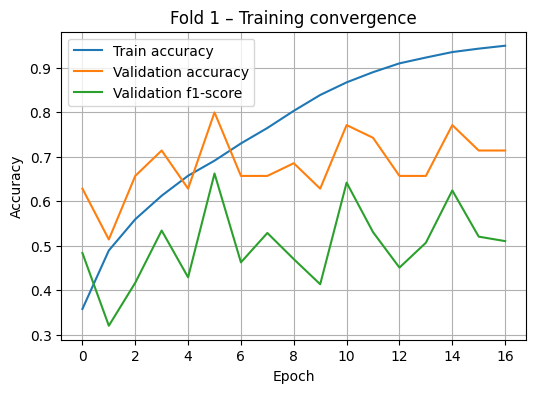

========= LAST MODEL PERF =========
Fold 1 TEST utterance accuracy: 0.768

Classification report:
              precision    recall  f1-score   support

     neutral      0.640     1.000     0.780        16
       anger      0.875     0.875     0.875         8
        fear      1.000     1.000     1.000         8
   happiness      1.000     0.333     0.500        12
     sadness      0.500     0.125     0.200         8
     boredom      1.000     1.000     1.000        10
     disgust      0.583     1.000     0.737         7

    accuracy                          0.768        69
   macro avg      0.800     0.762     0.727        69
weighted avg      0.802     0.768     0.728        69



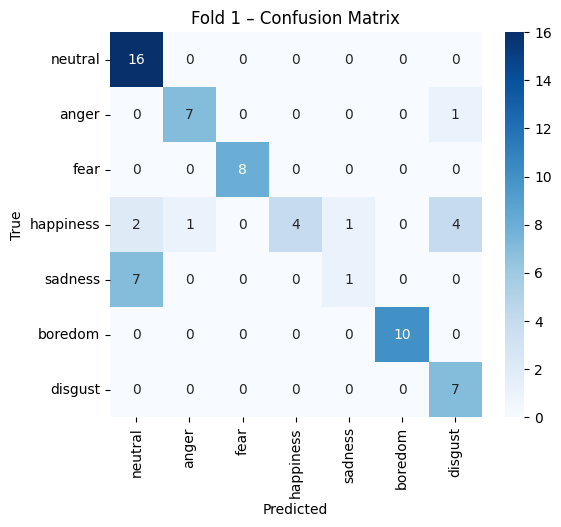

========= BEST MODEL PERF =========
Fold 1 TEST utterance accuracy: 0.899

Classification report:
              precision    recall  f1-score   support

     neutral      0.882     0.938     0.909        16
       anger      1.000     0.875     0.933         8
        fear      1.000     1.000     1.000         8
   happiness      1.000     0.750     0.857        12
     sadness      0.600     0.750     0.667         8
     boredom      1.000     1.000     1.000        10
     disgust      0.875     1.000     0.933         7

    accuracy                          0.899        69
   macro avg      0.908     0.902     0.900        69
weighted avg      0.914     0.899     0.901        69



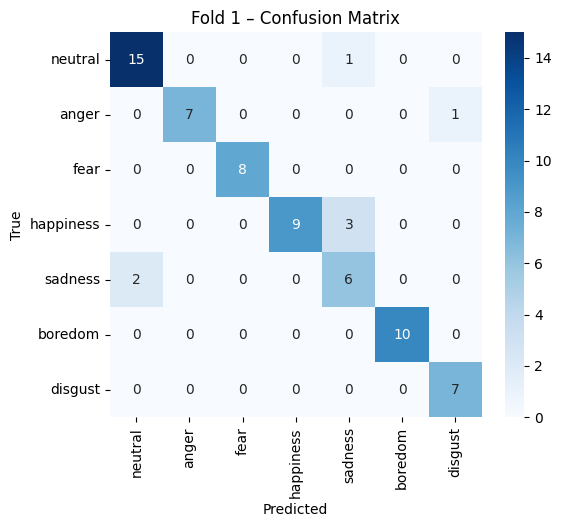


=== Fold 2 ===
Train speakers: [np.str_('03'), np.str_('08'), np.str_('11'), np.str_('12'), np.str_('13'), np.str_('14'), np.str_('15'), np.str_('16')]
Val speakers:   ['10']
Test speakers:  ['09']
Epoch 01 | train_acc=0.363 | val_acc=0.474 | val_f1=0.354
Epoch 02 | train_acc=0.487 | val_acc=0.605 | val_f1=0.440
Epoch 03 | train_acc=0.558 | val_acc=0.632 | val_f1=0.400
Epoch 04 | train_acc=0.607 | val_acc=0.737 | val_f1=0.606
Epoch 05 | train_acc=0.650 | val_acc=0.711 | val_f1=0.574
Epoch 06 | train_acc=0.685 | val_acc=0.684 | val_f1=0.560
Epoch 07 | train_acc=0.718 | val_acc=0.763 | val_f1=0.671
Epoch 08 | train_acc=0.753 | val_acc=0.711 | val_f1=0.559
Epoch 09 | train_acc=0.788 | val_acc=0.842 | val_f1=0.770
Epoch 10 | train_acc=0.823 | val_acc=0.684 | val_f1=0.546
Epoch 11 | train_acc=0.852 | val_acc=0.789 | val_f1=0.694
Epoch 12 | train_acc=0.878 | val_acc=0.763 | val_f1=0.679
Epoch 13 | train_acc=0.896 | val_acc=0.737 | val_f1=0.597
Epoch 14 | train_acc=0.911 | val_acc=0.737 | va

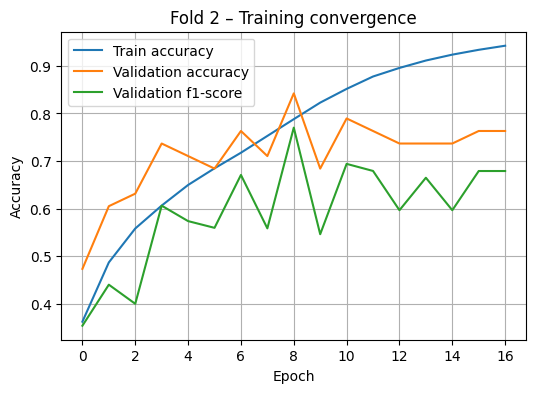

========= LAST MODEL PERF =========
Fold 2 TEST utterance accuracy: 0.791

Classification report:
              precision    recall  f1-score   support

     neutral      0.750     0.923     0.828        13
       anger      0.667     1.000     0.800         4
        fear      1.000     0.500     0.667         8
   happiness      0.500     1.000     0.667         1
     sadness      0.500     0.500     0.500         4
     boredom      1.000     0.750     0.857         4
     disgust      1.000     0.889     0.941         9

    accuracy                          0.791        43
   macro avg      0.774     0.795     0.751        43
weighted avg      0.835     0.791     0.787        43



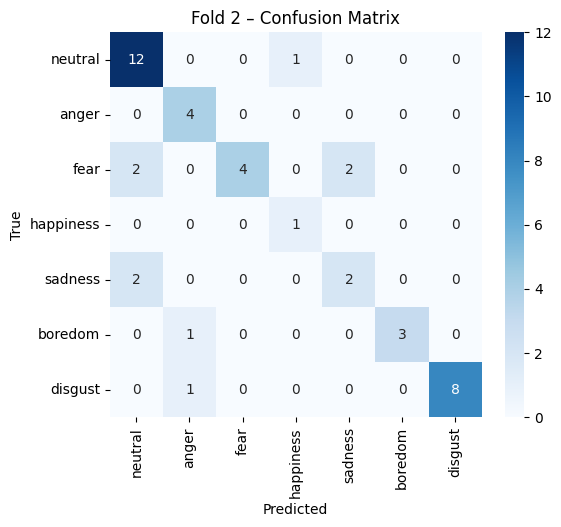

========= BEST MODEL PERF =========
Fold 2 TEST utterance accuracy: 0.628

Classification report:
              precision    recall  f1-score   support

     neutral      0.714     0.769     0.741        13
       anger      0.444     1.000     0.615         4
        fear      1.000     0.250     0.400         8
   happiness      0.500     1.000     0.667         1
     sadness      0.250     0.500     0.333         4
     boredom      1.000     0.250     0.400         4
     disgust      1.000     0.778     0.875         9

    accuracy                          0.628        43
   macro avg      0.701     0.650     0.576        43
weighted avg      0.781     0.628     0.622        43



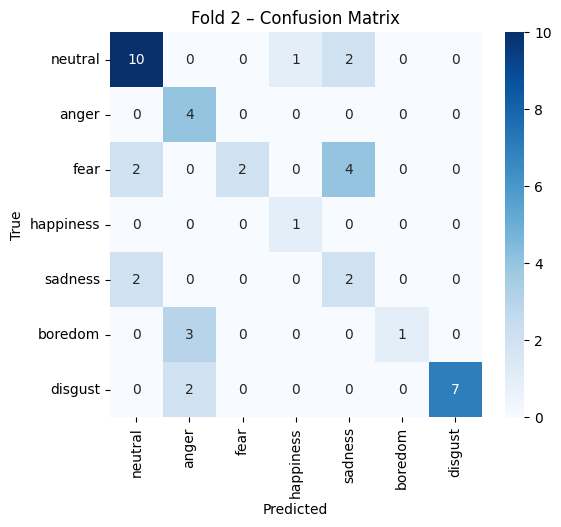


=== Fold 3 ===
Train speakers: [np.str_('03'), np.str_('08'), np.str_('09'), np.str_('10'), np.str_('11'), np.str_('12'), np.str_('13'), np.str_('14')]
Val speakers:   ['15']
Test speakers:  ['16']
Epoch 01 | train_acc=0.382 | val_acc=0.375 | val_f1=0.217
Epoch 02 | train_acc=0.495 | val_acc=0.536 | val_f1=0.380
Epoch 03 | train_acc=0.547 | val_acc=0.429 | val_f1=0.276
Epoch 04 | train_acc=0.600 | val_acc=0.482 | val_f1=0.326
Epoch 05 | train_acc=0.644 | val_acc=0.518 | val_f1=0.419
Epoch 06 | train_acc=0.684 | val_acc=0.625 | val_f1=0.523
Epoch 07 | train_acc=0.720 | val_acc=0.571 | val_f1=0.486
Epoch 08 | train_acc=0.756 | val_acc=0.571 | val_f1=0.430
Epoch 09 | train_acc=0.789 | val_acc=0.625 | val_f1=0.483
Epoch 10 | train_acc=0.824 | val_acc=0.661 | val_f1=0.589
Epoch 11 | train_acc=0.857 | val_acc=0.661 | val_f1=0.572
Epoch 12 | train_acc=0.881 | val_acc=0.679 | val_f1=0.591
Epoch 13 | train_acc=0.901 | val_acc=0.500 | val_f1=0.444
Epoch 14 | train_acc=0.917 | val_acc=0.696 | va

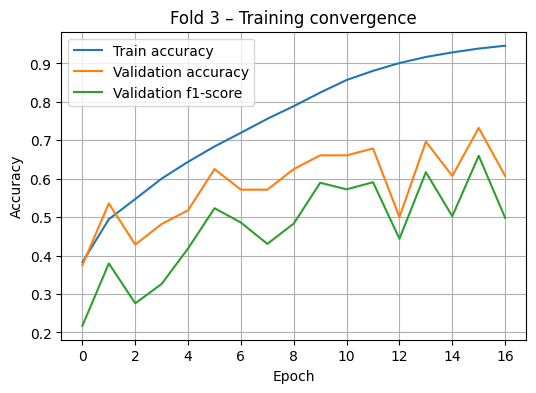

========= LAST MODEL PERF =========
Fold 3 TEST utterance accuracy: 0.690

Classification report:
              precision    recall  f1-score   support

     neutral      0.438     1.000     0.609        14
       anger      1.000     0.786     0.880        14
        fear      0.900     0.818     0.857        11
   happiness      0.500     0.143     0.222         7
     sadness      0.333     0.091     0.143        11
     boredom      1.000     1.000     1.000         9
     disgust      1.000     0.800     0.889         5

    accuracy                          0.690        71
   macro avg      0.739     0.663     0.657        71
weighted avg      0.721     0.690     0.660        71



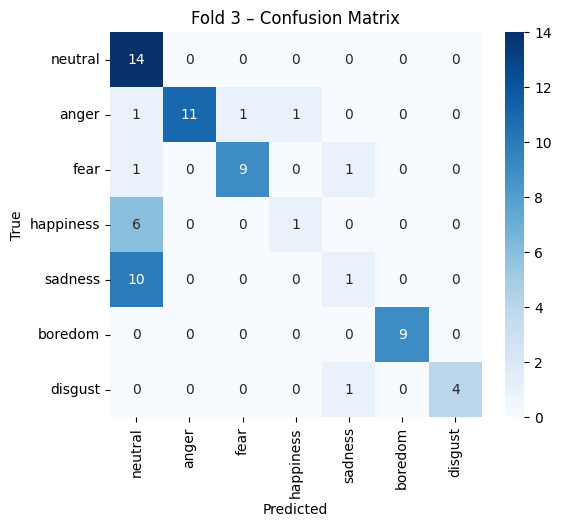

========= BEST MODEL PERF =========
Fold 3 TEST utterance accuracy: 0.648

Classification report:
              precision    recall  f1-score   support

     neutral      0.467     1.000     0.636        14
       anger      1.000     0.714     0.833        14
        fear      0.733     1.000     0.846        11
   happiness      0.000     0.000     0.000         7
     sadness      0.250     0.091     0.133        11
     boredom      1.000     0.778     0.875         9
     disgust      1.000     0.600     0.750         5

    accuracy                          0.648        71
   macro avg      0.636     0.598     0.582        71
weighted avg      0.639     0.648     0.605        71



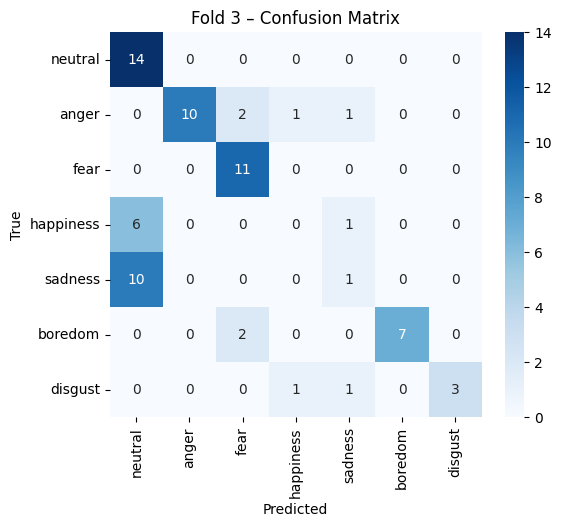


=== Fold 4 ===
Train speakers: [np.str_('09'), np.str_('10'), np.str_('11'), np.str_('12'), np.str_('13'), np.str_('14'), np.str_('15'), np.str_('16')]
Val speakers:   ['03']
Test speakers:  ['08']
Epoch 01 | train_acc=0.347 | val_acc=0.531 | val_f1=0.322
Epoch 02 | train_acc=0.485 | val_acc=0.490 | val_f1=0.360
Epoch 03 | train_acc=0.564 | val_acc=0.755 | val_f1=0.622
Epoch 04 | train_acc=0.618 | val_acc=0.694 | val_f1=0.610
Epoch 05 | train_acc=0.660 | val_acc=0.735 | val_f1=0.577
Epoch 06 | train_acc=0.703 | val_acc=0.755 | val_f1=0.630
Epoch 07 | train_acc=0.738 | val_acc=0.796 | val_f1=0.665
Epoch 08 | train_acc=0.773 | val_acc=0.633 | val_f1=0.470
Epoch 09 | train_acc=0.813 | val_acc=0.735 | val_f1=0.626
Epoch 10 | train_acc=0.847 | val_acc=0.796 | val_f1=0.708
Epoch 11 | train_acc=0.874 | val_acc=0.796 | val_f1=0.671
Epoch 12 | train_acc=0.897 | val_acc=0.714 | val_f1=0.576
Epoch 13 | train_acc=0.914 | val_acc=0.816 | val_f1=0.684
Epoch 14 | train_acc=0.928 | val_acc=0.857 | va

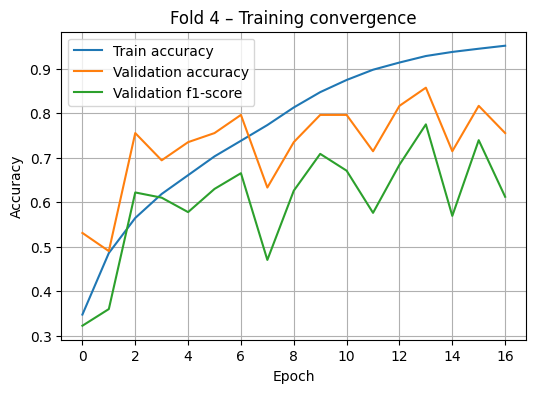

========= LAST MODEL PERF =========
Fold 4 TEST utterance accuracy: 0.707

Classification report:
              precision    recall  f1-score   support

     neutral      0.857     1.000     0.923        12
       anger      1.000     0.200     0.333        10
        fear      0.000     0.000     0.000         0
   happiness      0.500     0.500     0.500         6
     sadness      0.875     0.636     0.737        11
     boredom      1.000     1.000     1.000         9
     disgust      0.571     0.800     0.667        10

    accuracy                          0.707        58
   macro avg      0.686     0.591     0.594        58
weighted avg      0.821     0.707     0.710        58



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


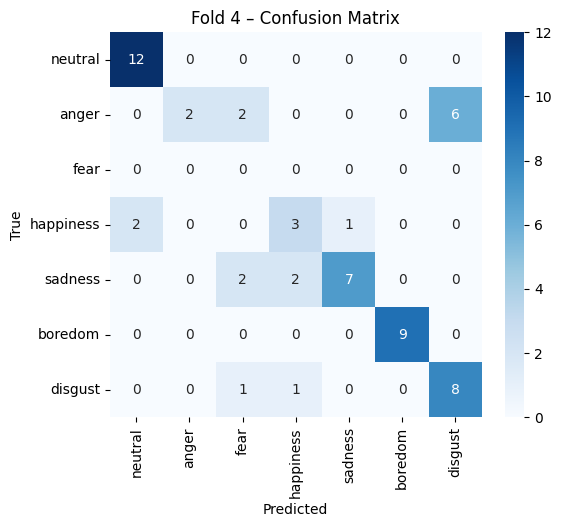

========= BEST MODEL PERF =========
Fold 4 TEST utterance accuracy: 0.741

Classification report:
              precision    recall  f1-score   support

     neutral      0.857     1.000     0.923        12
       anger      1.000     0.500     0.667        10
        fear      0.000     0.000     0.000         0
   happiness      1.000     0.500     0.667         6
     sadness      0.875     0.636     0.737        11
     boredom      1.000     1.000     1.000         9
     disgust      0.700     0.700     0.700        10

    accuracy                          0.741        58
   macro avg      0.776     0.619     0.670        58
weighted avg      0.895     0.741     0.790        58



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


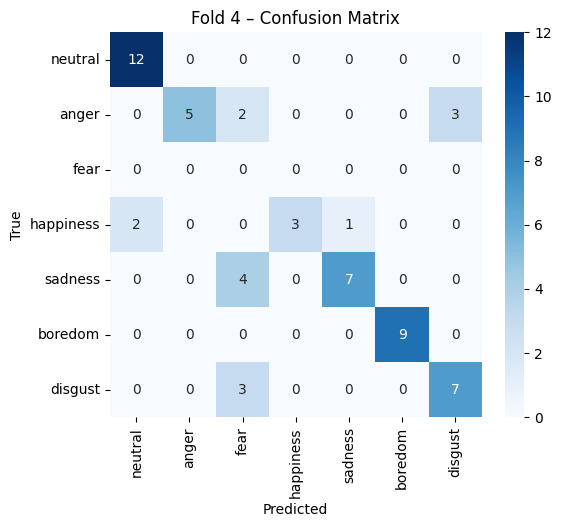


=== Fold 5 ===
Train speakers: [np.str_('09'), np.str_('10'), np.str_('11'), np.str_('12'), np.str_('13'), np.str_('14'), np.str_('15'), np.str_('16')]
Val speakers:   ['08']
Test speakers:  ['03']
Epoch 01 | train_acc=0.347 | val_acc=0.500 | val_f1=0.363
Epoch 02 | train_acc=0.482 | val_acc=0.397 | val_f1=0.279
Epoch 03 | train_acc=0.557 | val_acc=0.672 | val_f1=0.586
Epoch 04 | train_acc=0.612 | val_acc=0.655 | val_f1=0.575
Epoch 05 | train_acc=0.658 | val_acc=0.759 | val_f1=0.635
Epoch 06 | train_acc=0.698 | val_acc=0.690 | val_f1=0.557
Epoch 07 | train_acc=0.737 | val_acc=0.707 | val_f1=0.574
Epoch 08 | train_acc=0.781 | val_acc=0.828 | val_f1=0.745
Epoch 09 | train_acc=0.819 | val_acc=0.690 | val_f1=0.616
Epoch 10 | train_acc=0.854 | val_acc=0.707 | val_f1=0.641
Epoch 11 | train_acc=0.880 | val_acc=0.655 | val_f1=0.611
Epoch 12 | train_acc=0.899 | val_acc=0.638 | val_f1=0.515
Epoch 13 | train_acc=0.915 | val_acc=0.500 | val_f1=0.444
Epoch 14 | train_acc=0.928 | val_acc=0.759 | va

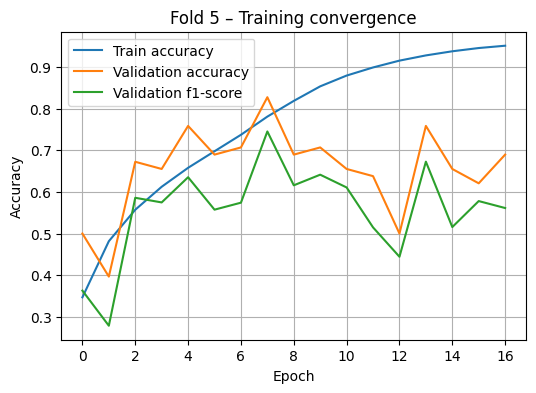

========= LAST MODEL PERF =========
Fold 5 TEST utterance accuracy: 0.796

Classification report:
              precision    recall  f1-score   support

     neutral      0.824     1.000     0.903        14
       anger      1.000     0.200     0.333         5
        fear      0.333     1.000     0.500         1
   happiness      1.000     0.750     0.857         4
     sadness      1.000     0.429     0.600         7
     boredom      1.000     0.857     0.923         7
     disgust      0.688     1.000     0.815        11

    accuracy                          0.796        49
   macro avg      0.835     0.748     0.705        49
weighted avg      0.866     0.796     0.773        49



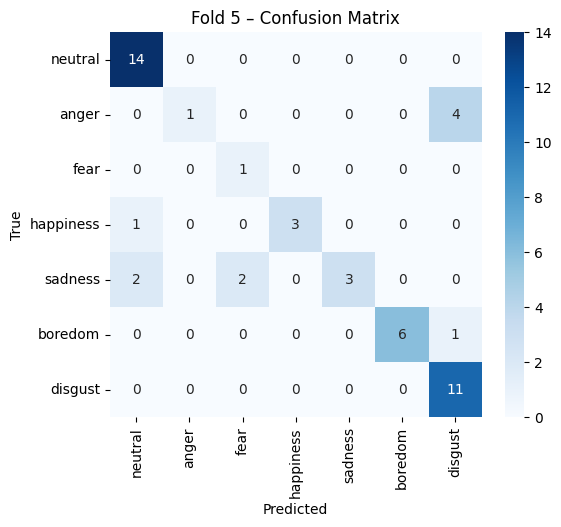

========= BEST MODEL PERF =========
Fold 5 TEST utterance accuracy: 0.714

Classification report:
              precision    recall  f1-score   support

     neutral      0.824     1.000     0.903        14
       anger      0.455     1.000     0.625         5
        fear      0.000     0.000     0.000         1
   happiness      0.750     0.750     0.750         4
     sadness      0.000     0.000     0.000         7
     boredom      1.000     0.286     0.444         7
     disgust      1.000     1.000     1.000        11

    accuracy                          0.714        49
   macro avg      0.575     0.577     0.532        49
weighted avg      0.710     0.714     0.671        49



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


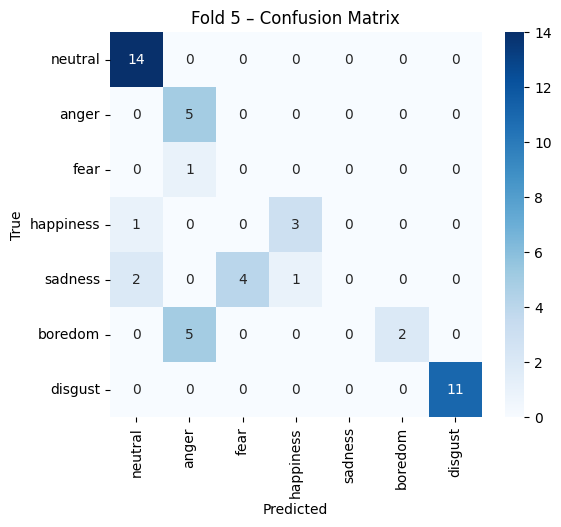


=== Fold 6 ===
Train speakers: [np.str_('03'), np.str_('08'), np.str_('09'), np.str_('10'), np.str_('11'), np.str_('12'), np.str_('13'), np.str_('14')]
Val speakers:   ['16']
Test speakers:  ['15']
Epoch 01 | train_acc=0.381 | val_acc=0.437 | val_f1=0.329
Epoch 02 | train_acc=0.496 | val_acc=0.451 | val_f1=0.310
Epoch 03 | train_acc=0.563 | val_acc=0.563 | val_f1=0.529
Epoch 04 | train_acc=0.617 | val_acc=0.408 | val_f1=0.275
Epoch 05 | train_acc=0.658 | val_acc=0.451 | val_f1=0.315
Epoch 06 | train_acc=0.698 | val_acc=0.451 | val_f1=0.295
Epoch 07 | train_acc=0.734 | val_acc=0.606 | val_f1=0.468
Epoch 08 | train_acc=0.769 | val_acc=0.535 | val_f1=0.416
Epoch 09 | train_acc=0.807 | val_acc=0.521 | val_f1=0.453
Epoch 10 | train_acc=0.842 | val_acc=0.577 | val_f1=0.476
Epoch 11 | train_acc=0.869 | val_acc=0.549 | val_f1=0.422
Epoch 12 | train_acc=0.893 | val_acc=0.549 | val_f1=0.441
Epoch 13 | train_acc=0.909 | val_acc=0.521 | val_f1=0.421
Epoch 14 | train_acc=0.924 | val_acc=0.634 | va

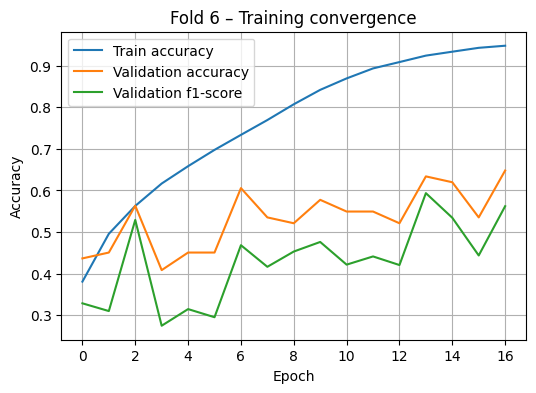

========= LAST MODEL PERF =========
Fold 6 TEST utterance accuracy: 0.589

Classification report:
              precision    recall  f1-score   support

     neutral      0.619     1.000     0.765        13
       anger      0.000     0.000     0.000         9
        fear      1.000     0.800     0.889         5
   happiness      0.800     0.500     0.615         8
     sadness      1.000     0.167     0.286         6
     boredom      0.222     1.000     0.364         4
     disgust      1.000     0.636     0.778        11

    accuracy                          0.589        56
   macro avg      0.663     0.586     0.528        56
weighted avg      0.667     0.589     0.554        56



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


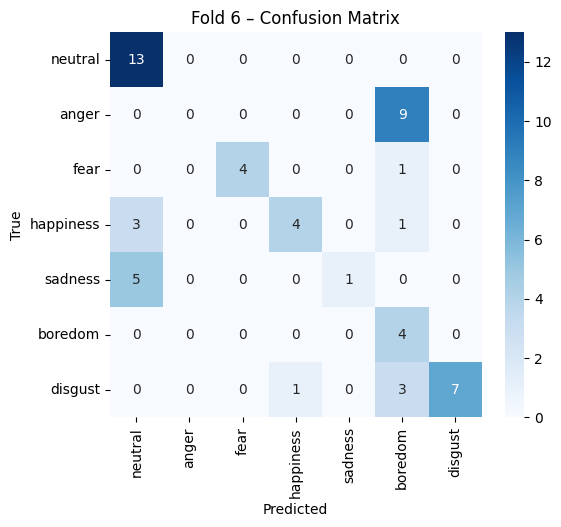

========= BEST MODEL PERF =========
Fold 6 TEST utterance accuracy: 0.661

Classification report:
              precision    recall  f1-score   support

     neutral      0.619     1.000     0.765        13
       anger      1.000     0.333     0.500         9
        fear      1.000     0.400     0.571         5
   happiness      1.000     0.375     0.545         8
     sadness      0.333     0.167     0.222         6
     boredom      0.364     1.000     0.533         4
     disgust      0.846     1.000     0.917        11

    accuracy                          0.661        56
   macro avg      0.737     0.611     0.579        56
weighted avg      0.764     0.661     0.629        56



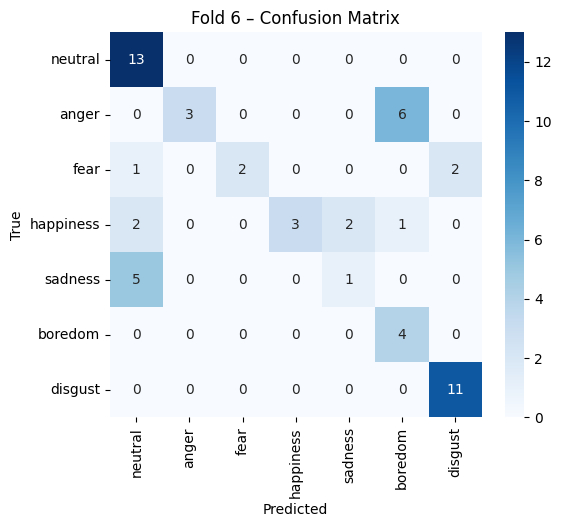


=== Fold 7 ===
Train speakers: [np.str_('03'), np.str_('08'), np.str_('09'), np.str_('10'), np.str_('12'), np.str_('14'), np.str_('15'), np.str_('16')]
Val speakers:   ['13']
Test speakers:  ['11']
Epoch 01 | train_acc=0.383 | val_acc=0.393 | val_f1=0.238
Epoch 02 | train_acc=0.510 | val_acc=0.426 | val_f1=0.412
Epoch 03 | train_acc=0.571 | val_acc=0.393 | val_f1=0.354
Epoch 04 | train_acc=0.617 | val_acc=0.508 | val_f1=0.442
Epoch 05 | train_acc=0.658 | val_acc=0.787 | val_f1=0.795
Epoch 06 | train_acc=0.693 | val_acc=0.705 | val_f1=0.665
Epoch 07 | train_acc=0.728 | val_acc=0.574 | val_f1=0.561
Epoch 08 | train_acc=0.762 | val_acc=0.623 | val_f1=0.604
Epoch 09 | train_acc=0.797 | val_acc=0.820 | val_f1=0.810
Epoch 10 | train_acc=0.833 | val_acc=0.787 | val_f1=0.800
Epoch 11 | train_acc=0.862 | val_acc=0.820 | val_f1=0.812
Epoch 12 | train_acc=0.887 | val_acc=0.738 | val_f1=0.739
Epoch 13 | train_acc=0.904 | val_acc=0.672 | val_f1=0.671
Epoch 14 | train_acc=0.918 | val_acc=0.754 | va

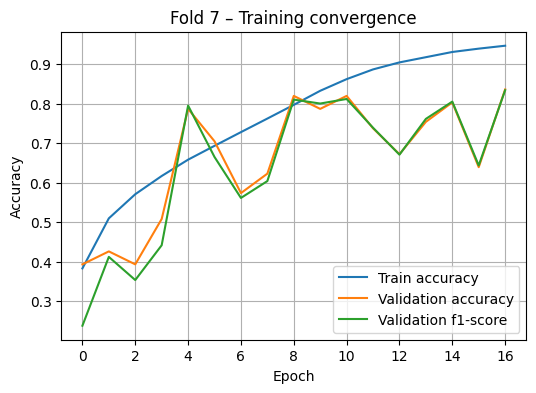

========= LAST MODEL PERF =========
Fold 7 TEST utterance accuracy: 0.618

Classification report:
              precision    recall  f1-score   support

     neutral      0.588     0.909     0.714        11
       anger      1.000     0.375     0.545         8
        fear      1.000     0.500     0.667         2
   happiness      1.000     0.400     0.571        10
     sadness      0.000     0.000     0.000         8
     boredom      0.538     1.000     0.700         7
     disgust      0.529     1.000     0.692         9

    accuracy                          0.618        55
   macro avg      0.665     0.598     0.556        55
weighted avg      0.636     0.618     0.553        55



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


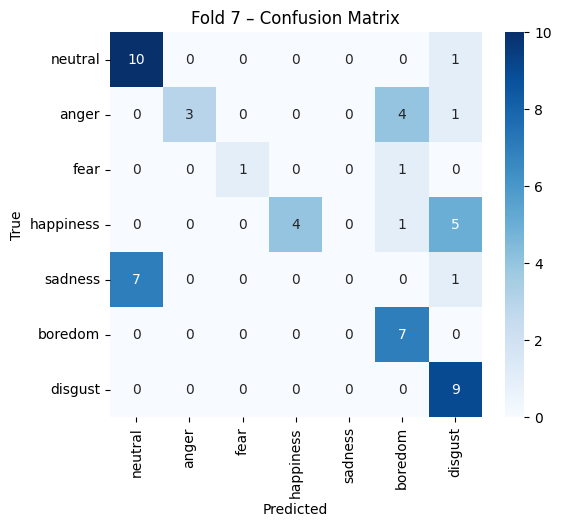

========= BEST MODEL PERF =========
Fold 7 TEST utterance accuracy: 0.618

Classification report:
              precision    recall  f1-score   support

     neutral      0.588     0.909     0.714        11
       anger      1.000     0.375     0.545         8
        fear      1.000     0.500     0.667         2
   happiness      1.000     0.400     0.571        10
     sadness      0.000     0.000     0.000         8
     boredom      0.538     1.000     0.700         7
     disgust      0.529     1.000     0.692         9

    accuracy                          0.618        55
   macro avg      0.665     0.598     0.556        55
weighted avg      0.636     0.618     0.553        55



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


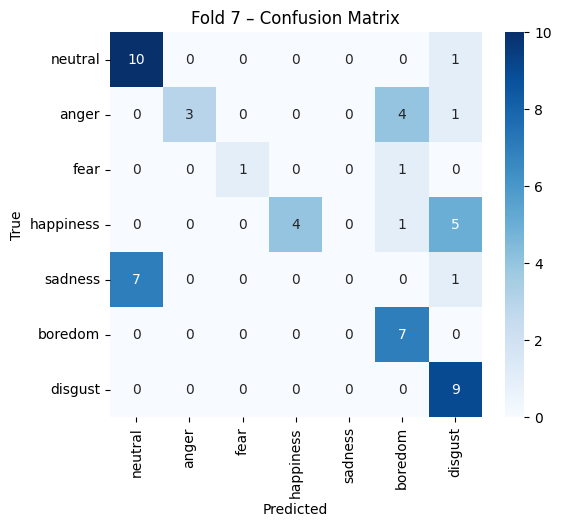


=== Fold 8 ===
Train speakers: [np.str_('03'), np.str_('08'), np.str_('09'), np.str_('10'), np.str_('11'), np.str_('13'), np.str_('15'), np.str_('16')]
Val speakers:   ['14']
Test speakers:  ['12']
Epoch 01 | train_acc=0.368 | val_acc=0.580 | val_f1=0.498
Epoch 02 | train_acc=0.491 | val_acc=0.623 | val_f1=0.486
Epoch 03 | train_acc=0.561 | val_acc=0.768 | val_f1=0.726
Epoch 04 | train_acc=0.615 | val_acc=0.725 | val_f1=0.653
Epoch 05 | train_acc=0.652 | val_acc=0.754 | val_f1=0.672
Epoch 06 | train_acc=0.692 | val_acc=0.768 | val_f1=0.690
Epoch 07 | train_acc=0.727 | val_acc=0.754 | val_f1=0.714
Epoch 08 | train_acc=0.763 | val_acc=0.739 | val_f1=0.711
Epoch 09 | train_acc=0.796 | val_acc=0.725 | val_f1=0.695
Epoch 10 | train_acc=0.832 | val_acc=0.913 | val_f1=0.906
Epoch 11 | train_acc=0.861 | val_acc=0.754 | val_f1=0.717
Epoch 12 | train_acc=0.884 | val_acc=0.870 | val_f1=0.867
Epoch 13 | train_acc=0.905 | val_acc=0.855 | val_f1=0.848
Epoch 14 | train_acc=0.920 | val_acc=0.870 | va

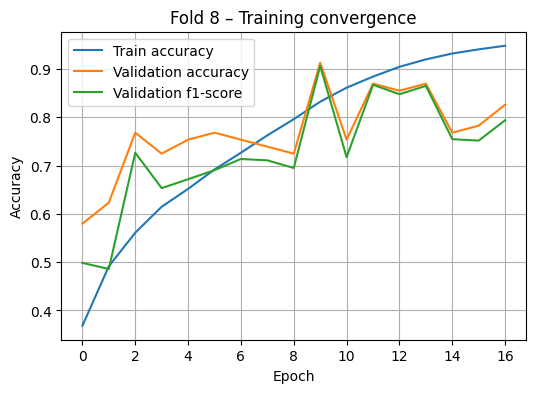

========= LAST MODEL PERF =========
Fold 8 TEST utterance accuracy: 0.743

Classification report:
              precision    recall  f1-score   support

     neutral      0.800     1.000     0.889        12
       anger      1.000     0.400     0.571         5
        fear      0.000     0.000     0.000         2
   happiness      1.000     0.667     0.800         6
     sadness      0.000     0.000     0.000         2
     boredom      0.667     1.000     0.800         4
     disgust      0.500     1.000     0.667         4

    accuracy                          0.743        35
   macro avg      0.567     0.581     0.532        35
weighted avg      0.722     0.743     0.691        35



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


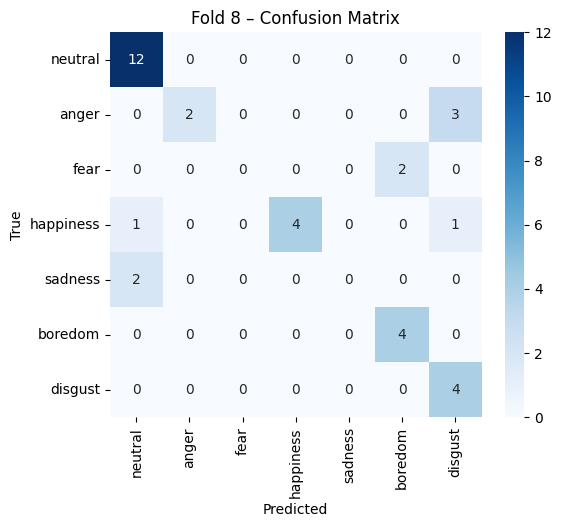

========= BEST MODEL PERF =========
Fold 8 TEST utterance accuracy: 0.771

Classification report:
              precision    recall  f1-score   support

     neutral      0.923     1.000     0.960        12
       anger      0.500     0.400     0.444         5
        fear      1.000     0.500     0.667         2
   happiness      1.000     0.833     0.909         6
     sadness      1.000     1.000     1.000         2
     boredom      0.667     0.500     0.571         4
     disgust      0.429     0.750     0.545         4

    accuracy                          0.771        35
   macro avg      0.788     0.712     0.728        35
weighted avg      0.799     0.771     0.771        35



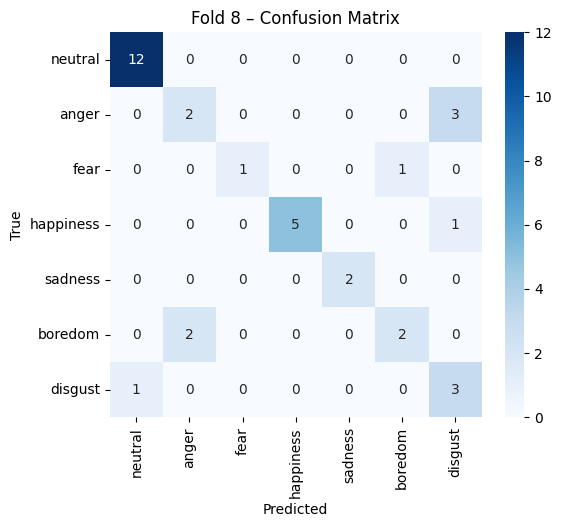


=== Fold 9 ===
Train speakers: [np.str_('03'), np.str_('08'), np.str_('09'), np.str_('10'), np.str_('12'), np.str_('14'), np.str_('15'), np.str_('16')]
Val speakers:   ['11']
Test speakers:  ['13']
Epoch 01 | train_acc=0.387 | val_acc=0.364 | val_f1=0.221
Epoch 02 | train_acc=0.512 | val_acc=0.473 | val_f1=0.329
Epoch 03 | train_acc=0.571 | val_acc=0.473 | val_f1=0.317
Epoch 04 | train_acc=0.622 | val_acc=0.400 | val_f1=0.257
Epoch 05 | train_acc=0.660 | val_acc=0.545 | val_f1=0.387
Epoch 06 | train_acc=0.698 | val_acc=0.527 | val_f1=0.461
Epoch 07 | train_acc=0.734 | val_acc=0.527 | val_f1=0.424
Epoch 08 | train_acc=0.767 | val_acc=0.527 | val_f1=0.435
Epoch 09 | train_acc=0.802 | val_acc=0.636 | val_f1=0.535
Epoch 10 | train_acc=0.836 | val_acc=0.636 | val_f1=0.588
Epoch 11 | train_acc=0.864 | val_acc=0.582 | val_f1=0.425
Epoch 12 | train_acc=0.888 | val_acc=0.691 | val_f1=0.692
Epoch 13 | train_acc=0.906 | val_acc=0.745 | val_f1=0.730
Epoch 14 | train_acc=0.922 | val_acc=0.727 | va

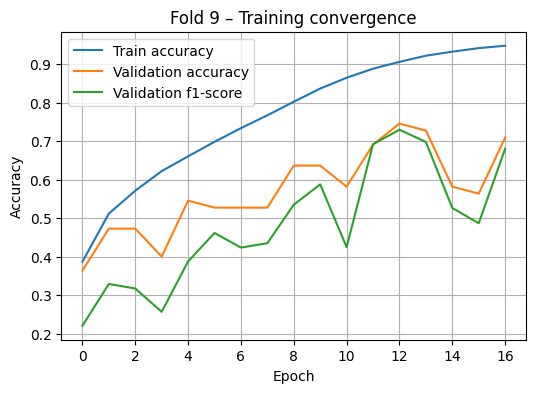

========= LAST MODEL PERF =========
Fold 9 TEST utterance accuracy: 0.787

Classification report:
              precision    recall  f1-score   support

     neutral      1.000     0.417     0.588        12
       anger      0.875     0.700     0.778        10
        fear      1.000     0.875     0.933         8
   happiness      0.778     1.000     0.875         7
     sadness      0.600     0.900     0.720        10
     boredom      0.556     1.000     0.714         5
     disgust      1.000     0.889     0.941         9

    accuracy                          0.787        61
   macro avg      0.830     0.826     0.793        61
weighted avg      0.852     0.787     0.781        61



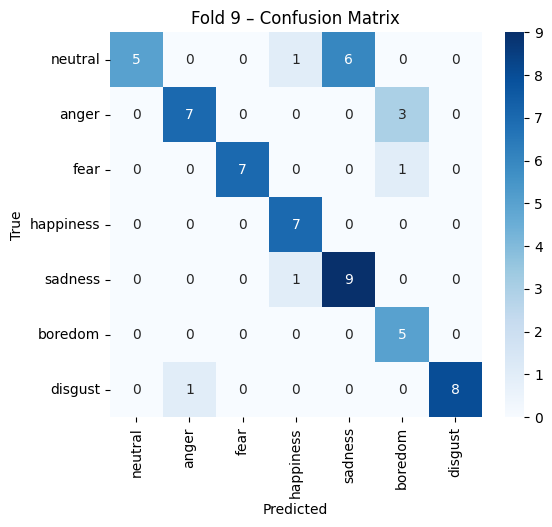

========= BEST MODEL PERF =========
Fold 9 TEST utterance accuracy: 0.689

Classification report:
              precision    recall  f1-score   support

     neutral      1.000     0.250     0.400        12
       anger      0.562     0.900     0.692        10
        fear      1.000     0.875     0.933         8
   happiness      0.778     1.000     0.875         7
     sadness      0.529     0.900     0.667        10
     boredom      0.714     1.000     0.833         5
     disgust      1.000     0.222     0.364         9

    accuracy                          0.689        61
   macro avg      0.798     0.735     0.681        61
weighted avg      0.802     0.689     0.646        61



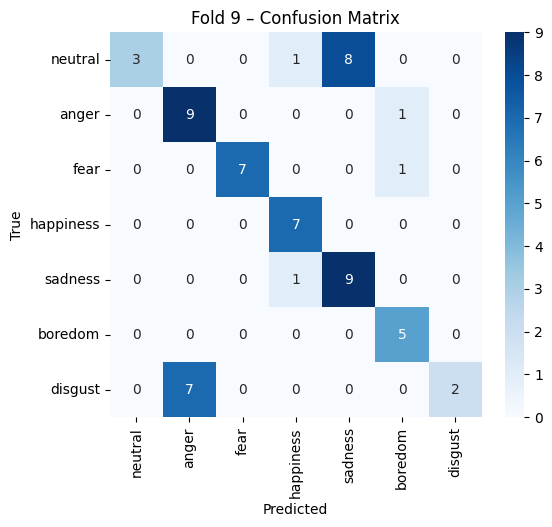


=== Fold 10 ===
Train speakers: [np.str_('03'), np.str_('08'), np.str_('11'), np.str_('12'), np.str_('13'), np.str_('14'), np.str_('15'), np.str_('16')]
Val speakers:   ['09']
Test speakers:  ['10']
Epoch 01 | train_acc=0.370 | val_acc=0.674 | val_f1=0.531
Epoch 02 | train_acc=0.495 | val_acc=0.674 | val_f1=0.509
Epoch 03 | train_acc=0.566 | val_acc=0.535 | val_f1=0.460
Epoch 04 | train_acc=0.618 | val_acc=0.488 | val_f1=0.347
Epoch 05 | train_acc=0.659 | val_acc=0.442 | val_f1=0.305
Epoch 06 | train_acc=0.699 | val_acc=0.721 | val_f1=0.682
Epoch 07 | train_acc=0.736 | val_acc=0.488 | val_f1=0.380
Epoch 08 | train_acc=0.773 | val_acc=0.651 | val_f1=0.535
Epoch 09 | train_acc=0.810 | val_acc=0.698 | val_f1=0.599
Epoch 10 | train_acc=0.841 | val_acc=0.628 | val_f1=0.587
Epoch 11 | train_acc=0.869 | val_acc=0.674 | val_f1=0.602
Epoch 12 | train_acc=0.891 | val_acc=0.721 | val_f1=0.645
Epoch 13 | train_acc=0.909 | val_acc=0.558 | val_f1=0.441
Epoch 14 | train_acc=0.922 | val_acc=0.674 | v

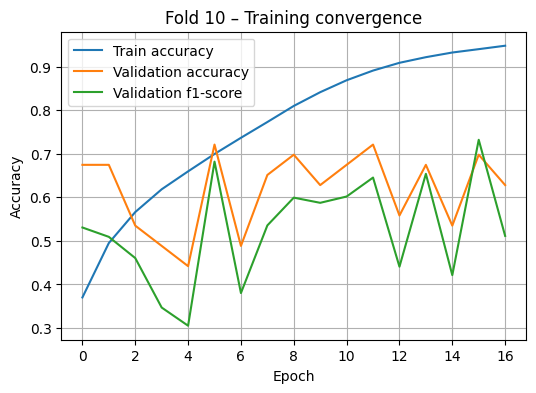

========= LAST MODEL PERF =========
Fold 10 TEST utterance accuracy: 0.763

Classification report:
              precision    recall  f1-score   support

     neutral      1.000     1.000     1.000        10
       anger      0.778     0.875     0.824         8
        fear      0.333     1.000     0.500         1
   happiness      1.000     0.375     0.545         8
     sadness      1.000     1.000     1.000         4
     boredom      0.375     1.000     0.545         3
     disgust      1.000     0.250     0.400         4

    accuracy                          0.763        38
   macro avg      0.784     0.786     0.688        38
weighted avg      0.886     0.763     0.755        38



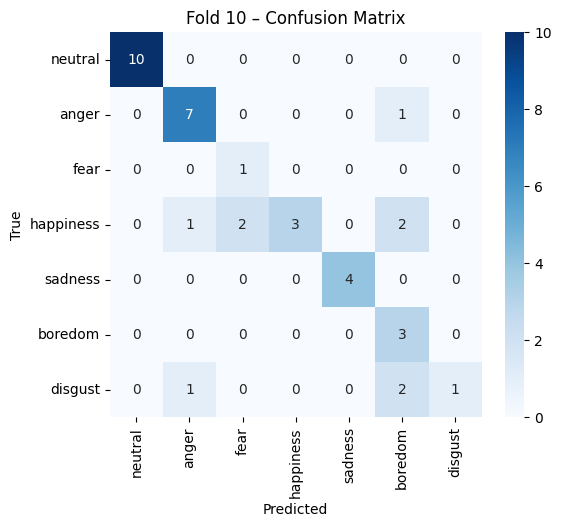

========= BEST MODEL PERF =========
Fold 10 TEST utterance accuracy: 0.842

Classification report:
              precision    recall  f1-score   support

     neutral      1.000     1.000     1.000        10
       anger      0.889     1.000     0.941         8
        fear      0.333     1.000     0.500         1
   happiness      1.000     0.625     0.769         8
     sadness      1.000     1.000     1.000         4
     boredom      0.500     1.000     0.667         3
     disgust      1.000     0.250     0.400         4

    accuracy                          0.842        38
   macro avg      0.817     0.839     0.754        38
weighted avg      0.920     0.842     0.836        38



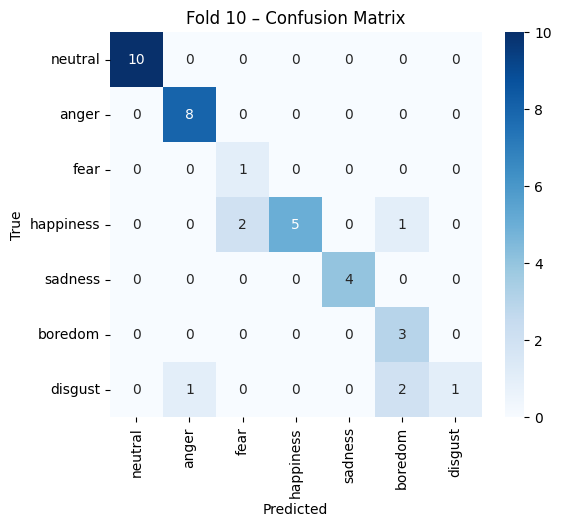

In [ ]:
fold_accuracies = []
audio_cache = {}

for fold, (train_idx, test_idx) in enumerate(kf.split(speaker_ids), 1):
    train_acc_hist = []
    val_acc_hist = []
    val_f1_hist = []
    all_train_speakers = speaker_ids[train_idx]
    test_speakers     = speaker_ids[test_idx]

    # --- split train speakers into train / validation
    val_speaker = VAL_SPEAKER_PER_TEST[test_speakers[0]]

    train_speakers = [
        s for s in all_train_speakers
        if s != val_speaker
    ]
    val_speakers = [val_speaker]

    train_items = sum([speaker_to_items[s] for s in train_speakers], [])
    val_items   = sum([speaker_to_items[s] for s in val_speakers], [])
    test_items  = sum([speaker_to_items[s] for s in test_speakers], [])

    # --- datasets
    train_set = EmoDBDataset(
        train_items,
        EMODB_ROOT,
        audio_cache=audio_cache
    )
    train_loader = DataLoader(
        train_set,
        batch_size=128,
        shuffle=True,
        drop_last=True
    )

    # --- model & optimization
    model = build_model()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    best_val_f1 = 0.0
    best_state = None

    print(f"\n=== Fold {fold} ===")
    print(f"Train speakers: {train_speakers}")
    print(f"Val speakers:   {val_speakers}")
    print(f"Test speakers:  {test_speakers}")

    for epoch in range(1, 18):
        tr_acc = train_epoch(model, train_loader, optimizer, criterion)
        val_acc, y_true, y_pred = eval_utterance_level(model, val_items, EMODB_ROOT,return_preds=True)
        val_f1 = f1_score(y_true, y_pred, average="macro")

        train_acc_hist.append(tr_acc)
        val_acc_hist.append(val_acc)
        val_f1_hist.append(val_f1)
        print(
            f"Epoch {epoch:02d} | "
            f"train_acc={tr_acc:.3f} | val_acc={val_acc:.3f} | val_f1={val_f1:.3f}"
        )
    
        if val_f1 >= best_val_f1:
            best_val_f1 = val_f1
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
    
    plt.figure(figsize=(6, 4))
    plt.plot(train_acc_hist, label="Train accuracy")
    plt.plot(val_acc_hist, label="Validation accuracy")
    plt.plot(val_f1_hist, label="Validation f1-score")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Fold {fold} – Training convergence")
    plt.legend()
    plt.grid(True)
    plt.show()
    print("========= LAST MODEL PERF =========")
    te_acc, y_true, y_pred = eval_utterance_level(
        model,
        test_items,
        EMODB_ROOT,
        return_preds=True
    )
    
    print(f"Fold {fold} TEST utterance accuracy: {te_acc:.3f}")
    print("\nClassification report:")
    print(
        classification_report(
            y_true,
            y_pred,
            target_names=[EMOTION_MAP_INV[i] for i in range(N_CLASSES)],
            digits=3
        )
    )
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=EMOTION_MAP_INV.values(),
        yticklabels=EMOTION_MAP_INV.values()
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Fold {fold} – Confusion Matrix")
    plt.show()
    print("========= BEST MODEL PERF =========")
    # --- test with best validation model
    model.load_state_dict(best_state)
    if fold == 1:
        torch.save(model, "/kaggle/working/sincnet_emodb_fold1_best.pt")

    te_acc, y_true, y_pred = eval_utterance_level(
        model,
        test_items,
        EMODB_ROOT,
        return_preds=True
    )
    
    print(f"Fold {fold} TEST utterance accuracy: {te_acc:.3f}")
    print("\nClassification report:")
    print(
        classification_report(
            y_true,
            y_pred,
            target_names=[EMOTION_MAP_INV[i] for i in range(N_CLASSES)],
            digits=3
        )
    )
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=EMOTION_MAP_INV.values(),
        yticklabels=EMOTION_MAP_INV.values()
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Fold {fold} – Confusion Matrix")
    plt.show()

    fold_accuracies.append(te_acc)

### 3. Résultats et analyse des performances

In [ ]:
fold_accuracies = np.array(fold_accuracies)

print("\n===== FINAL RESULTS =====")
print("Per-fold:", np.round(fold_accuracies, 3))
print(f"Mean: {fold_accuracies.mean():.3f}")
print(f"Std:  {fold_accuracies.std():.3f}")



===== FINAL RESULTS =====
Per-fold: [0.899 0.628 0.648 0.741 0.714 0.661 0.618 0.771 0.689 0.842]
Mean: 0.721
Std:  0.089


In [ ]:
# Forgot to save them in a list during training, no time to re run everything
last_acc = [0.768, 0.791, 0.690, 0.707, 0.796, 0.589, 0.618, 0.743, 0.787, 0.763]
last_f1 =  np.array([0.727, 0.751, 0.657, 0.594, 0.705, 0.528, 0.556, 0.532, 0.793, 0.688])
best_f1 =  np.array([0.900, 0.576, 0.582, 0.670, 0.532, 0.579, 0.556, 0.728, 0.681, 0.754])
combined_acc = np.array([0.899, 0.791, 0.690, 0.741, 0.796, 0.661, 0.618, 0.771, 0.787, 0.842])
combined_f1 = np.array([0.900, 0.751, 0.657, 0.670, 0.705, 0.579, 0.556, 0.728, 0.793, 0.754])

In [ ]:
print("\n===== FINAL RESULTS LAST Model =====")
print("Per-fold accuracy:", np.round(last_acc, 3))
print(f"Mean: {last_acc.mean():.3f}")
print(f"Std:  {last_acc.std():.3f}")
print("Per-fold f1-score:", np.round(last_f1, 3))
print(f"Mean: {last_f1.mean():.3f}")
print(f"Std:  {last_f1.std():.3f}")
print("\n===== FINAL RESULTS Best Model =====")
print("Per-fold accuracy:", np.round(fold_accuracies, 3))
print(f"Mean: {fold_accuracies.mean():.3f}")
print(f"Std:  {fold_accuracies.std():.3f}")
print("Per-fold f1-score:", np.round(best_f1, 3))
print(f"Mean: {best_f1.mean():.3f}")
print(f"Std:  {best_f1.std():.3f}")
print("\n===== FINAL RESULTS Combined Models =====")
print("Per-fold accuracy:", np.round(combined_acc, 3))
print(f"Mean: {combined_acc.mean():.3f}")
print(f"Std:  {combined_acc.std():.3f}")
print("Per-fold f1-score:", np.round(combined_f1, 3))
print(f"Mean: {combined_f1.mean():.3f}")
print(f"Std:  {combined_f1.std():.3f}")


===== FINAL RESULTS LAST Model =====
Per-fold accuracy: [0.768 0.791 0.69  0.707 0.796 0.589 0.618 0.743 0.787 0.763]
Mean: 0.725
Std:  0.070
Per-fold f1-score: [0.727 0.751 0.657 0.594 0.705 0.528 0.556 0.532 0.793 0.688]
Mean: 0.653
Std:  0.090

===== FINAL RESULTS Best Model =====
Per-fold accuracy: [0.899 0.628 0.648 0.741 0.714 0.661 0.618 0.771 0.689 0.842]
Mean: 0.721
Std:  0.089
Per-fold f1-score: [0.9   0.576 0.582 0.67  0.532 0.579 0.556 0.728 0.681 0.754]
Mean: 0.656
Std:  0.109

===== FINAL RESULTS Combined Models =====
Per-fold accuracy: [0.899 0.791 0.69  0.741 0.796 0.661 0.618 0.771 0.787 0.842]
Mean: 0.760
Std:  0.080
Per-fold f1-score: [0.9   0.751 0.657 0.67  0.705 0.579 0.556 0.728 0.793 0.754]
Mean: 0.709
Std:  0.096


**Analyse des Résultats : Speaker k-Fold Cross-Validation**

Le modèle atteint une Accuracy moyenne de 73.0% et un F1-score moyen de 66.0% sur l'ensemble des 10 folds.
Ces résultats sont comparables bien que légèrement inférieurs à la meilleure baseline (XGBoost : 76.8%), mais ils sont obtenus ici via une validation croisée rigoureuse, garantissant une estimation plus réaliste de la généralisation.

L'écart-type élevé ($\sigma \approx 0.09$) met en lumière une forte disparité selon les locuteurs de test :
* On observe un pic de performance à 90% d'accuracy, surpassant largement les baselines (+12%). Cela démontre que l'architecture SincNet est capable de capturer très finement les dynamiques émotionnelles sur des locuteurs dont la prosodie est "standard" ou proche des données d'entraînement.
* La chute à 61.8% sur d'autres locuteurs illustre la difficulté intrinsèque de la reconnaissance en fonction du locuteur. Certains locuteurs peuvent exprimer leurs émotions de manière légèrement différente, ce que le modèle peine à généraliser.

De plus, on observe que le fait de prendre un independant speaker pour la validation est un choix assez délicat dans notre contexte. En effet, on remarque que prendre arbitrairement le modèle de la dernière epoch n'est pas forcément plus mauvais que de garder celui ayant eu le meilleur f1-score. Cette situation peut s'expliquer par le fait que notre jeu de données étant très petit, notre validation set (tout comme le test set) n'est composé que d'un seul locuteur, ce qui peut fortement biaisé le choix du modèle avec les meilleurs performances. Probablement que dans un contexte avec un jeu de données pouvant se permettre d'avoir 5 locuteurs indépendants pour le jeu de données de validation (donc une plus grande diversité de données), alors l'utilsation du jeu de données de validation serait très important.

### Comparaison avec une approche CNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RawCNN(nn.Module):
    def __init__(self, options):
        super().__init__()

        self.cnn_N_filt = options["cnn_N_filt"]
        self.cnn_len_filt = options["cnn_len_filt"]
        self.cnn_max_pool_len = options["cnn_max_pool_len"]
        self.cnn_act = options["cnn_act"]
        self.cnn_drop = options["cnn_drop"]

        self.input_dim = options["input_dim"]
        self.N_cnn_lay = len(self.cnn_N_filt)

        self.conv = nn.ModuleList()
        self.act = nn.ModuleList()
        self.drop = nn.ModuleList()

        current_input = self.input_dim

        for i in range(self.N_cnn_lay):
            in_ch = 1 if i == 0 else self.cnn_N_filt[i-1]
            out_ch = self.cnn_N_filt[i]
            k = self.cnn_len_filt[i]

            self.conv.append(
                nn.Conv1d(in_ch, out_ch, kernel_size=k)
            )
            self.act.append(nn.ReLU())
            self.drop.append(nn.Dropout(self.cnn_drop[i]))

            current_input = (current_input - k + 1) // self.cnn_max_pool_len[i]

        self.out_dim = current_input * self.cnn_N_filt[-1]

    def forward(self, x):
        # x: (batch, samples)
        x = x.unsqueeze(1)

        for i in range(self.N_cnn_lay):
            x = self.conv[i](x)
            x = F.max_pool1d(x, self.cnn_max_pool_len[i])
            x = self.act[i](x)
            x = self.drop[i](x)

        x = x.view(x.size(0), -1)
        return x


In [ ]:
from dnn_models import MLP

def build_rawcnn_model():
    cnn_options = {
        "cnn_N_filt": [80, 60, 60],
        "cnn_len_filt": [251, 5, 5],
        "cnn_max_pool_len": [3, 3, 3],
        "cnn_act": ["relu", "relu", "relu"],
        "cnn_drop": [0.0, 0.0, 0.0],
        "input_dim": int(16000 * 0.2),
    }

    dnn_options = {
        "input_dim": None,
        "fc_lay": [2048, 2048],
        "fc_drop": [0.5, 0.5],
        "fc_use_laynorm": [True, True],
        "fc_use_batchnorm": [False, False],
        "fc_use_laynorm_inp": False,
        "fc_use_batchnorm_inp": False,
        "fc_act": ["relu", "relu"]
    }

    cnn = RawCNN(cnn_options)
    dnn_options["input_dim"] = cnn.out_dim
    dnn = MLP(dnn_options)
    classifier = nn.Linear(dnn_options["fc_lay"][-1], N_CLASSES)

    return nn.Sequential(cnn, dnn, classifier).to(device)


=== Fold 1 ===
Train speakers: [np.str_('03'), np.str_('08'), np.str_('09'), np.str_('10'), np.str_('11'), np.str_('13'), np.str_('15'), np.str_('16')]
Val speakers:   ['12']
Test speakers:  ['14']
Epoch 01 | train_acc=0.449 | val_acc=0.514 | val_f1=0.303
Epoch 02 | train_acc=0.602 | val_acc=0.543 | val_f1=0.419
Epoch 03 | train_acc=0.699 | val_acc=0.457 | val_f1=0.315
Epoch 04 | train_acc=0.778 | val_acc=0.514 | val_f1=0.354
Epoch 05 | train_acc=0.844 | val_acc=0.571 | val_f1=0.436
Epoch 06 | train_acc=0.889 | val_acc=0.543 | val_f1=0.360
Epoch 07 | train_acc=0.917 | val_acc=0.686 | val_f1=0.529
Epoch 08 | train_acc=0.935 | val_acc=0.629 | val_f1=0.553
Epoch 09 | train_acc=0.949 | val_acc=0.514 | val_f1=0.351
Epoch 10 | train_acc=0.958 | val_acc=0.629 | val_f1=0.498
Epoch 11 | train_acc=0.963 | val_acc=0.600 | val_f1=0.447
Epoch 12 | train_acc=0.969 | val_acc=0.543 | val_f1=0.377
Epoch 13 | train_acc=0.973 | val_acc=0.571 | val_f1=0.406
Epoch 14 | train_acc=0.975 | val_acc=0.543 | va

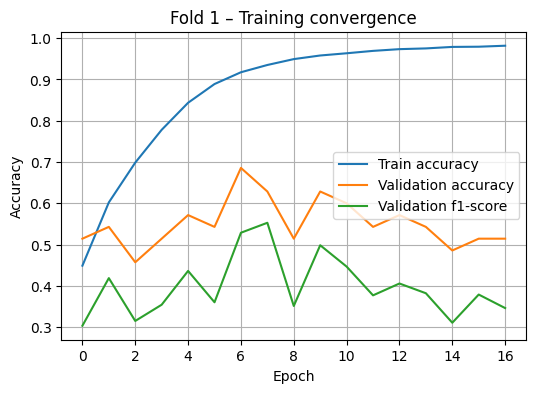

========= LAST MODEL PERF =========
Fold 1 TEST utterance accuracy: 0.710

Classification report:
              precision    recall  f1-score   support

     neutral      0.696     1.000     0.821        16
       anger      0.667     0.750     0.706         8
        fear      1.000     1.000     1.000         8
   happiness      0.000     0.000     0.000        12
     sadness      0.333     0.375     0.353         8
     boredom      0.909     1.000     0.952        10
     disgust      0.667     0.857     0.750         7

    accuracy                          0.710        69
   macro avg      0.610     0.712     0.655        69
weighted avg      0.593     0.710     0.643        69



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


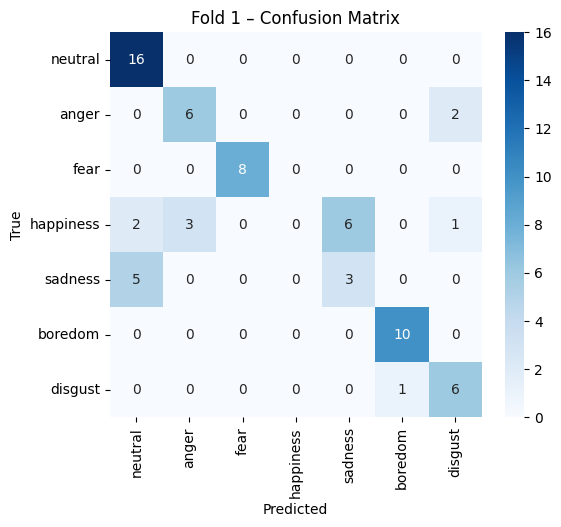

========= BEST MODEL PERF =========
Fold 1 TEST utterance accuracy: 0.696

Classification report:
              precision    recall  f1-score   support

     neutral      0.900     0.562     0.692        16
       anger      0.545     0.750     0.632         8
        fear      0.889     1.000     0.941         8
   happiness      1.000     0.250     0.400        12
     sadness      0.389     0.875     0.538         8
     boredom      0.909     1.000     0.952        10
     disgust      0.714     0.714     0.714         7

    accuracy                          0.696        69
   macro avg      0.764     0.736     0.696        69
weighted avg      0.798     0.696     0.685        69



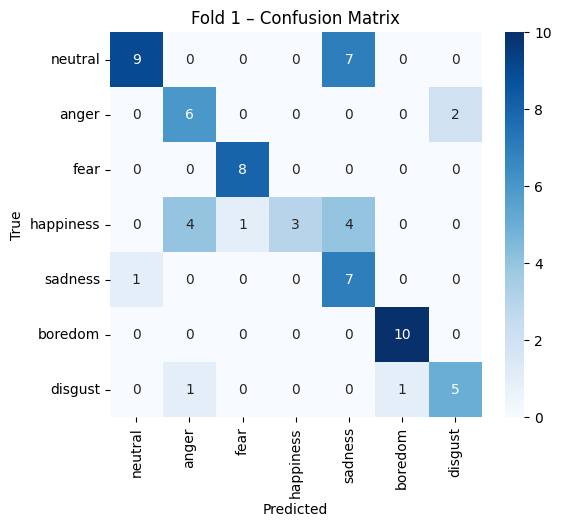


=== Fold 2 ===
Train speakers: [np.str_('03'), np.str_('08'), np.str_('11'), np.str_('12'), np.str_('13'), np.str_('14'), np.str_('15'), np.str_('16')]
Val speakers:   ['10']
Test speakers:  ['09']
Epoch 01 | train_acc=0.468 | val_acc=0.579 | val_f1=0.373
Epoch 02 | train_acc=0.640 | val_acc=0.368 | val_f1=0.232
Epoch 03 | train_acc=0.737 | val_acc=0.579 | val_f1=0.457
Epoch 04 | train_acc=0.808 | val_acc=0.395 | val_f1=0.317
Epoch 05 | train_acc=0.860 | val_acc=0.447 | val_f1=0.378
Epoch 06 | train_acc=0.897 | val_acc=0.395 | val_f1=0.300
Epoch 07 | train_acc=0.922 | val_acc=0.421 | val_f1=0.328
Epoch 08 | train_acc=0.938 | val_acc=0.421 | val_f1=0.348
Epoch 09 | train_acc=0.950 | val_acc=0.553 | val_f1=0.421
Epoch 10 | train_acc=0.958 | val_acc=0.500 | val_f1=0.383
Epoch 11 | train_acc=0.965 | val_acc=0.553 | val_f1=0.450
Epoch 12 | train_acc=0.969 | val_acc=0.474 | val_f1=0.401
Epoch 13 | train_acc=0.972 | val_acc=0.500 | val_f1=0.391
Epoch 14 | train_acc=0.974 | val_acc=0.474 | va

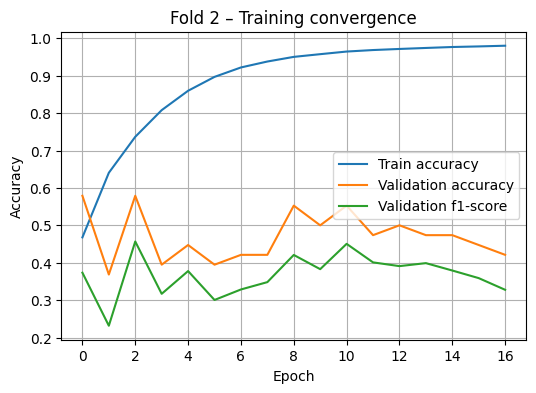

========= LAST MODEL PERF =========
Fold 2 TEST utterance accuracy: 0.674

Classification report:
              precision    recall  f1-score   support

     neutral      0.647     0.846     0.733        13
       anger      0.500     1.000     0.667         4
        fear      0.714     0.625     0.667         8
   happiness      0.500     1.000     0.667         1
     sadness      0.000     0.000     0.000         4
     boredom      1.000     1.000     1.000         4
     disgust      1.000     0.444     0.615         9

    accuracy                          0.674        43
   macro avg      0.623     0.702     0.621        43
weighted avg      0.689     0.674     0.645        43



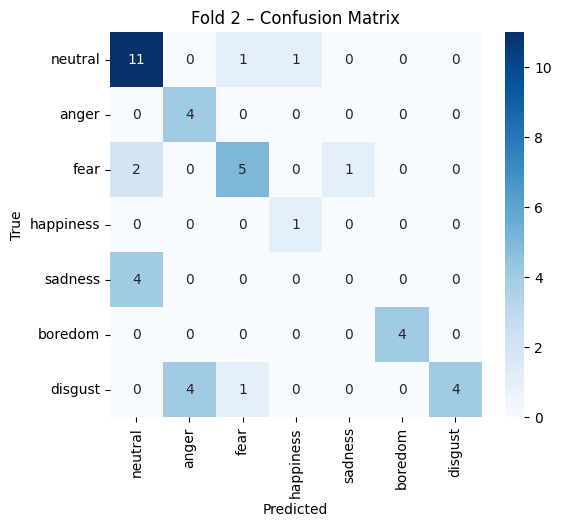

========= BEST MODEL PERF =========
Fold 2 TEST utterance accuracy: 0.721

Classification report:
              precision    recall  f1-score   support

     neutral      0.800     0.923     0.857        13
       anger      0.571     1.000     0.727         4
        fear      0.667     0.500     0.571         8
   happiness      0.000     0.000     0.000         1
     sadness      0.400     0.500     0.444         4
     boredom      1.000     1.000     1.000         4
     disgust      0.833     0.556     0.667         9

    accuracy                          0.721        43
   macro avg      0.610     0.640     0.610        43
weighted avg      0.724     0.721     0.707        43



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


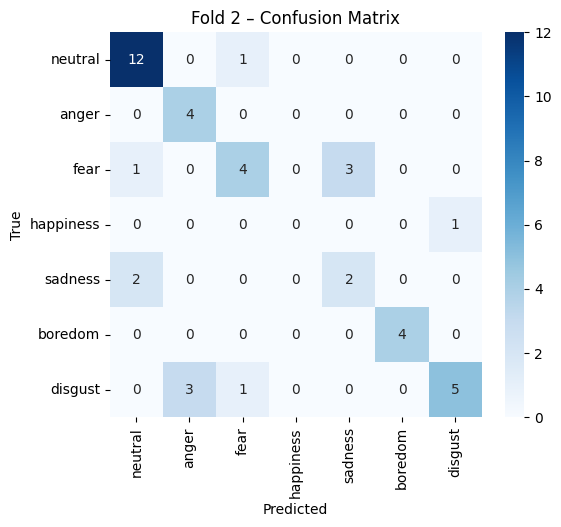


=== Fold 3 ===
Train speakers: [np.str_('03'), np.str_('08'), np.str_('09'), np.str_('10'), np.str_('11'), np.str_('12'), np.str_('13'), np.str_('14')]
Val speakers:   ['15']
Test speakers:  ['16']
Epoch 01 | train_acc=0.482 | val_acc=0.429 | val_f1=0.292
Epoch 02 | train_acc=0.633 | val_acc=0.571 | val_f1=0.407
Epoch 03 | train_acc=0.729 | val_acc=0.536 | val_f1=0.460
Epoch 04 | train_acc=0.806 | val_acc=0.464 | val_f1=0.405
Epoch 05 | train_acc=0.861 | val_acc=0.554 | val_f1=0.496
Epoch 06 | train_acc=0.899 | val_acc=0.482 | val_f1=0.431
Epoch 07 | train_acc=0.925 | val_acc=0.446 | val_f1=0.365
Epoch 08 | train_acc=0.943 | val_acc=0.625 | val_f1=0.562
Epoch 09 | train_acc=0.954 | val_acc=0.643 | val_f1=0.563
Epoch 10 | train_acc=0.961 | val_acc=0.464 | val_f1=0.383
Epoch 11 | train_acc=0.967 | val_acc=0.482 | val_f1=0.381
Epoch 12 | train_acc=0.970 | val_acc=0.464 | val_f1=0.400
Epoch 13 | train_acc=0.975 | val_acc=0.518 | val_f1=0.454
Epoch 14 | train_acc=0.977 | val_acc=0.482 | va

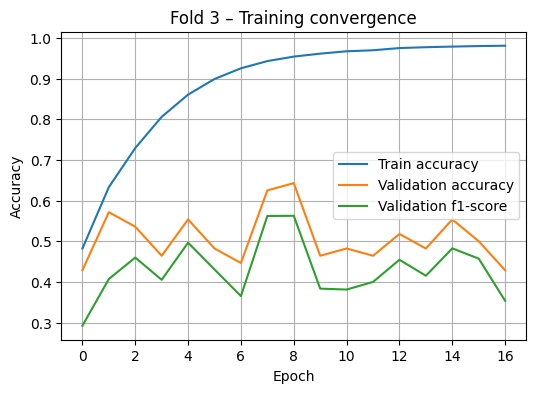

========= LAST MODEL PERF =========
Fold 3 TEST utterance accuracy: 0.577

Classification report:
              precision    recall  f1-score   support

     neutral      0.412     1.000     0.583        14
       anger      1.000     0.571     0.727        14
        fear      0.778     0.636     0.700        11
   happiness      0.250     0.143     0.182         7
     sadness      0.000     0.000     0.000        11
     boredom      1.000     0.778     0.875         9
     disgust      1.000     0.800     0.889         5

    accuracy                          0.577        71
   macro avg      0.634     0.561     0.565        71
weighted avg      0.621     0.577     0.558        71



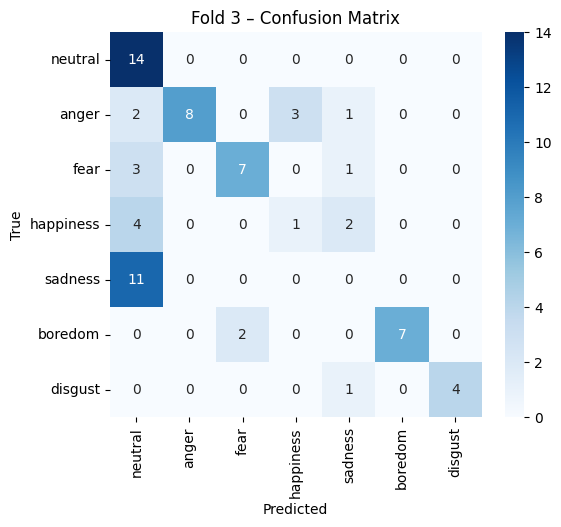

========= BEST MODEL PERF =========
Fold 3 TEST utterance accuracy: 0.324

Classification report:
              precision    recall  f1-score   support

     neutral      0.368     1.000     0.538        14
       anger      0.000     0.000     0.000        14
        fear      0.500     0.091     0.154        11
   happiness      0.125     0.286     0.174         7
     sadness      0.000     0.000     0.000        11
     boredom      1.000     0.444     0.615         9
     disgust      0.500     0.400     0.444         5

    accuracy                          0.324        71
   macro avg      0.356     0.317     0.275        71
weighted avg      0.324     0.324     0.256        71



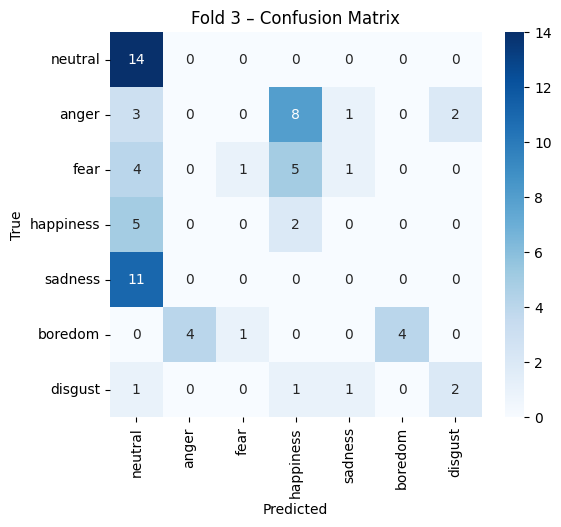


=== Fold 4 ===
Train speakers: [np.str_('09'), np.str_('10'), np.str_('11'), np.str_('12'), np.str_('13'), np.str_('14'), np.str_('15'), np.str_('16')]
Val speakers:   ['03']
Test speakers:  ['08']
Epoch 01 | train_acc=0.457 | val_acc=0.531 | val_f1=0.291
Epoch 02 | train_acc=0.625 | val_acc=0.633 | val_f1=0.540
Epoch 03 | train_acc=0.728 | val_acc=0.633 | val_f1=0.513
Epoch 04 | train_acc=0.808 | val_acc=0.551 | val_f1=0.347
Epoch 05 | train_acc=0.866 | val_acc=0.592 | val_f1=0.314
Epoch 06 | train_acc=0.903 | val_acc=0.633 | val_f1=0.500
Epoch 07 | train_acc=0.927 | val_acc=0.571 | val_f1=0.288
Epoch 08 | train_acc=0.942 | val_acc=0.592 | val_f1=0.418
Epoch 09 | train_acc=0.953 | val_acc=0.633 | val_f1=0.405
Epoch 10 | train_acc=0.961 | val_acc=0.571 | val_f1=0.324
Epoch 11 | train_acc=0.966 | val_acc=0.612 | val_f1=0.428
Epoch 12 | train_acc=0.970 | val_acc=0.592 | val_f1=0.433
Epoch 13 | train_acc=0.974 | val_acc=0.653 | val_f1=0.490
Epoch 14 | train_acc=0.977 | val_acc=0.633 | va

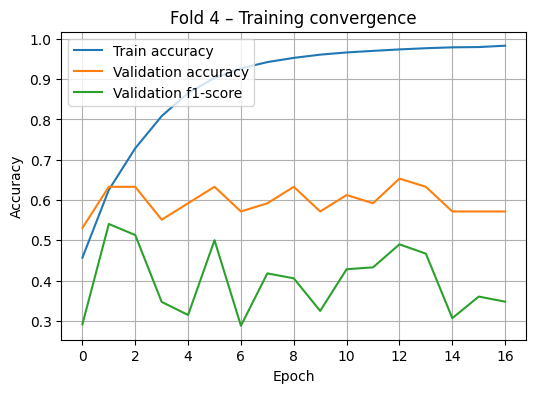

========= LAST MODEL PERF =========
Fold 4 TEST utterance accuracy: 0.690

Classification report:
              precision    recall  f1-score   support

     neutral      0.917     0.917     0.917        12
       anger      1.000     0.200     0.333        10
        fear      0.000     0.000     0.000         0
   happiness      0.500     0.667     0.571         6
     sadness      0.625     0.455     0.526        11
     boredom      1.000     1.000     1.000         9
     disgust      0.529     0.900     0.667        10

    accuracy                          0.690        58
   macro avg      0.653     0.591     0.573        58
weighted avg      0.779     0.690     0.676        58



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


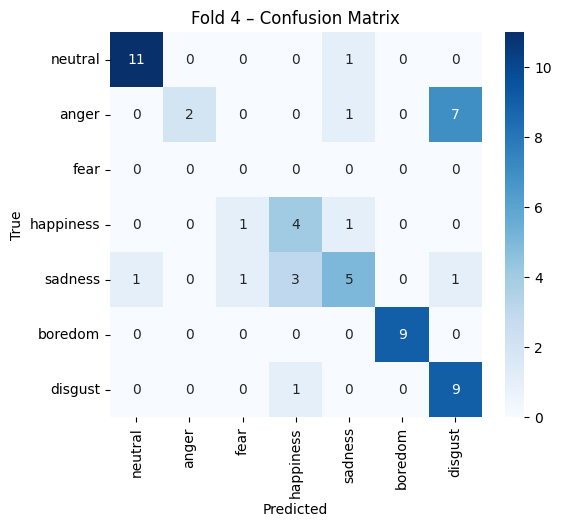

========= BEST MODEL PERF =========
Fold 4 TEST utterance accuracy: 0.517

Classification report:
              precision    recall  f1-score   support

     neutral      1.000     0.667     0.800        12
       anger      1.000     0.100     0.182        10
        fear      0.000     0.000     0.000         0
   happiness      0.250     0.833     0.385         6
     sadness      0.375     0.273     0.316        11
     boredom      1.000     1.000     1.000         9
     disgust      0.364     0.400     0.381        10

    accuracy                          0.517        58
   macro avg      0.570     0.468     0.438        58
weighted avg      0.694     0.517     0.517        58



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


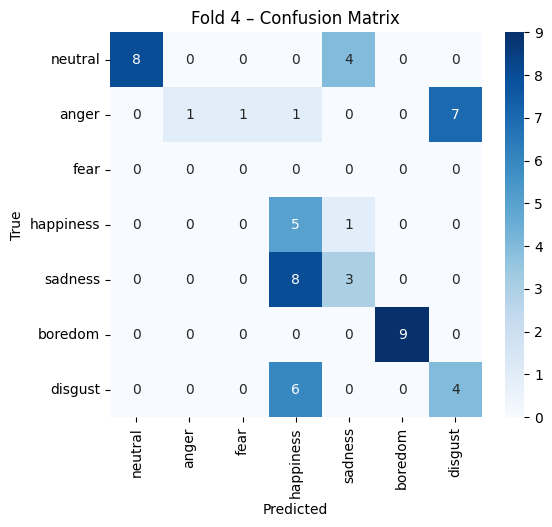


=== Fold 5 ===
Train speakers: [np.str_('09'), np.str_('10'), np.str_('11'), np.str_('12'), np.str_('13'), np.str_('14'), np.str_('15'), np.str_('16')]
Val speakers:   ['08']
Test speakers:  ['03']
Epoch 01 | train_acc=0.462 | val_acc=0.621 | val_f1=0.545
Epoch 02 | train_acc=0.614 | val_acc=0.621 | val_f1=0.484
Epoch 03 | train_acc=0.707 | val_acc=0.534 | val_f1=0.451
Epoch 04 | train_acc=0.785 | val_acc=0.621 | val_f1=0.456
Epoch 05 | train_acc=0.844 | val_acc=0.517 | val_f1=0.463
Epoch 06 | train_acc=0.886 | val_acc=0.690 | val_f1=0.568
Epoch 07 | train_acc=0.916 | val_acc=0.655 | val_f1=0.530
Epoch 08 | train_acc=0.934 | val_acc=0.672 | val_f1=0.626
Epoch 09 | train_acc=0.946 | val_acc=0.638 | val_f1=0.529
Epoch 10 | train_acc=0.955 | val_acc=0.672 | val_f1=0.528
Epoch 11 | train_acc=0.962 | val_acc=0.655 | val_f1=0.618
Epoch 12 | train_acc=0.967 | val_acc=0.638 | val_f1=0.498
Epoch 13 | train_acc=0.970 | val_acc=0.638 | val_f1=0.490
Epoch 14 | train_acc=0.974 | val_acc=0.621 | va

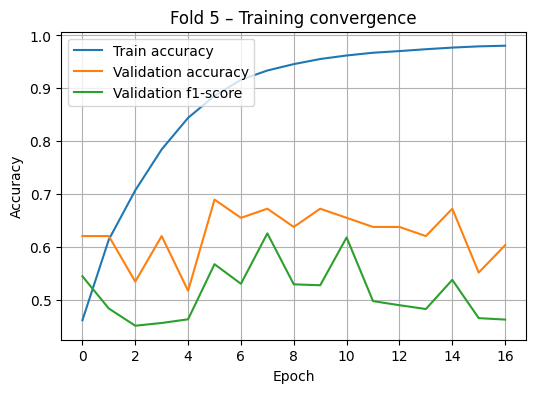

========= LAST MODEL PERF =========
Fold 5 TEST utterance accuracy: 0.510

Classification report:
              precision    recall  f1-score   support

     neutral      0.875     1.000     0.933        14
       anger      0.000     0.000     0.000         5
        fear      0.000     0.000     0.000         1
   happiness      0.000     0.000     0.000         4
     sadness      0.000     0.000     0.000         7
     boredom      0.000     0.000     0.000         7
     disgust      0.423     1.000     0.595        11

    accuracy                          0.510        49
   macro avg      0.185     0.286     0.218        49
weighted avg      0.345     0.510     0.400        49



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


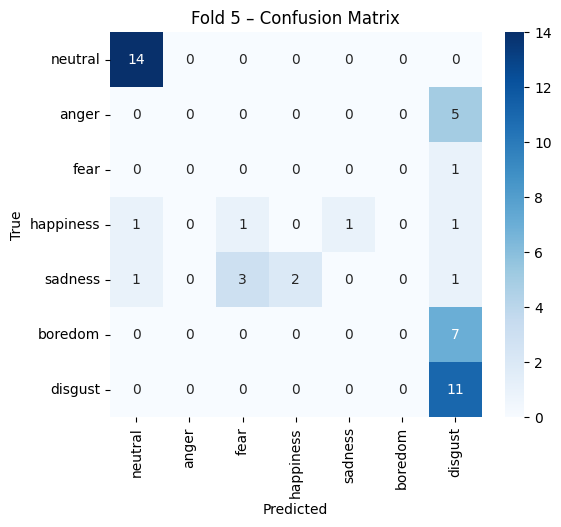

========= BEST MODEL PERF =========
Fold 5 TEST utterance accuracy: 0.633

Classification report:
              precision    recall  f1-score   support

     neutral      0.933     1.000     0.966        14
       anger      0.000     0.000     0.000         5
        fear      0.000     0.000     0.000         1
   happiness      0.429     0.750     0.545         4
     sadness      0.667     0.286     0.400         7
     boredom      1.000     0.143     0.250         7
     disgust      0.500     1.000     0.667        11

    accuracy                          0.633        49
   macro avg      0.504     0.454     0.404        49
weighted avg      0.652     0.633     0.563        49



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


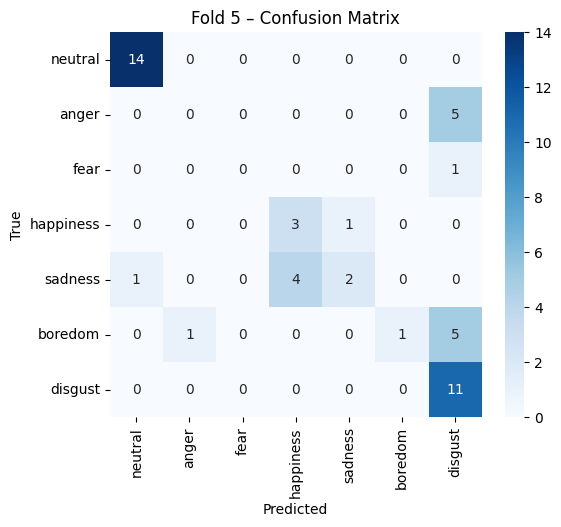


=== Fold 6 ===
Train speakers: [np.str_('03'), np.str_('08'), np.str_('09'), np.str_('10'), np.str_('11'), np.str_('12'), np.str_('13'), np.str_('14')]
Val speakers:   ['16']
Test speakers:  ['15']
Epoch 01 | train_acc=0.478 | val_acc=0.408 | val_f1=0.300
Epoch 02 | train_acc=0.642 | val_acc=0.408 | val_f1=0.305
Epoch 03 | train_acc=0.731 | val_acc=0.507 | val_f1=0.469
Epoch 04 | train_acc=0.803 | val_acc=0.451 | val_f1=0.407
Epoch 05 | train_acc=0.856 | val_acc=0.324 | val_f1=0.274
Epoch 06 | train_acc=0.892 | val_acc=0.338 | val_f1=0.297
Epoch 07 | train_acc=0.916 | val_acc=0.563 | val_f1=0.542
Epoch 08 | train_acc=0.935 | val_acc=0.451 | val_f1=0.402
Epoch 09 | train_acc=0.946 | val_acc=0.437 | val_f1=0.386
Epoch 10 | train_acc=0.955 | val_acc=0.394 | val_f1=0.346
Epoch 11 | train_acc=0.962 | val_acc=0.451 | val_f1=0.408
Epoch 12 | train_acc=0.967 | val_acc=0.549 | val_f1=0.521
Epoch 13 | train_acc=0.970 | val_acc=0.465 | val_f1=0.433
Epoch 14 | train_acc=0.974 | val_acc=0.451 | va

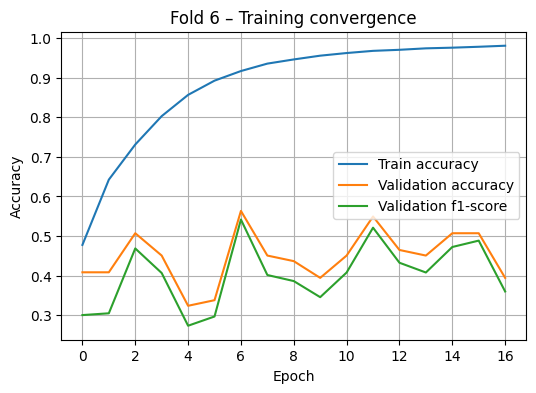

========= LAST MODEL PERF =========
Fold 6 TEST utterance accuracy: 0.500

Classification report:
              precision    recall  f1-score   support

     neutral      0.722     1.000     0.839        13
       anger      0.000     0.000     0.000         9
        fear      0.800     0.800     0.800         5
   happiness      1.000     0.500     0.667         8
     sadness      0.333     0.167     0.222         6
     boredom      0.190     1.000     0.320         4
     disgust      1.000     0.182     0.308        11

    accuracy                          0.500        56
   macro avg      0.578     0.521     0.451        56
weighted avg      0.628     0.500     0.468        56



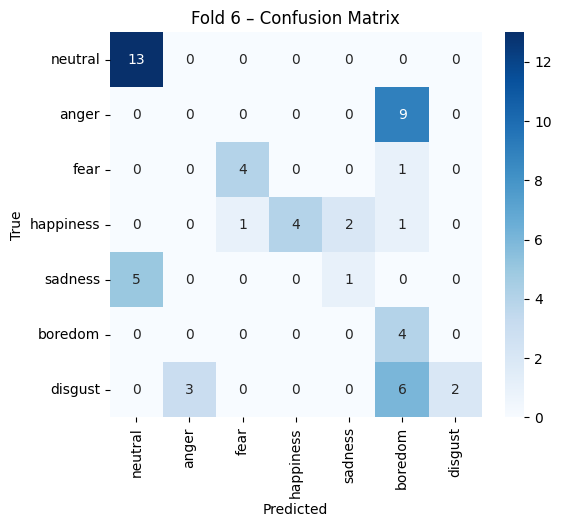

========= BEST MODEL PERF =========
Fold 6 TEST utterance accuracy: 0.554

Classification report:
              precision    recall  f1-score   support

     neutral      0.722     1.000     0.839        13
       anger      0.000     0.000     0.000         9
        fear      0.571     0.800     0.667         5
   happiness      1.000     0.375     0.545         8
     sadness      0.500     0.167     0.250         6
     boredom      0.222     1.000     0.364         4
     disgust      1.000     0.545     0.706        11

    accuracy                          0.554        56
   macro avg      0.574     0.555     0.481        56
weighted avg      0.627     0.554     0.524        56



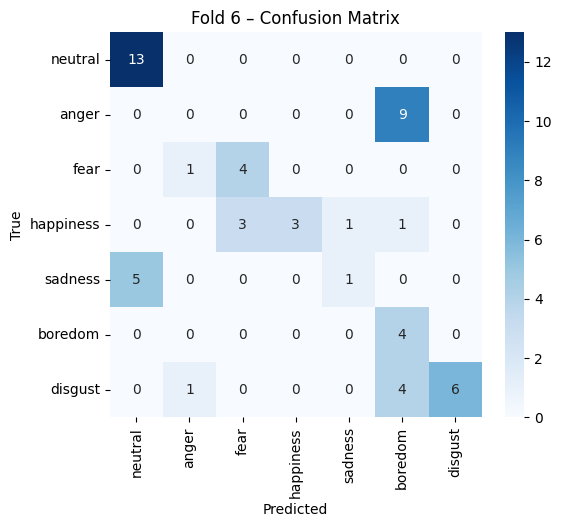


=== Fold 7 ===
Train speakers: [np.str_('03'), np.str_('08'), np.str_('09'), np.str_('10'), np.str_('12'), np.str_('14'), np.str_('15'), np.str_('16')]
Val speakers:   ['13']
Test speakers:  ['11']
Epoch 01 | train_acc=0.423 | val_acc=0.410 | val_f1=0.329
Epoch 02 | train_acc=0.599 | val_acc=0.557 | val_f1=0.526
Epoch 03 | train_acc=0.690 | val_acc=0.459 | val_f1=0.424
Epoch 04 | train_acc=0.773 | val_acc=0.541 | val_f1=0.531
Epoch 05 | train_acc=0.840 | val_acc=0.508 | val_f1=0.480
Epoch 06 | train_acc=0.884 | val_acc=0.508 | val_f1=0.497
Epoch 07 | train_acc=0.917 | val_acc=0.508 | val_f1=0.465
Epoch 08 | train_acc=0.936 | val_acc=0.443 | val_f1=0.398
Epoch 09 | train_acc=0.950 | val_acc=0.443 | val_f1=0.398
Epoch 10 | train_acc=0.958 | val_acc=0.541 | val_f1=0.526
Epoch 11 | train_acc=0.965 | val_acc=0.459 | val_f1=0.440
Epoch 12 | train_acc=0.970 | val_acc=0.459 | val_f1=0.408
Epoch 13 | train_acc=0.975 | val_acc=0.508 | val_f1=0.471
Epoch 14 | train_acc=0.977 | val_acc=0.475 | va

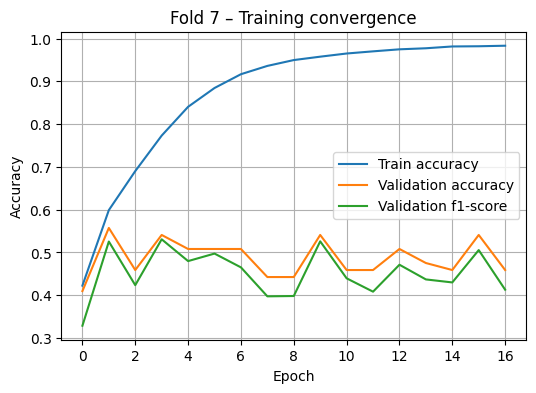

========= LAST MODEL PERF =========
Fold 7 TEST utterance accuracy: 0.618

Classification report:
              precision    recall  f1-score   support

     neutral      0.714     0.909     0.800        11
       anger      0.200     0.125     0.154         8
        fear      1.000     0.500     0.667         2
   happiness      0.800     0.400     0.533        10
     sadness      0.500     0.375     0.429         8
     boredom      0.438     1.000     0.609         7
     disgust      1.000     0.889     0.941         9

    accuracy                          0.618        55
   macro avg      0.665     0.600     0.590        55
weighted avg      0.646     0.618     0.597        55



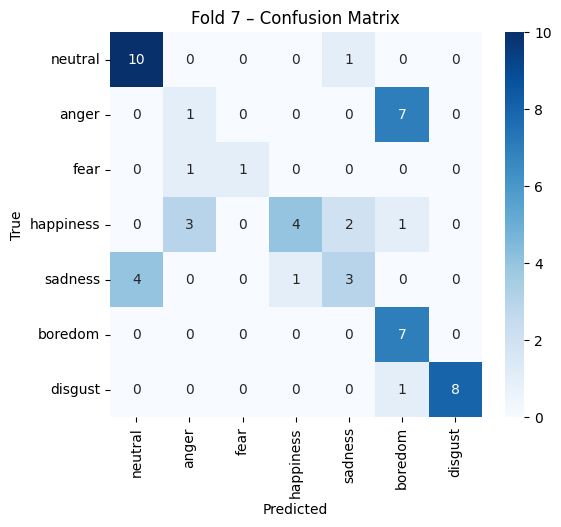

========= BEST MODEL PERF =========
Fold 7 TEST utterance accuracy: 0.509

Classification report:
              precision    recall  f1-score   support

     neutral      0.786     1.000     0.880        11
       anger      0.000     0.000     0.000         8
        fear      0.000     0.000     0.000         2
   happiness      0.000     0.000     0.000        10
     sadness      0.667     0.250     0.364         8
     boredom      0.438     1.000     0.609         7
     disgust      0.471     0.889     0.615         9

    accuracy                          0.509        55
   macro avg      0.337     0.448     0.353        55
weighted avg      0.387     0.509     0.407        55



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


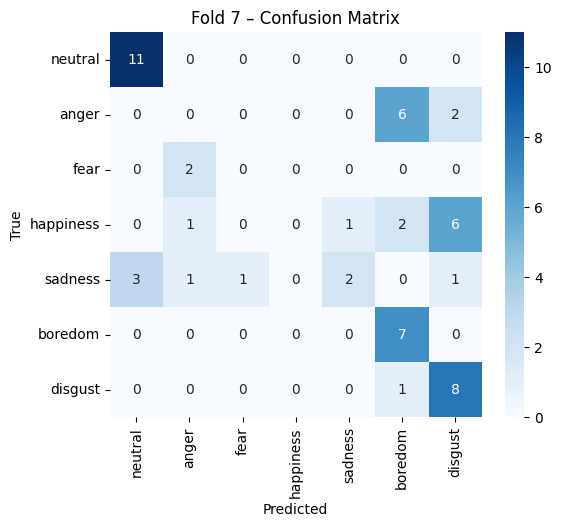


=== Fold 8 ===
Train speakers: [np.str_('03'), np.str_('08'), np.str_('09'), np.str_('10'), np.str_('11'), np.str_('13'), np.str_('15'), np.str_('16')]
Val speakers:   ['14']
Test speakers:  ['12']
Epoch 01 | train_acc=0.428 | val_acc=0.478 | val_f1=0.389
Epoch 02 | train_acc=0.589 | val_acc=0.536 | val_f1=0.458
Epoch 03 | train_acc=0.696 | val_acc=0.754 | val_f1=0.719
Epoch 04 | train_acc=0.781 | val_acc=0.739 | val_f1=0.668
Epoch 05 | train_acc=0.848 | val_acc=0.739 | val_f1=0.716
Epoch 06 | train_acc=0.893 | val_acc=0.681 | val_f1=0.655
Epoch 07 | train_acc=0.922 | val_acc=0.652 | val_f1=0.590
Epoch 08 | train_acc=0.940 | val_acc=0.681 | val_f1=0.630
Epoch 09 | train_acc=0.953 | val_acc=0.725 | val_f1=0.690
Epoch 10 | train_acc=0.961 | val_acc=0.652 | val_f1=0.606
Epoch 11 | train_acc=0.967 | val_acc=0.638 | val_f1=0.571
Epoch 12 | train_acc=0.971 | val_acc=0.754 | val_f1=0.710
Epoch 13 | train_acc=0.976 | val_acc=0.681 | val_f1=0.626
Epoch 14 | train_acc=0.978 | val_acc=0.754 | va

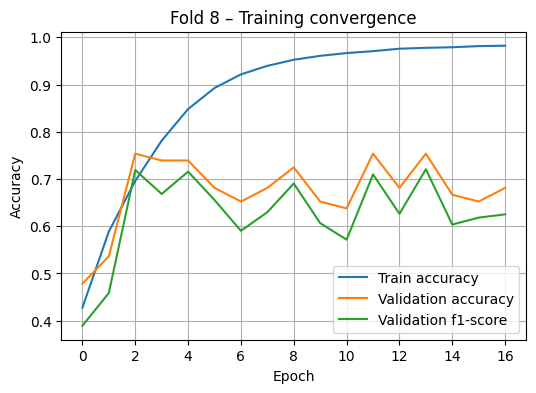

========= LAST MODEL PERF =========
Fold 8 TEST utterance accuracy: 0.657

Classification report:
              precision    recall  f1-score   support

     neutral      0.857     1.000     0.923        12
       anger      0.500     0.400     0.444         5
        fear      1.000     0.500     0.667         2
   happiness      1.000     0.333     0.500         6
     sadness      0.000     0.000     0.000         2
     boredom      1.000     1.000     1.000         4
     disgust      0.250     0.500     0.333         4

    accuracy                          0.657        35
   macro avg      0.658     0.533     0.553        35
weighted avg      0.737     0.657     0.656        35



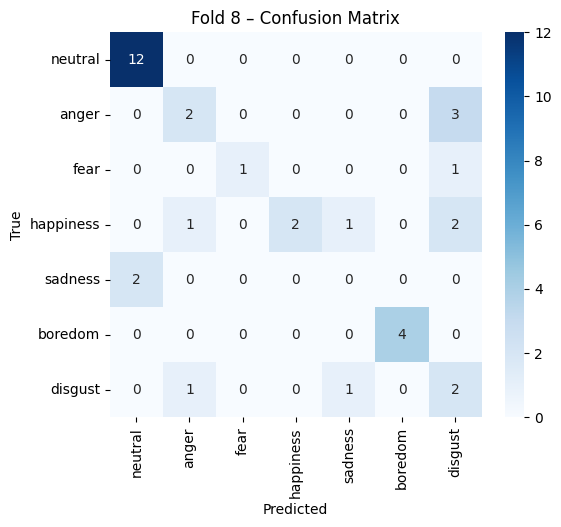

========= BEST MODEL PERF =========
Fold 8 TEST utterance accuracy: 0.686

Classification report:
              precision    recall  f1-score   support

     neutral      0.857     1.000     0.923        12
       anger      1.000     0.200     0.333         5
        fear      0.000     0.000     0.000         2
   happiness      0.800     0.667     0.727         6
     sadness      0.000     0.000     0.000         2
     boredom      1.000     1.000     1.000         4
     disgust      0.429     0.750     0.545         4

    accuracy                          0.686        35
   macro avg      0.584     0.517     0.504        35
weighted avg      0.737     0.686     0.665        35



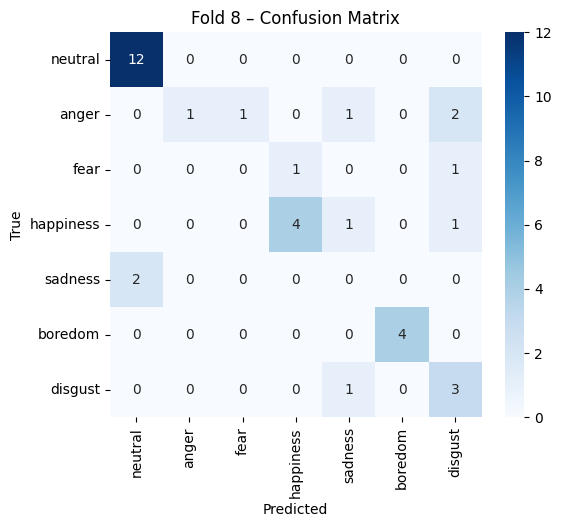


=== Fold 9 ===
Train speakers: [np.str_('03'), np.str_('08'), np.str_('09'), np.str_('10'), np.str_('12'), np.str_('14'), np.str_('15'), np.str_('16')]
Val speakers:   ['11']
Test speakers:  ['13']
Epoch 01 | train_acc=0.490 | val_acc=0.400 | val_f1=0.291
Epoch 02 | train_acc=0.630 | val_acc=0.418 | val_f1=0.316
Epoch 03 | train_acc=0.725 | val_acc=0.600 | val_f1=0.458
Epoch 04 | train_acc=0.800 | val_acc=0.673 | val_f1=0.520
Epoch 05 | train_acc=0.857 | val_acc=0.673 | val_f1=0.644
Epoch 06 | train_acc=0.898 | val_acc=0.564 | val_f1=0.414
Epoch 07 | train_acc=0.924 | val_acc=0.600 | val_f1=0.538
Epoch 08 | train_acc=0.944 | val_acc=0.600 | val_f1=0.477
Epoch 09 | train_acc=0.955 | val_acc=0.636 | val_f1=0.573
Epoch 10 | train_acc=0.963 | val_acc=0.618 | val_f1=0.498
Epoch 11 | train_acc=0.968 | val_acc=0.673 | val_f1=0.565
Epoch 12 | train_acc=0.973 | val_acc=0.545 | val_f1=0.477
Epoch 13 | train_acc=0.976 | val_acc=0.636 | val_f1=0.519
Epoch 14 | train_acc=0.978 | val_acc=0.600 | va

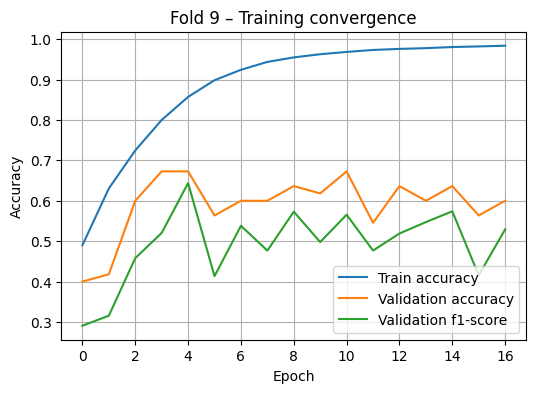

========= LAST MODEL PERF =========
Fold 9 TEST utterance accuracy: 0.508

Classification report:
              precision    recall  f1-score   support

     neutral      0.846     0.917     0.880        12
       anger      0.286     0.200     0.235        10
        fear      0.667     0.500     0.571         8
   happiness      0.357     0.714     0.476         7
     sadness      1.000     0.400     0.571        10
     boredom      0.294     1.000     0.455         5
     disgust      0.000     0.000     0.000         9

    accuracy                          0.508        61
   macro avg      0.493     0.533     0.456        61
weighted avg      0.530     0.508     0.472        61



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


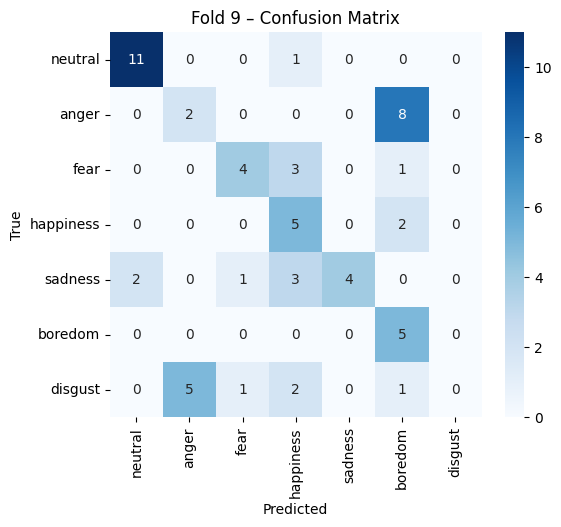

========= BEST MODEL PERF =========
Fold 9 TEST utterance accuracy: 0.377

Classification report:
              precision    recall  f1-score   support

     neutral      1.000     0.167     0.286        12
       anger      0.333     0.200     0.250        10
        fear      1.000     0.375     0.545         8
   happiness      0.300     0.429     0.353         7
     sadness      0.412     0.700     0.519        10
     boredom      0.227     1.000     0.370         5
     disgust      1.000     0.111     0.200         9

    accuracy                          0.377        61
   macro avg      0.610     0.426     0.360        61
weighted avg      0.651     0.377     0.354        61



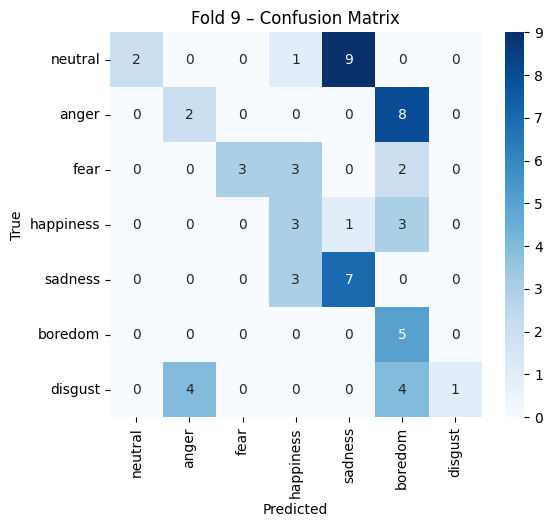


=== Fold 10 ===
Train speakers: [np.str_('03'), np.str_('08'), np.str_('11'), np.str_('12'), np.str_('13'), np.str_('14'), np.str_('15'), np.str_('16')]
Val speakers:   ['09']
Test speakers:  ['10']
Epoch 01 | train_acc=0.473 | val_acc=0.651 | val_f1=0.510
Epoch 02 | train_acc=0.617 | val_acc=0.674 | val_f1=0.675
Epoch 03 | train_acc=0.704 | val_acc=0.744 | val_f1=0.740
Epoch 04 | train_acc=0.781 | val_acc=0.628 | val_f1=0.554
Epoch 05 | train_acc=0.845 | val_acc=0.651 | val_f1=0.632
Epoch 06 | train_acc=0.887 | val_acc=0.651 | val_f1=0.624
Epoch 07 | train_acc=0.914 | val_acc=0.605 | val_f1=0.551
Epoch 08 | train_acc=0.934 | val_acc=0.698 | val_f1=0.683
Epoch 09 | train_acc=0.947 | val_acc=0.698 | val_f1=0.735
Epoch 10 | train_acc=0.955 | val_acc=0.651 | val_f1=0.631
Epoch 11 | train_acc=0.962 | val_acc=0.674 | val_f1=0.657
Epoch 12 | train_acc=0.968 | val_acc=0.651 | val_f1=0.555
Epoch 13 | train_acc=0.972 | val_acc=0.628 | val_f1=0.596
Epoch 14 | train_acc=0.974 | val_acc=0.674 | v

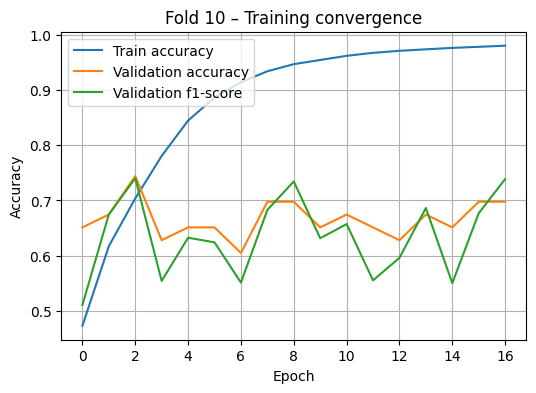

========= LAST MODEL PERF =========
Fold 10 TEST utterance accuracy: 0.474

Classification report:
              precision    recall  f1-score   support

     neutral      1.000     0.800     0.889        10
       anger      0.250     0.125     0.167         8
        fear      0.250     1.000     0.400         1
   happiness      0.600     0.375     0.462         8
     sadness      1.000     0.500     0.667         4
     boredom      0.200     1.000     0.333         3
     disgust      0.000     0.000     0.000         4

    accuracy                          0.474        38
   macro avg      0.471     0.543     0.417        38
weighted avg      0.570     0.474     0.473        38



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


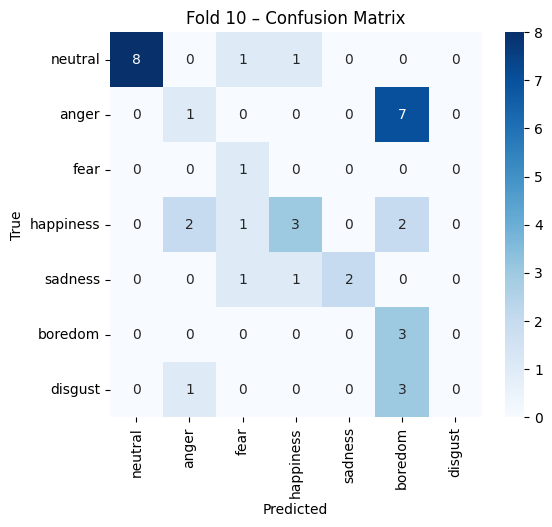

========= BEST MODEL PERF =========
Fold 10 TEST utterance accuracy: 0.395

Classification report:
              precision    recall  f1-score   support

     neutral      0.889     0.800     0.842        10
       anger      0.000     0.000     0.000         8
        fear      0.143     1.000     0.250         1
   happiness      0.600     0.375     0.462         8
     sadness      0.000     0.000     0.000         4
     boredom      0.188     1.000     0.316         3
     disgust      0.000     0.000     0.000         4

    accuracy                          0.395        38
   macro avg      0.260     0.454     0.267        38
weighted avg      0.379     0.395     0.350        38



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


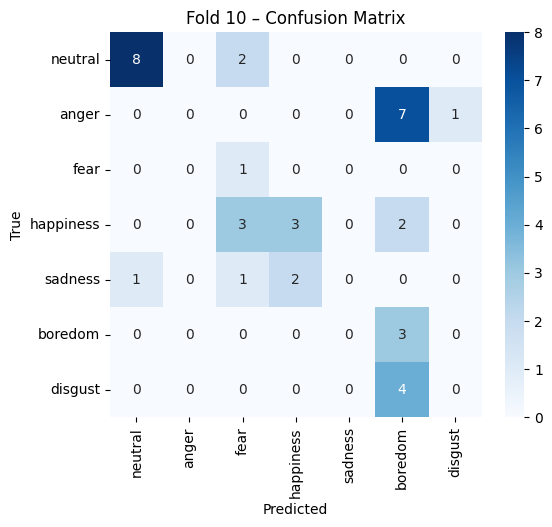

In [ ]:
fold_accuracies = []
audio_cache = {}

for fold, (train_idx, test_idx) in enumerate(kf.split(speaker_ids), 1):
    train_acc_hist = []
    val_acc_hist = []
    val_f1_hist = []
    all_train_speakers = speaker_ids[train_idx]
    test_speakers     = speaker_ids[test_idx]

    # --- split train speakers into train / validation
    val_speaker = VAL_SPEAKER_PER_TEST[test_speakers[0]]

    train_speakers = [
        s for s in all_train_speakers
        if s != val_speaker
    ]
    val_speakers = [val_speaker]

    train_items = sum([speaker_to_items[s] for s in train_speakers], [])
    val_items   = sum([speaker_to_items[s] for s in val_speakers], [])
    test_items  = sum([speaker_to_items[s] for s in test_speakers], [])

    # --- datasets
    train_set = EmoDBDataset(
        train_items,
        EMODB_ROOT,
        audio_cache=audio_cache
    )
    train_loader = DataLoader(
        train_set,
        batch_size=128,
        shuffle=True,
        drop_last=True
    )

    # --- model & optimization
    model = build_rawcnn_model()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    best_val_f1 = 0.0
    best_state = None

    print(f"\n=== Fold {fold} ===")
    print(f"Train speakers: {train_speakers}")
    print(f"Val speakers:   {val_speakers}")
    print(f"Test speakers:  {test_speakers}")

    for epoch in range(1, 18):
        tr_acc = train_epoch(model, train_loader, optimizer, criterion)
        val_acc, y_true, y_pred = eval_utterance_level(model, val_items, EMODB_ROOT,return_preds=True)
        val_f1 = f1_score(y_true, y_pred, average="macro")

        train_acc_hist.append(tr_acc)
        val_acc_hist.append(val_acc)
        val_f1_hist.append(val_f1)
        print(
            f"Epoch {epoch:02d} | "
            f"train_acc={tr_acc:.3f} | val_acc={val_acc:.3f} | val_f1={val_f1:.3f}"
        )
    
        if val_f1 >= best_val_f1:
            best_val_f1 = val_f1
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
    
    plt.figure(figsize=(6, 4))
    plt.plot(train_acc_hist, label="Train accuracy")
    plt.plot(val_acc_hist, label="Validation accuracy")
    plt.plot(val_f1_hist, label="Validation f1-score")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Fold {fold} – Training convergence")
    plt.legend()
    plt.grid(True)
    plt.show()
    print("========= LAST MODEL PERF =========")
    te_acc, y_true, y_pred = eval_utterance_level(
        model,
        test_items,
        EMODB_ROOT,
        return_preds=True
    )
    
    print(f"Fold {fold} TEST utterance accuracy: {te_acc:.3f}")
    print("\nClassification report:")
    print(
        classification_report(
            y_true,
            y_pred,
            target_names=[EMOTION_MAP_INV[i] for i in range(N_CLASSES)],
            digits=3
        )
    )
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=EMOTION_MAP_INV.values(),
        yticklabels=EMOTION_MAP_INV.values()
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Fold {fold} – Confusion Matrix")
    plt.show()
    print("========= BEST MODEL PERF =========")
    # --- test with best validation model
    model.load_state_dict(best_state)
    if fold == 1:
        torch.save(model, "/kaggle/working/sincnet_emodb_fold1_best.pt")

    te_acc, y_true, y_pred = eval_utterance_level(
        model,
        test_items,
        EMODB_ROOT,
        return_preds=True
    )
    
    print(f"Fold {fold} TEST utterance accuracy: {te_acc:.3f}")
    print("\nClassification report:")
    print(
        classification_report(
            y_true,
            y_pred,
            target_names=[EMOTION_MAP_INV[i] for i in range(N_CLASSES)],
            digits=3
        )
    )
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=EMOTION_MAP_INV.values(),
        yticklabels=EMOTION_MAP_INV.values()
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Fold {fold} – Confusion Matrix")
    plt.show()

    fold_accuracies.append(te_acc)

In [ ]:
# same problem as before 
last_acc = np.array([0.710, 0.674, 0.577, 0.690, 0.510, 0.500, 0.618, 0.657, 0.508, 0.474])
last_f1  = np.array([0.655, 0.621, 0.565, 0.573, 0.218, 0.451, 0.590, 0.553, 0.456, 0.417])
best_acc = np.array([0.696, 0.721, 0.324, 0.517, 0.633, 0.554, 0.509, 0.686, 0.377, 0.395])
best_f1  = np.array([0.696, 0.610, 0.275, 0.438, 0.404, 0.481, 0.353, 0.504, 0.360, 0.267])

In [ ]:
print("\n===== FINAL RESULTS LAST Model =====")
print("Per-fold accuracy:", np.round(last_acc, 3))
print(f"Mean: {last_acc.mean():.3f}")
print(f"Std:  {last_acc.std():.3f}")
print("Per-fold f1-score:", np.round(last_f1, 3))
print(f"Mean: {last_f1.mean():.3f}")
print(f"Std:  {last_f1.std():.3f}")
print("\n===== FINAL RESULTS Best Model =====")
print("Per-fold accuracy:", np.round(best_acc, 3))
print(f"Mean: {best_acc.mean():.3f}")
print(f"Std:  {best_acc.std():.3f}")
print("Per-fold f1-score:", np.round(best_f1, 3))
print(f"Mean: {best_f1.mean():.3f}")
print(f"Std:  {best_f1.std():.3f}")


===== FINAL RESULTS LAST Model =====
Per-fold accuracy: [0.71  0.674 0.577 0.69  0.51  0.5   0.618 0.657 0.508 0.474]
Mean: 0.592
Std:  0.085
Per-fold f1-score: [0.655 0.621 0.565 0.573 0.218 0.451 0.59  0.553 0.456 0.417]
Mean: 0.510
Std:  0.122

===== FINAL RESULTS Best Model =====
Per-fold accuracy: [0.696 0.721 0.324 0.517 0.633 0.554 0.509 0.686 0.377 0.395]
Mean: 0.541
Std:  0.135
Per-fold f1-score: [0.696 0.61  0.275 0.438 0.404 0.481 0.353 0.504 0.36  0.267]
Mean: 0.439
Std:  0.131


On remarque donc ici tout l'intéret du filtre Sincnet qui permet la compréhension fine des chunks audio. Ici l'utilisation du jeu de données de validation semble plus pertinant que dans le cas précédent. La perte de performance dans ce cas est de presque 13 % d'accuracy. On remarque malgré tout que dans le premier fold, l'accuracy obtenue est très proche de celle obtenue avec les modèles de Machine Learning baseline. Ces résultats peuvent ici s'expliquer par le fait qu'on travaille avec un CNN sur de très petit chunk temporels, ce qui peut rendre l'interprétation temporelle plus délicate si on ne dispose pas des outils adaptés (c'est à dire des filtres Sincnet).

### 4. Visualisation des filtres Sincnet

In [2]:
# Load checkpoint instead of training
device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint_path = "sincnet_emodb_fold1_best.pt"

print(f"\n=== Loading checkpoint: {checkpoint_path} ===")
model = torch.load(checkpoint_path, map_location=device, weights_only=False)
print(f"✓ Model loaded successfully")

model.to(device)
model.eval()


=== Loading checkpoint: sincnet_emodb_fold1_best.pt ===
✓ Model loaded successfully


Sequential(
  (0): SincNet(
    (conv): ModuleList(
      (0): SincConv_fast()
      (1): Conv1d(80, 60, kernel_size=(5,), stride=(1,))
      (2): Conv1d(60, 60, kernel_size=(5,), stride=(1,))
    )
    (bn): ModuleList(
      (0): BatchNorm1d(80, eps=983, momentum=0.05, affine=True, track_running_stats=True)
      (1): BatchNorm1d(60, eps=326, momentum=0.05, affine=True, track_running_stats=True)
      (2): BatchNorm1d(60, eps=107, momentum=0.05, affine=True, track_running_stats=True)
    )
    (ln): ModuleList(
      (0-2): 3 x LayerNorm()
    )
    (act): ModuleList(
      (0-2): 3 x ReLU()
    )
    (drop): ModuleList(
      (0-2): 3 x Dropout(p=0.0, inplace=False)
    )
    (ln0): LayerNorm()
  )
  (1): MLP(
    (wx): ModuleList(
      (0): Linear(in_features=6420, out_features=2048, bias=True)
      (1): Linear(in_features=2048, out_features=2048, bias=True)
    )
    (bn): ModuleList(
      (0-1): 2 x BatchNorm1d(2048, eps=1e-05, momentum=0.05, affine=True, track_running_stats=T

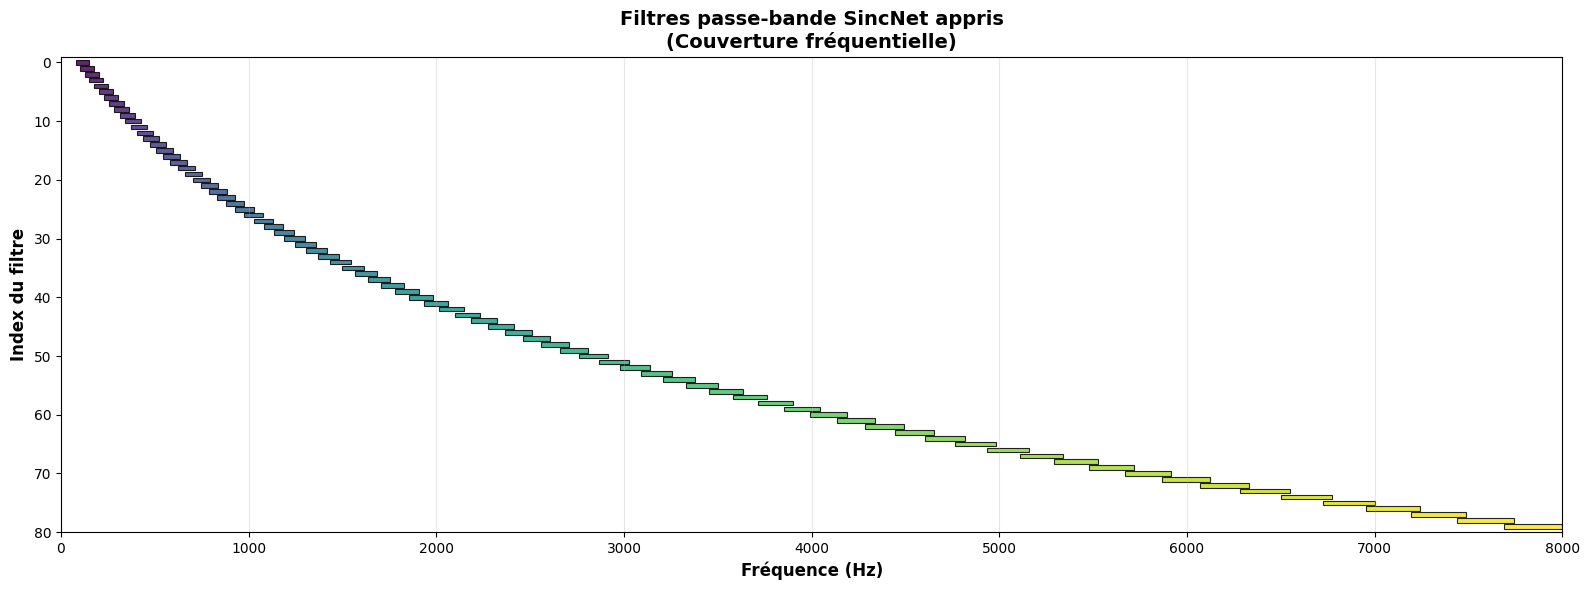

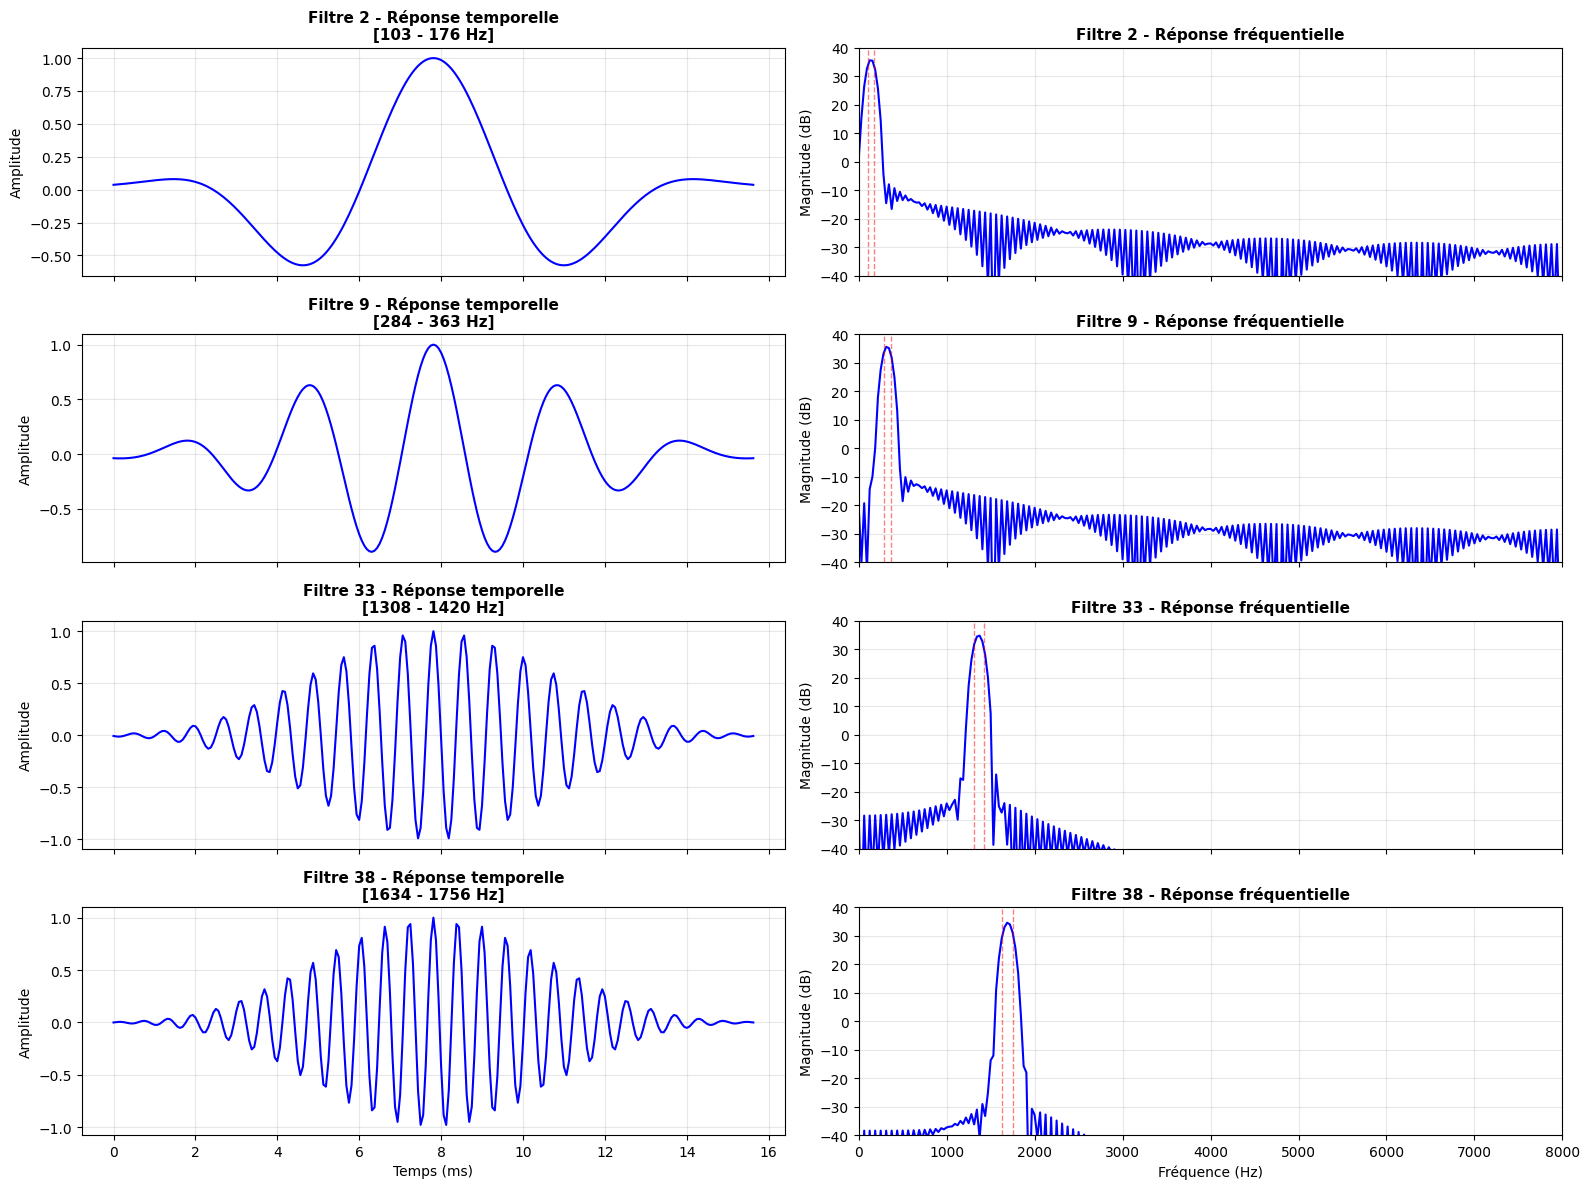

In [17]:
# Extraire la couche SincNet du modèle
sincnet_layer = model[0].conv[0]

# Paramètres
fs = 16000
N_filt = sincnet_layer.out_channels
kernel_size = sincnet_layer.kernel_size

# Récupérer les paramètres appris
low_hz = sincnet_layer.min_low_hz + torch.abs(sincnet_layer.low_hz_).detach().cpu()
high_hz = torch.clamp(
    low_hz + sincnet_layer.min_band_hz + torch.abs(sincnet_layer.band_hz_).detach().cpu(),
    sincnet_layer.min_low_hz,
    sincnet_layer.sample_rate / 2
)
band_hz = (high_hz - low_hz).squeeze()

# Générer les filtres
with torch.no_grad():
    dummy_input = torch.zeros(1, 1, kernel_size).to(device)
    sincnet_layer(dummy_input)
    filters = sincnet_layer.filters.detach().cpu().numpy()

# Nombre de filtres à afficher
n_display = 4
#selected_filters = [0, N_filt//2, N_filt-1]  # Premier, milieu, dernier
selected_filters = np.sort(np.random.choice(N_filt, n_display, replace=False))

# ===== FIGURE 1 : Couverture fréquentielle =====
fig1 = plt.figure(figsize=(16, 6))
ax0 = fig1.add_subplot(111)
num_filters = N_filt
sample_rate = fs

colors = plt.cm.viridis(np.linspace(0, 1, num_filters))

for i in range(num_filters):
    width = high_hz[i][0] - low_hz[i][0]
    ax0.barh(i, width, left=low_hz[i][0], color=colors[i], alpha=0.85, edgecolor='black', linewidth=0.8)

ax0.set_xlim([0, sample_rate/2])
ax0.set_ylim([-1, num_filters])
ax0.set_xlabel('Fréquence (Hz)', fontsize=12, fontweight='bold')
ax0.set_ylabel('Index du filtre', fontsize=12, fontweight='bold')
ax0.set_title('Filtres passe-bande SincNet appris\n(Couverture fréquentielle)', fontsize=14, fontweight='bold')
ax0.grid(True, alpha=0.3, axis='x')
ax0.invert_yaxis()

plt.tight_layout()
plt.show()

# ===== FIGURE 2 : Réponses temporelles et fréquentielles =====
fig2, axes = plt.subplots(n_display, 2, figsize=(16, 12), sharex='col')

time_axis = np.arange(kernel_size) / fs * 1000  # en ms
n_fft = 512
freqs = fftfreq(n_fft, 1/fs)[:n_fft//2]

for idx, filter_idx in enumerate(selected_filters):
    # Réponse temporelle
    ax_time = axes[idx, 0]
    ax_time.plot(time_axis, filters[filter_idx, 0, :], linewidth=1.5, color='b')
    ax_time.set_ylabel('Amplitude', fontsize=10)
    ax_time.set_title(f'Filtre {filter_idx+1} - Réponse temporelle\n[{low_hz[filter_idx][0]:.0f} - {high_hz[filter_idx][0]:.0f} Hz]', fontsize=11, fontweight='bold')
    ax_time.grid(True, alpha=0.3)
    if idx == n_display - 1:
        ax_time.set_xlabel('Temps (ms)', fontsize=10)
    
    # Réponse fréquentielle
    ax_freq = axes[idx, 1]
    fft_filter = fft(filters[filter_idx, 0, :], n=n_fft)
    magnitude = 20 * np.log10(np.abs(fft_filter[:n_fft//2]) + 1e-10)
    ax_freq.plot(freqs, magnitude, linewidth=1.5, color='b')
    ax_freq.set_ylabel('Magnitude (dB)', fontsize=10)
    ax_freq.set_title(f'Filtre {filter_idx+1} - Réponse fréquentielle', fontsize=11, fontweight='bold')
    ax_freq.set_xlim(0, fs/2)
    ax_freq.set_ylim(-40, 40)
    ax_freq.grid(True, alpha=0.3)
    if idx == n_display - 1:
        ax_freq.set_xlabel('Fréquence (Hz)', fontsize=10)
    
    # Fréquences de coupure
    ax_freq.axvline(low_hz[filter_idx][0], color='red', linestyle='--', alpha=0.5, linewidth=1)
    ax_freq.axvline(high_hz[filter_idx][0], color='red', linestyle='--', alpha=0.5, linewidth=1)

plt.tight_layout()
plt.show()

Le réseau apprend effectivement des filtres passe-bande significatifs directement à partir de la forme d'onde, avec un nombre minimal de paramètres.

Le graphique de couverture fréquentielle révèle une organisation non-linéaire des filtres appris, avec forte densité en basses fréquences puis élargissement progressif : la majorité des filtres se concentrent dans la zone 0 - 1000 Hz (il s'agit de l'information émotionnelle critique). À mesure que la fréquence augmente, les bandes passantes s'élargissent. 

L'analyse des réponses impulsionnelles et fréquentielles montre que SincNet force l'apprentissage de filtres passe-bande avec des lobes principaux nets et une atténuation forte dans la bande coupée.

### <u>Partie V : Conclusion et perspectives</u>

Notre projet a permis de confronter une approche classique ML à une architecture d'apprentissage profond spécialisée pour le traitement du signal (SincNet) adaptée pour la reconnaissance d'émotions sur le dataset EMO-DB.

La baseline XGBoost est particulièrement robuste (76.8% accuracy) sur notre petit jeu de données, mais SincNet a atteint des performances comparables (72.0%) globalement et même bien meilleure sur le même échantillon de test. L'analyse des filtres appris a confirmé que le réseau est capable d'extraire, directement depuis le signal brut, des caractéristiques fréquentielles physiquement interprétables.

**Limites et Faiblesses de notre approche**

Au-delà des résultats quantitatifs, nous avons relevé plusieurs limites de notre approche.

* **Volume de données assez faible :** Avec seulement ~535 fichiers audio et 10 locuteurs, le dataset est extrêmement petit pour une approche Deep Learning. Cela explique pourquoi SincNet (72.0%) ne surclasse pas significativement la baseline XGBoost (76.8%) : les réseaux de neurones profonds nécessitent généralement des ordres de grandeur supérieurs pour extraire des features vraiment robustes sans surapprendre.
* **Biais de "Jeu d'acteur" :** Les émotions sont jouées par des acteurs (non spontanées) et dans une langue spécifique (Allemand). Les modèles appris risquent de ne pas être transférables à des conversations réelles ou d'autres langues.

* **Perte de contexte temporel :** Le découpage en segments courts, nécessaire pour standardiser l'entrée du réseau, présente un inconvénient majeur pour l'émotion. L'information prosodique s'observe souvent sur la durée totale de l'énoncé (ou au moins une durée plus longue). En coupant le signal, certaines émotions (comme la tristesse ou l'ennui, souvent lentes) sont plus difficiles à détecter.

* **"Single Speaker Validation" :** Utiliser un seul locuteur pour le set de validation introduit un biais aléatoire assez fort. Si le locuteur de validation est "atypique", il induit en erreur le choix du meilleur modèle, nous faisant potentiellement rejeter des modèles qui auraient mieux généralisé.

Pour améliorer la performance, il serait nécessaire par exemple de changer d'échelle de données : pourquoi pas fusionner plusieurs datasets (IEMOCAP, RAVDESS) ou utiliser de l'augmentation de données plus agressive (bruitage, shift temporel, mixup).